# Error Analisys using MLP's on original Dataset

### First we're going to tune up a simple mlp to analize the generalization error

### Setting up variables, library and data

In [1]:
import pandas as pd
import numpy as np

## Data path handlers
TRAIN_TEST_SET_PATH = '../../Data/train_test/'
META_DATA_PATH = '../../Data/meta/'
AUG_SET_PATH = '../../Data/aug_data_all/'
MODEL_PATH = '../../Models/'
IMAGES_PATH = '../../Images/'

## Selecting the desired features
parameters = 'fz'

In [2]:
### Getting data
X_train = pd.read_csv(TRAIN_TEST_SET_PATH+'X_train.csv',index_col=0)
y_train = pd.read_csv(TRAIN_TEST_SET_PATH+'y_train.csv',index_col=0)
X_test = pd.read_csv(TRAIN_TEST_SET_PATH+'X_test.csv',index_col=0)
y_test = pd.read_csv(TRAIN_TEST_SET_PATH+'y_test.csv',index_col=0)

In [3]:
### Selecting features
X_train = X_train.iloc[:, X_train.columns.str.contains(parameters)]
X_test = X_test.iloc[:, X_test.columns.str.contains(parameters)]

X_train['labels'] = y_train.copy()

TypeError: first argument must be string or compiled pattern

In [4]:
### Creating the validation set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train, val in split.split(X_train, X_train['labels']):
    X_train_vl = X_train.iloc[train].copy()
    X_val = X_train.iloc[val].copy()
    
y_train_vl = X_train_vl['labels'].copy()
y_val = X_val['labels'].copy()


X_train_vl = X_train_vl.iloc[:, ~X_train_vl.columns.str.contains('labels')]
X_val = X_val.iloc[:, ~X_val.columns.str.contains('labels')]
X_train = X_train.iloc[:, ~X_train.columns.str.contains('labels')]

y_train_vl = np.array(y_train_vl)-1
y_val = np.array(y_val)-1
y_test = np.array(y_test)-1
y_train = np.array(y_train)-1

In [5]:
### Standardizing the data
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
X_train_vl = std_scaler.transform(X_train_vl)
X_val = std_scaler.transform(X_val)

In [6]:
### Training a simple mlp to use as reference
import tensorflow as tf
from tensorflow import keras

In [ ]:
### Setting Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                               restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(MODEL_PATH+"lstm_simple.h5",
                                                save_best_only=True)                                     

get_stats = pd.DataFrame([])
get_stats.to_csv(META_DATA_PATH+'lstm_error_analysis.csv')

## Error analysis

### Checking performance improvement feeding a stream of data

In [69]:
### Here we're going to retrain the model for each data set size.
### ranging from 1 to len(X_train)

## This variable will get the stats fo each training results
stats = pd.DataFrame([])

## The amount of data added for each training
data_batch = 1
number_of_steps = int(X_train.shape[0]/data_batch)

## Setting the prediction data frame which will store the predictions of each trained model
pred_columns = [(lambda x: 'size_'+str(x))(x) for x in np.arange(number_of_steps)*data_batch]
pred_shape = np.zeros(number_of_steps*y_test.shape[0]).reshape(y_test.shape[0], number_of_steps)
predictions = pd.DataFrame(pred_shape, columns=pred_columns)

## Recreating the optimized model but with re-initialized weights in order to fit them with each data size
config = keras.models.load_model(MODEL_PATH+'mlp_simple.h5').get_config()
mlp_model = keras.Sequential.from_config(config)

optimizer = keras.optimizers.SGD(lr=pd.read_csv(MODEL_PATH+'mlp_simple_bp.csv', 
                                                usecols=['learning_rate'])['learning_rate'].iloc[0])

mlp_model.compile(optimizer=optimizer,
                  metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

init_weights = mlp_model.get_weights()

## Looping through the data size and training the model for each
for i in range(1, number_of_steps):
    mlp_model.set_weights(init_weights)
    
    if i*data_batch > X_train.shape[0]-1:
        history = mlp_model.fit(X_train[:X_train.shape[0]-1,:], y_train[:y_train.shape[0]-1], epochs=100,
                                validation_data=(X_test, y_test),
                                callbacks=[early_stopping], workers=8)
    
        predictions['size_'+str(i*data_batch)] = mlp_model.predict(X_test, y_test)
    
        temp = pd.DataFrame(history.history)
        stats = pd.append([stats, temp.iloc[temp.shape[0]-1,:]])
        break
    
    history = mlp_model.fit(X_train[:i*data_batch,:], y_train[:i*data_batch], epochs=100,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping], workers=8)
    
    predictions['size_'+str(i)] = np.argmax(mlp_model.predict(X_test), axis=1)
    
    temp = pd.DataFrame(history.history)
    stats = stats.append(temp.iloc[temp.shape[0]-1,:])

Train on 1 samples, validate on 96 samples
Epoch 1/100
1/1 [==============================] - 1s 614ms/sample - loss: 1.2000 - accuracy: 0.0000e+00 - val_loss: 0.9654 - val_accuracy: 0.5312
Epoch 2/100
1/1 [==============================] - 0s 73ms/sample - loss: 1.0902 - accuracy: 0.0000e+00 - val_loss: 0.9656 - val_accuracy: 0.5521
Epoch 3/100
1/1 [==============================] - 0s 44ms/sample - loss: 0.9814 - accuracy: 0.0000e+00 - val_loss: 0.9674 - val_accuracy: 0.5729
Epoch 4/100
1/1 [==============================] - 0s 53ms/sample - loss: 0.9044 - accuracy: 1.0000 - val_loss: 0.9682 - val_accuracy: 0.5938
Epoch 5/100
1/1 [==============================] - 0s 97ms/sample - loss: 0.8113 - accuracy: 1.0000 - val_loss: 0.9733 - val_accuracy: 0.5625
Epoch 6/100
1/1 [==============================] - 0s 79ms/sample - loss: 0.7598 - accuracy: 1.0000 - val_loss: 0.9767 - val_accuracy: 0.5104
Epoch 7/100
1/1 [==============================] - 0s 87ms/sample - loss: 0.7043 - accuracy:

Epoch 42/100
2/2 [==============================] - 0s 37ms/sample - loss: 0.0996 - accuracy: 1.0000 - val_loss: 0.8334 - val_accuracy: 0.6354
Epoch 43/100
2/2 [==============================] - 0s 39ms/sample - loss: 0.0947 - accuracy: 1.0000 - val_loss: 0.8355 - val_accuracy: 0.6354
Epoch 44/100
2/2 [==============================] - 0s 38ms/sample - loss: 0.0899 - accuracy: 1.0000 - val_loss: 0.8371 - val_accuracy: 0.6250
Epoch 45/100
2/2 [==============================] - 0s 37ms/sample - loss: 0.0856 - accuracy: 1.0000 - val_loss: 0.8388 - val_accuracy: 0.6250
Epoch 46/100
2/2 [==============================] - 0s 38ms/sample - loss: 0.0817 - accuracy: 1.0000 - val_loss: 0.8407 - val_accuracy: 0.6250
Epoch 47/100
2/2 [==============================] - 0s 40ms/sample - loss: 0.0779 - accuracy: 1.0000 - val_loss: 0.8433 - val_accuracy: 0.6250
Train on 3 samples, validate on 96 samples
Epoch 1/100
3/3 [==============================] - 0s 39ms/sample - loss: 0.9237 - accuracy: 0.6667

3/3 [==============================] - 0s 29ms/sample - loss: 0.1030 - accuracy: 1.0000 - val_loss: 0.7972 - val_accuracy: 0.7604
Epoch 53/100
3/3 [==============================] - 0s 24ms/sample - loss: 0.0993 - accuracy: 1.0000 - val_loss: 0.7974 - val_accuracy: 0.7500
Epoch 54/100
3/3 [==============================] - 0s 27ms/sample - loss: 0.0959 - accuracy: 1.0000 - val_loss: 0.7975 - val_accuracy: 0.7500
Epoch 55/100
3/3 [==============================] - 0s 22ms/sample - loss: 0.0927 - accuracy: 1.0000 - val_loss: 0.7977 - val_accuracy: 0.7500
Epoch 56/100
3/3 [==============================] - 0s 22ms/sample - loss: 0.0894 - accuracy: 1.0000 - val_loss: 0.7983 - val_accuracy: 0.7500
Epoch 57/100
3/3 [==============================] - 0s 25ms/sample - loss: 0.0866 - accuracy: 1.0000 - val_loss: 0.7986 - val_accuracy: 0.7396
Epoch 58/100
3/3 [==============================] - 0s 25ms/sample - loss: 0.0835 - accuracy: 1.0000 - val_loss: 0.7992 - val_accuracy: 0.7396
Epoch 59/100

Epoch 45/100
4/4 [==============================] - 0s 29ms/sample - loss: 0.3988 - accuracy: 0.7500 - val_loss: 0.7972 - val_accuracy: 0.8021
Epoch 46/100
4/4 [==============================] - 0s 25ms/sample - loss: 0.3907 - accuracy: 1.0000 - val_loss: 0.7959 - val_accuracy: 0.8125
Epoch 47/100
4/4 [==============================] - 0s 19ms/sample - loss: 0.3864 - accuracy: 1.0000 - val_loss: 0.7939 - val_accuracy: 0.8125
Epoch 48/100
4/4 [==============================] - 0s 26ms/sample - loss: 0.3795 - accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.8125
Epoch 49/100
4/4 [==============================] - 0s 17ms/sample - loss: 0.3769 - accuracy: 1.0000 - val_loss: 0.7902 - val_accuracy: 0.8125
Epoch 50/100
4/4 [==============================] - 0s 25ms/sample - loss: 0.3735 - accuracy: 1.0000 - val_loss: 0.7892 - val_accuracy: 0.8125
Epoch 51/100
4/4 [==============================] - 0s 25ms/sample - loss: 0.3651 - accuracy: 1.0000 - val_loss: 0.7873 - val_accuracy: 0.8125

5/5 [==============================] - 0s 12ms/sample - loss: 0.8404 - accuracy: 0.4000 - val_loss: 0.9109 - val_accuracy: 0.6250
Epoch 11/100
5/5 [==============================] - 0s 18ms/sample - loss: 0.8105 - accuracy: 0.4000 - val_loss: 0.9072 - val_accuracy: 0.6250
Epoch 12/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.7942 - accuracy: 0.4000 - val_loss: 0.9043 - val_accuracy: 0.6354
Epoch 13/100
5/5 [==============================] - 0s 23ms/sample - loss: 0.7781 - accuracy: 0.4000 - val_loss: 0.9002 - val_accuracy: 0.6354
Epoch 14/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.7656 - accuracy: 0.4000 - val_loss: 0.8972 - val_accuracy: 0.6354
Epoch 15/100
5/5 [==============================] - 0s 12ms/sample - loss: 0.7577 - accuracy: 0.4000 - val_loss: 0.8929 - val_accuracy: 0.6562
Epoch 16/100
5/5 [==============================] - 0s 17ms/sample - loss: 0.7383 - accuracy: 0.4000 - val_loss: 0.8900 - val_accuracy: 0.6667
Epoch 17/100

Epoch 68/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.2748 - accuracy: 1.0000 - val_loss: 0.8188 - val_accuracy: 0.6667
Epoch 69/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.2655 - accuracy: 1.0000 - val_loss: 0.8182 - val_accuracy: 0.6771
Epoch 70/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.2549 - accuracy: 1.0000 - val_loss: 0.8180 - val_accuracy: 0.6667
Epoch 71/100
5/5 [==============================] - 0s 10ms/sample - loss: 0.2454 - accuracy: 1.0000 - val_loss: 0.8181 - val_accuracy: 0.6562
Epoch 72/100
5/5 [==============================] - 0s 13ms/sample - loss: 0.2356 - accuracy: 1.0000 - val_loss: 0.8184 - val_accuracy: 0.6458
Epoch 73/100
5/5 [==============================] - 0s 17ms/sample - loss: 0.2266 - accuracy: 1.0000 - val_loss: 0.8196 - val_accuracy: 0.6458
Epoch 74/100
5/5 [==============================] - 0s 12ms/sample - loss: 0.2182 - accuracy: 1.0000 - val_loss: 0.8191 - val_accuracy: 0.6458

Epoch 44/100
6/6 [==============================] - 0s 12ms/sample - loss: 0.4457 - accuracy: 1.0000 - val_loss: 0.7776 - val_accuracy: 0.7917
Epoch 45/100
6/6 [==============================] - 0s 11ms/sample - loss: 0.4392 - accuracy: 1.0000 - val_loss: 0.7763 - val_accuracy: 0.7917
Epoch 46/100
6/6 [==============================] - 0s 12ms/sample - loss: 0.4336 - accuracy: 1.0000 - val_loss: 0.7737 - val_accuracy: 0.7917
Epoch 47/100
6/6 [==============================] - 0s 12ms/sample - loss: 0.4275 - accuracy: 1.0000 - val_loss: 0.7722 - val_accuracy: 0.8021
Epoch 48/100
6/6 [==============================] - 0s 9ms/sample - loss: 0.4217 - accuracy: 1.0000 - val_loss: 0.7699 - val_accuracy: 0.8021
Epoch 49/100
6/6 [==============================] - 0s 11ms/sample - loss: 0.4152 - accuracy: 1.0000 - val_loss: 0.7686 - val_accuracy: 0.8021
Epoch 50/100
6/6 [==============================] - 0s 11ms/sample - loss: 0.4096 - accuracy: 1.0000 - val_loss: 0.7666 - val_accuracy: 0.8021


Epoch 2/100
7/7 [==============================] - 0s 10ms/sample - loss: 1.0931 - accuracy: 0.4286 - val_loss: 0.9440 - val_accuracy: 0.5938
Epoch 3/100
7/7 [==============================] - 0s 14ms/sample - loss: 1.0332 - accuracy: 0.4286 - val_loss: 0.9356 - val_accuracy: 0.6042
Epoch 4/100
7/7 [==============================] - 0s 8ms/sample - loss: 0.9869 - accuracy: 0.4286 - val_loss: 0.9272 - val_accuracy: 0.6146
Epoch 5/100
7/7 [==============================] - 0s 9ms/sample - loss: 0.9545 - accuracy: 0.4286 - val_loss: 0.9188 - val_accuracy: 0.6250
Epoch 6/100
7/7 [==============================] - 0s 8ms/sample - loss: 0.9179 - accuracy: 0.4286 - val_loss: 0.9105 - val_accuracy: 0.6458
Epoch 7/100
7/7 [==============================] - 0s 7ms/sample - loss: 0.8874 - accuracy: 0.4286 - val_loss: 0.9032 - val_accuracy: 0.6458
Epoch 8/100
7/7 [==============================] - 0s 9ms/sample - loss: 0.8595 - accuracy: 0.5714 - val_loss: 0.8968 - val_accuracy: 0.6458
Epoch 9/100

Epoch 60/100
7/7 [==============================] - 0s 9ms/sample - loss: 0.3632 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 0.7812
Epoch 61/100
7/7 [==============================] - 0s 10ms/sample - loss: 0.3574 - accuracy: 1.0000 - val_loss: 0.7137 - val_accuracy: 0.7812
Epoch 62/100
7/7 [==============================] - 0s 5ms/sample - loss: 0.3524 - accuracy: 1.0000 - val_loss: 0.7126 - val_accuracy: 0.7812
Epoch 63/100
7/7 [==============================] - 0s 8ms/sample - loss: 0.3467 - accuracy: 1.0000 - val_loss: 0.7108 - val_accuracy: 0.7812
Epoch 64/100
7/7 [==============================] - 0s 8ms/sample - loss: 0.3405 - accuracy: 1.0000 - val_loss: 0.7093 - val_accuracy: 0.7708
Epoch 65/100
7/7 [==============================] - 0s 12ms/sample - loss: 0.3355 - accuracy: 1.0000 - val_loss: 0.7085 - val_accuracy: 0.7708
Epoch 66/100
7/7 [==============================] - 0s 8ms/sample - loss: 0.3306 - accuracy: 1.0000 - val_loss: 0.7073 - val_accuracy: 0.7708
Epoc

Epoch 18/100
8/8 [==============================] - 0s 8ms/sample - loss: 0.6619 - accuracy: 0.7500 - val_loss: 0.8316 - val_accuracy: 0.7188
Epoch 19/100
8/8 [==============================] - 0s 8ms/sample - loss: 0.6467 - accuracy: 0.7500 - val_loss: 0.8261 - val_accuracy: 0.7292
Epoch 20/100
8/8 [==============================] - 0s 8ms/sample - loss: 0.6363 - accuracy: 0.7500 - val_loss: 0.8215 - val_accuracy: 0.7396
Epoch 21/100
8/8 [==============================] - 0s 8ms/sample - loss: 0.6206 - accuracy: 0.7500 - val_loss: 0.8160 - val_accuracy: 0.7396
Epoch 22/100
8/8 [==============================] - 0s 8ms/sample - loss: 0.6079 - accuracy: 0.7500 - val_loss: 0.8111 - val_accuracy: 0.7812
Epoch 23/100
8/8 [==============================] - 0s 10ms/sample - loss: 0.5967 - accuracy: 0.7500 - val_loss: 0.8061 - val_accuracy: 0.7812
Epoch 24/100
8/8 [==============================] - 0s 12ms/sample - loss: 0.5869 - accuracy: 0.7500 - val_loss: 0.8023 - val_accuracy: 0.7917
Epoc

Epoch 76/100
8/8 [==============================] - 0s 9ms/sample - loss: 0.2840 - accuracy: 1.0000 - val_loss: 0.7093 - val_accuracy: 0.7917
Epoch 77/100
8/8 [==============================] - 0s 9ms/sample - loss: 0.2804 - accuracy: 1.0000 - val_loss: 0.7085 - val_accuracy: 0.7917
Epoch 78/100
8/8 [==============================] - 0s 11ms/sample - loss: 0.2762 - accuracy: 1.0000 - val_loss: 0.7078 - val_accuracy: 0.7917
Epoch 79/100
8/8 [==============================] - 0s 7ms/sample - loss: 0.2718 - accuracy: 1.0000 - val_loss: 0.7073 - val_accuracy: 0.7917
Epoch 80/100
8/8 [==============================] - 0s 7ms/sample - loss: 0.2675 - accuracy: 1.0000 - val_loss: 0.7068 - val_accuracy: 0.7917
Epoch 81/100
8/8 [==============================] - 0s 7ms/sample - loss: 0.2635 - accuracy: 1.0000 - val_loss: 0.7062 - val_accuracy: 0.7917
Epoch 82/100
8/8 [==============================] - 0s 7ms/sample - loss: 0.2592 - accuracy: 1.0000 - val_loss: 0.7055 - val_accuracy: 0.7917
Epoch

Epoch 34/100
9/9 [==============================] - 0s 4ms/sample - loss: 0.4656 - accuracy: 0.7778 - val_loss: 0.7746 - val_accuracy: 0.7917
Epoch 35/100
9/9 [==============================] - 0s 6ms/sample - loss: 0.4614 - accuracy: 0.7778 - val_loss: 0.7736 - val_accuracy: 0.7917
Epoch 36/100
9/9 [==============================] - 0s 8ms/sample - loss: 0.4543 - accuracy: 0.7778 - val_loss: 0.7713 - val_accuracy: 0.7917
Epoch 37/100
9/9 [==============================] - 0s 8ms/sample - loss: 0.4478 - accuracy: 0.7778 - val_loss: 0.7699 - val_accuracy: 0.7917
Epoch 38/100
9/9 [==============================] - 0s 9ms/sample - loss: 0.4424 - accuracy: 0.7778 - val_loss: 0.7682 - val_accuracy: 0.7917
Epoch 39/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.4370 - accuracy: 0.7778 - val_loss: 0.7662 - val_accuracy: 0.8021
Epoch 40/100
9/9 [==============================] - 0s 8ms/sample - loss: 0.4317 - accuracy: 0.7778 - val_loss: 0.7644 - val_accuracy: 0.8125
Epoch 

Epoch 92/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.2456 - accuracy: 1.0000 - val_loss: 0.7115 - val_accuracy: 0.8125
Epoch 93/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.2424 - accuracy: 1.0000 - val_loss: 0.7109 - val_accuracy: 0.8125
Epoch 94/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.2392 - accuracy: 1.0000 - val_loss: 0.7109 - val_accuracy: 0.8125
Epoch 95/100
9/9 [==============================] - 0s 6ms/sample - loss: 0.2366 - accuracy: 1.0000 - val_loss: 0.7102 - val_accuracy: 0.8125
Epoch 96/100
9/9 [==============================] - 0s 6ms/sample - loss: 0.2330 - accuracy: 1.0000 - val_loss: 0.7097 - val_accuracy: 0.8125
Epoch 97/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.2295 - accuracy: 1.0000 - val_loss: 0.7094 - val_accuracy: 0.8125
Epoch 98/100
9/9 [==============================] - 0s 7ms/sample - loss: 0.2261 - accuracy: 1.0000 - val_loss: 0.7091 - val_accuracy: 0.8125
Epoch 

Epoch 49/100
10/10 [==============================] - 0s 7ms/sample - loss: 0.4650 - accuracy: 0.9000 - val_loss: 0.7696 - val_accuracy: 0.7917
Epoch 50/100
10/10 [==============================] - 0s 6ms/sample - loss: 0.4609 - accuracy: 0.9000 - val_loss: 0.7683 - val_accuracy: 0.8021
Epoch 51/100
10/10 [==============================] - 0s 7ms/sample - loss: 0.4564 - accuracy: 0.9000 - val_loss: 0.7666 - val_accuracy: 0.8021
Epoch 52/100
10/10 [==============================] - 0s 7ms/sample - loss: 0.4524 - accuracy: 0.9000 - val_loss: 0.7656 - val_accuracy: 0.8021
Epoch 53/100
10/10 [==============================] - 0s 6ms/sample - loss: 0.4483 - accuracy: 0.9000 - val_loss: 0.7639 - val_accuracy: 0.8125
Epoch 54/100
10/10 [==============================] - 0s 8ms/sample - loss: 0.4441 - accuracy: 0.9000 - val_loss: 0.7628 - val_accuracy: 0.8125
Epoch 55/100
10/10 [==============================] - 0s 7ms/sample - loss: 0.4406 - accuracy: 0.9000 - val_loss: 0.7612 - val_accuracy:

Epoch 6/100
11/11 [==============================] - 0s 5ms/sample - loss: 0.9017 - accuracy: 0.5455 - val_loss: 0.9086 - val_accuracy: 0.6354
Epoch 7/100
11/11 [==============================] - 0s 5ms/sample - loss: 0.8777 - accuracy: 0.5455 - val_loss: 0.9007 - val_accuracy: 0.6354
Epoch 8/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.8556 - accuracy: 0.5455 - val_loss: 0.8936 - val_accuracy: 0.6354
Epoch 9/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.8335 - accuracy: 0.5455 - val_loss: 0.8865 - val_accuracy: 0.6354
Epoch 10/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.8115 - accuracy: 0.5455 - val_loss: 0.8801 - val_accuracy: 0.6354
Epoch 11/100
11/11 [==============================] - 0s 7ms/sample - loss: 0.7915 - accuracy: 0.5455 - val_loss: 0.8736 - val_accuracy: 0.6354
Epoch 12/100
11/11 [==============================] - 0s 9ms/sample - loss: 0.7735 - accuracy: 0.6364 - val_loss: 0.8687 - val_accuracy: 0.6

Epoch 63/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.3988 - accuracy: 0.9091 - val_loss: 0.7431 - val_accuracy: 0.8125
Epoch 64/100
11/11 [==============================] - 0s 5ms/sample - loss: 0.3961 - accuracy: 0.9091 - val_loss: 0.7421 - val_accuracy: 0.8125
Epoch 65/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.3923 - accuracy: 0.9091 - val_loss: 0.7409 - val_accuracy: 0.8125
Epoch 66/100
11/11 [==============================] - 0s 5ms/sample - loss: 0.3888 - accuracy: 0.9091 - val_loss: 0.7398 - val_accuracy: 0.8125
Epoch 67/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.3857 - accuracy: 0.9091 - val_loss: 0.7386 - val_accuracy: 0.8125
Epoch 68/100
11/11 [==============================] - 0s 6ms/sample - loss: 0.3823 - accuracy: 0.9091 - val_loss: 0.7374 - val_accuracy: 0.8229
Epoch 69/100
11/11 [==============================] - 0s 10ms/sample - loss: 0.3786 - accuracy: 1.0000 - val_loss: 0.7360 - val_accuracy

Epoch 20/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.6186 - accuracy: 0.6667 - val_loss: 0.8258 - val_accuracy: 0.6562
Epoch 21/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.6077 - accuracy: 0.6667 - val_loss: 0.8218 - val_accuracy: 0.6562
Epoch 22/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.5975 - accuracy: 0.6667 - val_loss: 0.8178 - val_accuracy: 0.6562
Epoch 23/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.5885 - accuracy: 0.6667 - val_loss: 0.8141 - val_accuracy: 0.6562
Epoch 24/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.5779 - accuracy: 0.7500 - val_loss: 0.8102 - val_accuracy: 0.6667
Epoch 25/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.5693 - accuracy: 0.7500 - val_loss: 0.8065 - val_accuracy: 0.6979
Epoch 26/100
12/12 [==============================] - 0s 6ms/sample - loss: 0.5607 - accuracy: 0.7500 - val_loss: 0.8039 - val_accuracy:

Epoch 77/100
12/12 [==============================] - 0s 6ms/sample - loss: 0.3449 - accuracy: 1.0000 - val_loss: 0.7332 - val_accuracy: 0.8229
Epoch 78/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.3425 - accuracy: 1.0000 - val_loss: 0.7320 - val_accuracy: 0.8229
Epoch 79/100
12/12 [==============================] - 0s 6ms/sample - loss: 0.3395 - accuracy: 1.0000 - val_loss: 0.7312 - val_accuracy: 0.8229
Epoch 80/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.3370 - accuracy: 1.0000 - val_loss: 0.7303 - val_accuracy: 0.8229
Epoch 81/100
12/12 [==============================] - 0s 6ms/sample - loss: 0.3340 - accuracy: 1.0000 - val_loss: 0.7293 - val_accuracy: 0.8229
Epoch 82/100
12/12 [==============================] - 0s 5ms/sample - loss: 0.3314 - accuracy: 1.0000 - val_loss: 0.7283 - val_accuracy: 0.8229
Epoch 83/100
12/12 [==============================] - 0s 4ms/sample - loss: 0.3287 - accuracy: 1.0000 - val_loss: 0.7277 - val_accuracy:

Epoch 34/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4848 - accuracy: 0.7692 - val_loss: 0.7800 - val_accuracy: 0.7188
Epoch 35/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4797 - accuracy: 0.7692 - val_loss: 0.7783 - val_accuracy: 0.7188
Epoch 36/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4746 - accuracy: 0.7692 - val_loss: 0.7763 - val_accuracy: 0.7188
Epoch 37/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4693 - accuracy: 0.7692 - val_loss: 0.7748 - val_accuracy: 0.7292
Epoch 38/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4639 - accuracy: 0.7692 - val_loss: 0.7728 - val_accuracy: 0.7396
Epoch 39/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.4589 - accuracy: 0.7692 - val_loss: 0.7714 - val_accuracy: 0.7396
Epoch 40/100
13/13 [==============================] - 0s 5ms/sample - loss: 0.4548 - accuracy: 0.7692 - val_loss: 0.7701 - val_accuracy:

Epoch 91/100
13/13 [==============================] - 0s 5ms/sample - loss: 0.3070 - accuracy: 1.0000 - val_loss: 0.7175 - val_accuracy: 0.8229
Epoch 92/100
13/13 [==============================] - 0s 6ms/sample - loss: 0.3045 - accuracy: 1.0000 - val_loss: 0.7166 - val_accuracy: 0.8229
Epoch 93/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.3023 - accuracy: 1.0000 - val_loss: 0.7156 - val_accuracy: 0.8229
Epoch 94/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.3000 - accuracy: 1.0000 - val_loss: 0.7151 - val_accuracy: 0.8229
Epoch 95/100
13/13 [==============================] - 0s 5ms/sample - loss: 0.2978 - accuracy: 1.0000 - val_loss: 0.7142 - val_accuracy: 0.8229
Epoch 96/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.2953 - accuracy: 1.0000 - val_loss: 0.7129 - val_accuracy: 0.8229
Epoch 97/100
13/13 [==============================] - 0s 4ms/sample - loss: 0.2931 - accuracy: 1.0000 - val_loss: 0.7121 - val_accuracy:

Epoch 48/100
14/14 [==============================] - 0s 4ms/sample - loss: 0.4182 - accuracy: 0.7857 - val_loss: 0.7661 - val_accuracy: 0.7500
Epoch 49/100
14/14 [==============================] - 0s 4ms/sample - loss: 0.4135 - accuracy: 0.7857 - val_loss: 0.7650 - val_accuracy: 0.7500
Epoch 50/100
14/14 [==============================] - 0s 6ms/sample - loss: 0.4101 - accuracy: 0.7857 - val_loss: 0.7641 - val_accuracy: 0.7604
Epoch 51/100
14/14 [==============================] - 0s 4ms/sample - loss: 0.4073 - accuracy: 0.7857 - val_loss: 0.7632 - val_accuracy: 0.7708
Epoch 52/100
14/14 [==============================] - 0s 4ms/sample - loss: 0.4036 - accuracy: 0.7857 - val_loss: 0.7625 - val_accuracy: 0.7708
Epoch 53/100
14/14 [==============================] - 0s 5ms/sample - loss: 0.3997 - accuracy: 0.7857 - val_loss: 0.7615 - val_accuracy: 0.7708
Epoch 54/100
14/14 [==============================] - 0s 5ms/sample - loss: 0.3968 - accuracy: 0.7857 - val_loss: 0.7609 - val_accuracy:

Epoch 5/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.8010 - accuracy: 0.6667 - val_loss: 0.9025 - val_accuracy: 0.6354
Epoch 6/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.7750 - accuracy: 0.6667 - val_loss: 0.8939 - val_accuracy: 0.6354
Epoch 7/100
15/15 [==============================] - 0s 3ms/sample - loss: 0.7506 - accuracy: 0.6667 - val_loss: 0.8861 - val_accuracy: 0.6354
Epoch 8/100
15/15 [==============================] - 0s 3ms/sample - loss: 0.7287 - accuracy: 0.6667 - val_loss: 0.8788 - val_accuracy: 0.6354
Epoch 9/100
15/15 [==============================] - 0s 3ms/sample - loss: 0.7098 - accuracy: 0.6667 - val_loss: 0.8718 - val_accuracy: 0.6354
Epoch 10/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.6917 - accuracy: 0.6667 - val_loss: 0.8652 - val_accuracy: 0.6354
Epoch 11/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.6745 - accuracy: 0.6667 - val_loss: 0.8590 - val_accuracy: 0.63

Epoch 62/100
15/15 [==============================] - 0s 5ms/sample - loss: 0.3557 - accuracy: 0.8000 - val_loss: 0.7435 - val_accuracy: 0.7917
Epoch 63/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.3529 - accuracy: 0.8000 - val_loss: 0.7426 - val_accuracy: 0.7917
Epoch 64/100
15/15 [==============================] - 0s 4ms/sample - loss: 0.3502 - accuracy: 0.8000 - val_loss: 0.7418 - val_accuracy: 0.7917
Epoch 65/100
15/15 [==============================] - 0s 3ms/sample - loss: 0.3483 - accuracy: 0.8000 - val_loss: 0.7410 - val_accuracy: 0.7917
Epoch 66/100
15/15 [==============================] - 0s 6ms/sample - loss: 0.3453 - accuracy: 0.8000 - val_loss: 0.7401 - val_accuracy: 0.7917
Epoch 67/100
15/15 [==============================] - 0s 5ms/sample - loss: 0.3434 - accuracy: 0.8000 - val_loss: 0.7395 - val_accuracy: 0.7917
Epoch 68/100
15/15 [==============================] - 0s 5ms/sample - loss: 0.3412 - accuracy: 0.8000 - val_loss: 0.7386 - val_accuracy:

Epoch 19/100
16/16 [==============================] - 0s 5ms/sample - loss: 0.5641 - accuracy: 0.6875 - val_loss: 0.8221 - val_accuracy: 0.6354
Epoch 20/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.5537 - accuracy: 0.6875 - val_loss: 0.8185 - val_accuracy: 0.6354
Epoch 21/100
16/16 [==============================] - 0s 3ms/sample - loss: 0.5435 - accuracy: 0.6875 - val_loss: 0.8155 - val_accuracy: 0.6354
Epoch 22/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.5341 - accuracy: 0.6875 - val_loss: 0.8124 - val_accuracy: 0.6354
Epoch 23/100
16/16 [==============================] - 0s 3ms/sample - loss: 0.5249 - accuracy: 0.6875 - val_loss: 0.8088 - val_accuracy: 0.6354
Epoch 24/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.5163 - accuracy: 0.6875 - val_loss: 0.8053 - val_accuracy: 0.6354
Epoch 25/100
16/16 [==============================] - 0s 5ms/sample - loss: 0.5081 - accuracy: 0.6875 - val_loss: 0.8026 - val_accuracy:

Epoch 76/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.3117 - accuracy: 0.8125 - val_loss: 0.7457 - val_accuracy: 0.7917
Epoch 77/100
16/16 [==============================] - 0s 3ms/sample - loss: 0.3097 - accuracy: 0.8750 - val_loss: 0.7452 - val_accuracy: 0.7917
Epoch 78/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.3077 - accuracy: 0.8750 - val_loss: 0.7445 - val_accuracy: 0.7917
Epoch 79/100
16/16 [==============================] - 0s 3ms/sample - loss: 0.3059 - accuracy: 0.8750 - val_loss: 0.7439 - val_accuracy: 0.7917
Epoch 80/100
16/16 [==============================] - 0s 3ms/sample - loss: 0.3047 - accuracy: 0.8750 - val_loss: 0.7437 - val_accuracy: 0.7917
Epoch 81/100
16/16 [==============================] - 0s 5ms/sample - loss: 0.3024 - accuracy: 0.8750 - val_loss: 0.7432 - val_accuracy: 0.7917
Epoch 82/100
16/16 [==============================] - 0s 4ms/sample - loss: 0.3006 - accuracy: 0.8750 - val_loss: 0.7427 - val_accuracy:

Epoch 33/100
17/17 [==============================] - 0s 5ms/sample - loss: 0.4809 - accuracy: 0.8235 - val_loss: 0.7653 - val_accuracy: 0.7188
Epoch 34/100
17/17 [==============================] - 0s 5ms/sample - loss: 0.4753 - accuracy: 0.8235 - val_loss: 0.7624 - val_accuracy: 0.7188
Epoch 35/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.4688 - accuracy: 0.8235 - val_loss: 0.7600 - val_accuracy: 0.7188
Epoch 36/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.4627 - accuracy: 0.8235 - val_loss: 0.7575 - val_accuracy: 0.7396
Epoch 37/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.4572 - accuracy: 0.8235 - val_loss: 0.7557 - val_accuracy: 0.7396
Epoch 38/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.4515 - accuracy: 0.8235 - val_loss: 0.7536 - val_accuracy: 0.7500
Epoch 39/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.4456 - accuracy: 0.8235 - val_loss: 0.7518 - val_accuracy:

Epoch 90/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.2848 - accuracy: 0.8824 - val_loss: 0.6961 - val_accuracy: 0.8229
Epoch 91/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.2833 - accuracy: 0.8824 - val_loss: 0.6953 - val_accuracy: 0.8229
Epoch 92/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.2807 - accuracy: 0.8824 - val_loss: 0.6946 - val_accuracy: 0.8229
Epoch 93/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.2785 - accuracy: 0.8824 - val_loss: 0.6938 - val_accuracy: 0.8229
Epoch 94/100
17/17 [==============================] - 0s 5ms/sample - loss: 0.2763 - accuracy: 0.8824 - val_loss: 0.6931 - val_accuracy: 0.8229
Epoch 95/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.2743 - accuracy: 0.8824 - val_loss: 0.6923 - val_accuracy: 0.8229
Epoch 96/100
17/17 [==============================] - 0s 2ms/sample - loss: 0.2722 - accuracy: 0.8824 - val_loss: 0.6917 - val_accuracy:

Epoch 47/100
18/18 [==============================] - 0s 4ms/sample - loss: 0.3977 - accuracy: 0.8333 - val_loss: 0.7549 - val_accuracy: 0.7604
Epoch 48/100
18/18 [==============================] - 0s 3ms/sample - loss: 0.3937 - accuracy: 0.8333 - val_loss: 0.7537 - val_accuracy: 0.7708
Epoch 49/100
18/18 [==============================] - 0s 3ms/sample - loss: 0.3903 - accuracy: 0.8333 - val_loss: 0.7528 - val_accuracy: 0.7708
Epoch 50/100
18/18 [==============================] - 0s 2ms/sample - loss: 0.3859 - accuracy: 0.8333 - val_loss: 0.7517 - val_accuracy: 0.7917
Epoch 51/100
18/18 [==============================] - 0s 3ms/sample - loss: 0.3822 - accuracy: 0.8333 - val_loss: 0.7507 - val_accuracy: 0.7917
Epoch 52/100
18/18 [==============================] - 0s 3ms/sample - loss: 0.3790 - accuracy: 0.8333 - val_loss: 0.7496 - val_accuracy: 0.7917
Epoch 53/100
18/18 [==============================] - 0s 4ms/sample - loss: 0.3751 - accuracy: 0.8333 - val_loss: 0.7487 - val_accuracy:

Epoch 4/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.8985 - accuracy: 0.6316 - val_loss: 0.9189 - val_accuracy: 0.6354
Epoch 5/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.8740 - accuracy: 0.6316 - val_loss: 0.9102 - val_accuracy: 0.6354
Epoch 6/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.8518 - accuracy: 0.6316 - val_loss: 0.9022 - val_accuracy: 0.6354
Epoch 7/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.8320 - accuracy: 0.6316 - val_loss: 0.8947 - val_accuracy: 0.6354
Epoch 8/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.8134 - accuracy: 0.6316 - val_loss: 0.8876 - val_accuracy: 0.6354
Epoch 9/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.7958 - accuracy: 0.6316 - val_loss: 0.8810 - val_accuracy: 0.6354
Epoch 10/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.7800 - accuracy: 0.6316 - val_loss: 0.8750 - val_accuracy: 0.635

Epoch 61/100
19/19 [==============================] - 0s 4ms/sample - loss: 0.4096 - accuracy: 0.7895 - val_loss: 0.7357 - val_accuracy: 0.7917
Epoch 62/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.4060 - accuracy: 0.7895 - val_loss: 0.7348 - val_accuracy: 0.7917
Epoch 63/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.4033 - accuracy: 0.7895 - val_loss: 0.7340 - val_accuracy: 0.7917
Epoch 64/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.3996 - accuracy: 0.7895 - val_loss: 0.7331 - val_accuracy: 0.7917
Epoch 65/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.3967 - accuracy: 0.7895 - val_loss: 0.7320 - val_accuracy: 0.7917
Epoch 66/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.3938 - accuracy: 0.7895 - val_loss: 0.7313 - val_accuracy: 0.7917
Epoch 67/100
19/19 [==============================] - 0s 3ms/sample - loss: 0.3907 - accuracy: 0.7895 - val_loss: 0.7304 - val_accuracy:

Epoch 18/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.6995 - accuracy: 0.6500 - val_loss: 0.8419 - val_accuracy: 0.6354
Epoch 19/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.6889 - accuracy: 0.6500 - val_loss: 0.8378 - val_accuracy: 0.6354
Epoch 20/100
20/20 [==============================] - 0s 4ms/sample - loss: 0.6789 - accuracy: 0.6500 - val_loss: 0.8342 - val_accuracy: 0.6354
Epoch 21/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.6692 - accuracy: 0.6500 - val_loss: 0.8301 - val_accuracy: 0.6354
Epoch 22/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.6598 - accuracy: 0.6500 - val_loss: 0.8267 - val_accuracy: 0.6354
Epoch 23/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.6507 - accuracy: 0.6500 - val_loss: 0.8230 - val_accuracy: 0.6354
Epoch 24/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.6416 - accuracy: 0.6500 - val_loss: 0.8192 - val_accuracy:

Epoch 75/100
20/20 [==============================] - 0s 3ms/sample - loss: 0.3807 - accuracy: 0.8000 - val_loss: 0.7122 - val_accuracy: 0.8125
Epoch 76/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3777 - accuracy: 0.8000 - val_loss: 0.7111 - val_accuracy: 0.8125
Epoch 77/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3751 - accuracy: 0.8500 - val_loss: 0.7101 - val_accuracy: 0.8229
Epoch 78/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3720 - accuracy: 0.8000 - val_loss: 0.7093 - val_accuracy: 0.8229
Epoch 79/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3692 - accuracy: 0.8500 - val_loss: 0.7081 - val_accuracy: 0.8229
Epoch 80/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3665 - accuracy: 0.8500 - val_loss: 0.7072 - val_accuracy: 0.8229
Epoch 81/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.3639 - accuracy: 0.8500 - val_loss: 0.7063 - val_accuracy:

Epoch 32/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5514 - accuracy: 0.7143 - val_loss: 0.7874 - val_accuracy: 0.6667
Epoch 33/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5444 - accuracy: 0.7143 - val_loss: 0.7839 - val_accuracy: 0.6771
Epoch 34/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5373 - accuracy: 0.8095 - val_loss: 0.7808 - val_accuracy: 0.6771
Epoch 35/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5308 - accuracy: 0.8095 - val_loss: 0.7775 - val_accuracy: 0.6979
Epoch 36/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5246 - accuracy: 0.8095 - val_loss: 0.7745 - val_accuracy: 0.7188
Epoch 37/100
21/21 [==============================] - 0s 4ms/sample - loss: 0.5182 - accuracy: 0.8095 - val_loss: 0.7715 - val_accuracy: 0.7188
Epoch 38/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.5122 - accuracy: 0.8095 - val_loss: 0.7690 - val_accuracy:

Epoch 89/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.3349 - accuracy: 0.8571 - val_loss: 0.6986 - val_accuracy: 0.8229
Epoch 90/100
21/21 [==============================] - 0s 4ms/sample - loss: 0.3326 - accuracy: 0.8571 - val_loss: 0.6979 - val_accuracy: 0.8229
Epoch 91/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.3304 - accuracy: 0.8571 - val_loss: 0.6969 - val_accuracy: 0.8229
Epoch 92/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.3279 - accuracy: 0.8571 - val_loss: 0.6963 - val_accuracy: 0.8229
Epoch 93/100
21/21 [==============================] - 0s 2ms/sample - loss: 0.3257 - accuracy: 0.8571 - val_loss: 0.6955 - val_accuracy: 0.8229
Epoch 94/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.3236 - accuracy: 0.8571 - val_loss: 0.6947 - val_accuracy: 0.8229
Epoch 95/100
21/21 [==============================] - 0s 3ms/sample - loss: 0.3214 - accuracy: 0.8571 - val_loss: 0.6938 - val_accuracy:

Epoch 46/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.5133 - accuracy: 0.7727 - val_loss: 0.7463 - val_accuracy: 0.7292
Epoch 47/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.5088 - accuracy: 0.7727 - val_loss: 0.7443 - val_accuracy: 0.7292
Epoch 48/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.5041 - accuracy: 0.7727 - val_loss: 0.7423 - val_accuracy: 0.7292
Epoch 49/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.4996 - accuracy: 0.7727 - val_loss: 0.7404 - val_accuracy: 0.7500
Epoch 50/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.4954 - accuracy: 0.7727 - val_loss: 0.7384 - val_accuracy: 0.7604
Epoch 51/100
22/22 [==============================] - 0s 3ms/sample - loss: 0.4906 - accuracy: 0.7727 - val_loss: 0.7366 - val_accuracy: 0.7708
Epoch 52/100
22/22 [==============================] - 0s 2ms/sample - loss: 0.4864 - accuracy: 0.7727 - val_loss: 0.7348 - val_accuracy:

Epoch 3/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.9289 - accuracy: 0.6087 - val_loss: 0.9314 - val_accuracy: 0.6042
Epoch 4/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.9048 - accuracy: 0.6087 - val_loss: 0.9228 - val_accuracy: 0.6250
Epoch 5/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.8839 - accuracy: 0.6087 - val_loss: 0.9147 - val_accuracy: 0.6354
Epoch 6/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.8640 - accuracy: 0.6087 - val_loss: 0.9073 - val_accuracy: 0.6354
Epoch 7/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.8460 - accuracy: 0.6087 - val_loss: 0.9004 - val_accuracy: 0.6354
Epoch 8/100
23/23 [==============================] - 0s 4ms/sample - loss: 0.8299 - accuracy: 0.6087 - val_loss: 0.8937 - val_accuracy: 0.6354
Epoch 9/100
23/23 [==============================] - 0s 2ms/sample - loss: 0.8144 - accuracy: 0.6087 - val_loss: 0.8875 - val_accuracy: 0.6354

Epoch 60/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.4484 - accuracy: 0.7826 - val_loss: 0.7296 - val_accuracy: 0.7812
Epoch 61/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.4451 - accuracy: 0.7826 - val_loss: 0.7279 - val_accuracy: 0.7917
Epoch 62/100
23/23 [==============================] - 0s 2ms/sample - loss: 0.4415 - accuracy: 0.7826 - val_loss: 0.7267 - val_accuracy: 0.7917
Epoch 63/100
23/23 [==============================] - 0s 2ms/sample - loss: 0.4380 - accuracy: 0.7826 - val_loss: 0.7253 - val_accuracy: 0.7917
Epoch 64/100
23/23 [==============================] - 0s 2ms/sample - loss: 0.4348 - accuracy: 0.7826 - val_loss: 0.7240 - val_accuracy: 0.7917
Epoch 65/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.4316 - accuracy: 0.7826 - val_loss: 0.7227 - val_accuracy: 0.7917
Epoch 66/100
23/23 [==============================] - 0s 3ms/sample - loss: 0.4283 - accuracy: 0.7826 - val_loss: 0.7214 - val_accuracy:

Epoch 17/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.6904 - accuracy: 0.6250 - val_loss: 0.8428 - val_accuracy: 0.6354
Epoch 18/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.6806 - accuracy: 0.6250 - val_loss: 0.8391 - val_accuracy: 0.6354
Epoch 19/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.6713 - accuracy: 0.6250 - val_loss: 0.8351 - val_accuracy: 0.6354
Epoch 20/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.6618 - accuracy: 0.6250 - val_loss: 0.8311 - val_accuracy: 0.6354
Epoch 21/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.6528 - accuracy: 0.6250 - val_loss: 0.8273 - val_accuracy: 0.6354
Epoch 22/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.6440 - accuracy: 0.6250 - val_loss: 0.8239 - val_accuracy: 0.6354
Epoch 23/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.6357 - accuracy: 0.6250 - val_loss: 0.8205 - val_accuracy:

Epoch 74/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.3946 - accuracy: 0.7917 - val_loss: 0.7122 - val_accuracy: 0.7917
Epoch 75/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.3920 - accuracy: 0.7917 - val_loss: 0.7111 - val_accuracy: 0.7917
Epoch 76/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.3894 - accuracy: 0.7917 - val_loss: 0.7100 - val_accuracy: 0.8125
Epoch 77/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.3867 - accuracy: 0.7917 - val_loss: 0.7091 - val_accuracy: 0.8125
Epoch 78/100
24/24 [==============================] - 0s 2ms/sample - loss: 0.3840 - accuracy: 0.7917 - val_loss: 0.7080 - val_accuracy: 0.8125
Epoch 79/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.3815 - accuracy: 0.8333 - val_loss: 0.7070 - val_accuracy: 0.8125
Epoch 80/100
24/24 [==============================] - 0s 3ms/sample - loss: 0.3790 - accuracy: 0.8333 - val_loss: 0.7061 - val_accuracy:

Epoch 31/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.5518 - accuracy: 0.7200 - val_loss: 0.7771 - val_accuracy: 0.6562
Epoch 32/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5449 - accuracy: 0.7200 - val_loss: 0.7733 - val_accuracy: 0.6562
Epoch 33/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5387 - accuracy: 0.7200 - val_loss: 0.7700 - val_accuracy: 0.6562
Epoch 34/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5327 - accuracy: 0.7200 - val_loss: 0.7671 - val_accuracy: 0.6667
Epoch 35/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.5272 - accuracy: 0.8000 - val_loss: 0.7638 - val_accuracy: 0.6771
Epoch 36/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.5219 - accuracy: 0.8000 - val_loss: 0.7609 - val_accuracy: 0.6875
Epoch 37/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.5165 - accuracy: 0.8000 - val_loss: 0.7583 - val_accuracy:

Epoch 88/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.3516 - accuracy: 0.8400 - val_loss: 0.6909 - val_accuracy: 0.8125
Epoch 89/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.3493 - accuracy: 0.8400 - val_loss: 0.6901 - val_accuracy: 0.8125
Epoch 90/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.3471 - accuracy: 0.8400 - val_loss: 0.6894 - val_accuracy: 0.8229
Epoch 91/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.3449 - accuracy: 0.8400 - val_loss: 0.6885 - val_accuracy: 0.8229
Epoch 92/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.3427 - accuracy: 0.8400 - val_loss: 0.6877 - val_accuracy: 0.8229
Epoch 93/100
25/25 [==============================] - 0s 2ms/sample - loss: 0.3409 - accuracy: 0.8400 - val_loss: 0.6867 - val_accuracy: 0.8229
Epoch 94/100
25/25 [==============================] - 0s 3ms/sample - loss: 0.3386 - accuracy: 0.8400 - val_loss: 0.6862 - val_accuracy:

Epoch 45/100
26/26 [==============================] - 0s 2ms/sample - loss: 0.4670 - accuracy: 0.8077 - val_loss: 0.7492 - val_accuracy: 0.7188
Epoch 46/100
26/26 [==============================] - 0s 3ms/sample - loss: 0.4626 - accuracy: 0.8077 - val_loss: 0.7476 - val_accuracy: 0.7188
Epoch 47/100
26/26 [==============================] - 0s 2ms/sample - loss: 0.4586 - accuracy: 0.8077 - val_loss: 0.7460 - val_accuracy: 0.7188
Epoch 48/100
26/26 [==============================] - 0s 3ms/sample - loss: 0.4548 - accuracy: 0.8077 - val_loss: 0.7442 - val_accuracy: 0.7083
Epoch 49/100
26/26 [==============================] - 0s 3ms/sample - loss: 0.4509 - accuracy: 0.8077 - val_loss: 0.7427 - val_accuracy: 0.7292
Epoch 50/100
26/26 [==============================] - 0s 2ms/sample - loss: 0.4471 - accuracy: 0.8077 - val_loss: 0.7412 - val_accuracy: 0.7292
Epoch 51/100
26/26 [==============================] - 0s 2ms/sample - loss: 0.4437 - accuracy: 0.8077 - val_loss: 0.7400 - val_accuracy:

Epoch 2/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.9051 - accuracy: 0.6667 - val_loss: 0.9374 - val_accuracy: 0.5938
Epoch 3/100
27/27 [==============================] - 0s 3ms/sample - loss: 0.8761 - accuracy: 0.6667 - val_loss: 0.9264 - val_accuracy: 0.6146
Epoch 4/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.8495 - accuracy: 0.6667 - val_loss: 0.9162 - val_accuracy: 0.6354
Epoch 5/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.8249 - accuracy: 0.6667 - val_loss: 0.9073 - val_accuracy: 0.6354
Epoch 6/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.8025 - accuracy: 0.6667 - val_loss: 0.8991 - val_accuracy: 0.6354
Epoch 7/100
27/27 [==============================] - 0s 4ms/sample - loss: 0.7817 - accuracy: 0.6667 - val_loss: 0.8913 - val_accuracy: 0.6354
Epoch 8/100
27/27 [==============================] - 0s 3ms/sample - loss: 0.7628 - accuracy: 0.6667 - val_loss: 0.8841 - val_accuracy: 0.6354

Epoch 59/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.4090 - accuracy: 0.8148 - val_loss: 0.7382 - val_accuracy: 0.7604
Epoch 60/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.4060 - accuracy: 0.8148 - val_loss: 0.7373 - val_accuracy: 0.7812
Epoch 61/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.4029 - accuracy: 0.8148 - val_loss: 0.7364 - val_accuracy: 0.7812
Epoch 62/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.4002 - accuracy: 0.8148 - val_loss: 0.7356 - val_accuracy: 0.7812
Epoch 63/100
27/27 [==============================] - 0s 3ms/sample - loss: 0.3974 - accuracy: 0.8148 - val_loss: 0.7347 - val_accuracy: 0.7917
Epoch 64/100
27/27 [==============================] - 0s 3ms/sample - loss: 0.3946 - accuracy: 0.8148 - val_loss: 0.7338 - val_accuracy: 0.7917
Epoch 65/100
27/27 [==============================] - 0s 2ms/sample - loss: 0.3919 - accuracy: 0.8148 - val_loss: 0.7331 - val_accuracy:

Epoch 16/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.6511 - accuracy: 0.6786 - val_loss: 0.8483 - val_accuracy: 0.6354
Epoch 17/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.6409 - accuracy: 0.6786 - val_loss: 0.8448 - val_accuracy: 0.6354
Epoch 18/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.6309 - accuracy: 0.6786 - val_loss: 0.8416 - val_accuracy: 0.6354
Epoch 19/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.6214 - accuracy: 0.6786 - val_loss: 0.8385 - val_accuracy: 0.6354
Epoch 20/100
28/28 [==============================] - 0s 4ms/sample - loss: 0.6123 - accuracy: 0.6786 - val_loss: 0.8357 - val_accuracy: 0.6354
Epoch 21/100
28/28 [==============================] - 0s 3ms/sample - loss: 0.6035 - accuracy: 0.6786 - val_loss: 0.8327 - val_accuracy: 0.6354
Epoch 22/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.5949 - accuracy: 0.6786 - val_loss: 0.8298 - val_accuracy:

Epoch 73/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3673 - accuracy: 0.8214 - val_loss: 0.7422 - val_accuracy: 0.7917
Epoch 74/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3647 - accuracy: 0.8214 - val_loss: 0.7419 - val_accuracy: 0.7917
Epoch 75/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3622 - accuracy: 0.8214 - val_loss: 0.7409 - val_accuracy: 0.7917
Epoch 76/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3599 - accuracy: 0.8214 - val_loss: 0.7406 - val_accuracy: 0.7917
Epoch 77/100
28/28 [==============================] - 0s 1ms/sample - loss: 0.3575 - accuracy: 0.8214 - val_loss: 0.7397 - val_accuracy: 0.7917
Epoch 78/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3552 - accuracy: 0.8214 - val_loss: 0.7394 - val_accuracy: 0.7917
Epoch 79/100
28/28 [==============================] - 0s 2ms/sample - loss: 0.3530 - accuracy: 0.8214 - val_loss: 0.7388 - val_accuracy:

Epoch 30/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.5233 - accuracy: 0.6897 - val_loss: 0.8079 - val_accuracy: 0.6354
Epoch 31/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.5168 - accuracy: 0.6897 - val_loss: 0.8051 - val_accuracy: 0.6354
Epoch 32/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.5104 - accuracy: 0.6897 - val_loss: 0.8021 - val_accuracy: 0.6354
Epoch 33/100
29/29 [==============================] - 0s 1ms/sample - loss: 0.5038 - accuracy: 0.6897 - val_loss: 0.7990 - val_accuracy: 0.6354
Epoch 34/100
29/29 [==============================] - 0s 1ms/sample - loss: 0.4974 - accuracy: 0.6897 - val_loss: 0.7958 - val_accuracy: 0.6354
Epoch 35/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.4914 - accuracy: 0.6897 - val_loss: 0.7930 - val_accuracy: 0.6354
Epoch 36/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.4856 - accuracy: 0.6897 - val_loss: 0.7905 - val_accuracy:

Epoch 87/100
29/29 [==============================] - 0s 3ms/sample - loss: 0.3296 - accuracy: 0.8276 - val_loss: 0.7420 - val_accuracy: 0.7917
Epoch 88/100
29/29 [==============================] - 0s 3ms/sample - loss: 0.3278 - accuracy: 0.8276 - val_loss: 0.7417 - val_accuracy: 0.7917
Epoch 89/100
29/29 [==============================] - 0s 3ms/sample - loss: 0.3259 - accuracy: 0.8276 - val_loss: 0.7409 - val_accuracy: 0.7917
Epoch 90/100
29/29 [==============================] - 0s 3ms/sample - loss: 0.3240 - accuracy: 0.8276 - val_loss: 0.7407 - val_accuracy: 0.7917
Epoch 91/100
29/29 [==============================] - 0s 3ms/sample - loss: 0.3222 - accuracy: 0.8276 - val_loss: 0.7399 - val_accuracy: 0.7917
Epoch 92/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.3203 - accuracy: 0.8276 - val_loss: 0.7398 - val_accuracy: 0.7917
Epoch 93/100
29/29 [==============================] - 0s 2ms/sample - loss: 0.3186 - accuracy: 0.8276 - val_loss: 0.7390 - val_accuracy:

Epoch 44/100
30/30 [==============================] - 0s 2ms/sample - loss: 0.4857 - accuracy: 0.7000 - val_loss: 0.7749 - val_accuracy: 0.6458
Epoch 45/100
30/30 [==============================] - 0s 2ms/sample - loss: 0.4815 - accuracy: 0.7000 - val_loss: 0.7733 - val_accuracy: 0.6458
Epoch 46/100
30/30 [==============================] - 0s 2ms/sample - loss: 0.4775 - accuracy: 0.7667 - val_loss: 0.7718 - val_accuracy: 0.6458
Epoch 47/100
30/30 [==============================] - 0s 3ms/sample - loss: 0.4734 - accuracy: 0.7667 - val_loss: 0.7701 - val_accuracy: 0.6458
Epoch 48/100
30/30 [==============================] - 0s 2ms/sample - loss: 0.4697 - accuracy: 0.7667 - val_loss: 0.7686 - val_accuracy: 0.6771
Epoch 49/100
30/30 [==============================] - 0s 3ms/sample - loss: 0.4661 - accuracy: 0.7667 - val_loss: 0.7673 - val_accuracy: 0.6875
Epoch 50/100
30/30 [==============================] - 0s 2ms/sample - loss: 0.4623 - accuracy: 0.7667 - val_loss: 0.7658 - val_accuracy:

Train on 31 samples, validate on 96 samples
Epoch 1/100
31/31 [==============================] - 0s 2ms/sample - loss: 1.0388 - accuracy: 0.6452 - val_loss: 0.9528 - val_accuracy: 0.5625
Epoch 2/100
31/31 [==============================] - 0s 2ms/sample - loss: 1.0026 - accuracy: 0.6452 - val_loss: 0.9438 - val_accuracy: 0.6042
Epoch 3/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.9696 - accuracy: 0.6452 - val_loss: 0.9354 - val_accuracy: 0.6250
Epoch 4/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.9409 - accuracy: 0.6452 - val_loss: 0.9273 - val_accuracy: 0.6354
Epoch 5/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.9153 - accuracy: 0.6452 - val_loss: 0.9198 - val_accuracy: 0.6354
Epoch 6/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.8914 - accuracy: 0.6452 - val_loss: 0.9129 - val_accuracy: 0.6354
Epoch 7/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.8685 - accuracy: 0.64

Epoch 58/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4578 - accuracy: 0.7742 - val_loss: 0.7721 - val_accuracy: 0.7188
Epoch 59/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4542 - accuracy: 0.7742 - val_loss: 0.7713 - val_accuracy: 0.7188
Epoch 60/100
31/31 [==============================] - 0s 3ms/sample - loss: 0.4507 - accuracy: 0.8065 - val_loss: 0.7703 - val_accuracy: 0.7188
Epoch 61/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4474 - accuracy: 0.7742 - val_loss: 0.7698 - val_accuracy: 0.7188
Epoch 62/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4442 - accuracy: 0.8065 - val_loss: 0.7686 - val_accuracy: 0.7188
Epoch 63/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4411 - accuracy: 0.8065 - val_loss: 0.7677 - val_accuracy: 0.7188
Epoch 64/100
31/31 [==============================] - 0s 2ms/sample - loss: 0.4377 - accuracy: 0.8065 - val_loss: 0.7672 - val_accuracy:

Epoch 15/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.7542 - accuracy: 0.6250 - val_loss: 0.8649 - val_accuracy: 0.6354
Epoch 16/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.7424 - accuracy: 0.6250 - val_loss: 0.8604 - val_accuracy: 0.6354
Epoch 17/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.7311 - accuracy: 0.6250 - val_loss: 0.8565 - val_accuracy: 0.6354
Epoch 18/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.7200 - accuracy: 0.6250 - val_loss: 0.8527 - val_accuracy: 0.6354
Epoch 19/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.7091 - accuracy: 0.6250 - val_loss: 0.8491 - val_accuracy: 0.6354
Epoch 20/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.6982 - accuracy: 0.6250 - val_loss: 0.8451 - val_accuracy: 0.6354
Epoch 21/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.6884 - accuracy: 0.6250 - val_loss: 0.8419 - val_accuracy:

Epoch 72/100
32/32 [==============================] - 0s 1ms/sample - loss: 0.4237 - accuracy: 0.8125 - val_loss: 0.7416 - val_accuracy: 0.8125
Epoch 73/100
32/32 [==============================] - 0s 1ms/sample - loss: 0.4206 - accuracy: 0.8125 - val_loss: 0.7405 - val_accuracy: 0.8125
Epoch 74/100
32/32 [==============================] - 0s 1ms/sample - loss: 0.4176 - accuracy: 0.8125 - val_loss: 0.7399 - val_accuracy: 0.8125
Epoch 75/100
32/32 [==============================] - 0s 1ms/sample - loss: 0.4146 - accuracy: 0.8438 - val_loss: 0.7389 - val_accuracy: 0.8125
Epoch 76/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.4117 - accuracy: 0.8438 - val_loss: 0.7387 - val_accuracy: 0.8125
Epoch 77/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.4090 - accuracy: 0.8438 - val_loss: 0.7375 - val_accuracy: 0.8125
Epoch 78/100
32/32 [==============================] - 0s 2ms/sample - loss: 0.4058 - accuracy: 0.8438 - val_loss: 0.7370 - val_accuracy:

Epoch 24/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5650 - accuracy: 0.7353 - val_loss: 0.7637 - val_accuracy: 0.7396
Epoch 25/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5566 - accuracy: 0.7353 - val_loss: 0.7587 - val_accuracy: 0.7708
Epoch 26/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5446 - accuracy: 0.7647 - val_loss: 0.7497 - val_accuracy: 0.7917
Epoch 27/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5352 - accuracy: 0.7647 - val_loss: 0.7564 - val_accuracy: 0.7917
Epoch 28/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5338 - accuracy: 0.7647 - val_loss: 0.7529 - val_accuracy: 0.7917
Epoch 29/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5207 - accuracy: 0.7647 - val_loss: 0.7491 - val_accuracy: 0.7917
Epoch 30/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.5111 - accuracy: 0.7941 - val_loss: 0.7477 - val_accuracy:

Epoch 81/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2312 - accuracy: 0.9706 - val_loss: 0.7164 - val_accuracy: 0.8021
Epoch 82/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2287 - accuracy: 0.9706 - val_loss: 0.7158 - val_accuracy: 0.7812
Epoch 83/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2253 - accuracy: 0.9706 - val_loss: 0.7149 - val_accuracy: 0.7812
Epoch 84/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2218 - accuracy: 0.9706 - val_loss: 0.7158 - val_accuracy: 0.7812
Epoch 85/100
34/34 [==============================] - 0s 3ms/sample - loss: 0.2175 - accuracy: 0.9706 - val_loss: 0.7152 - val_accuracy: 0.7708
Epoch 86/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2133 - accuracy: 0.9706 - val_loss: 0.7168 - val_accuracy: 0.7812
Epoch 87/100
34/34 [==============================] - 0s 2ms/sample - loss: 0.2100 - accuracy: 0.9706 - val_loss: 0.7170 - val_accuracy:

36/36 [==============================] - 0s 2ms/sample - loss: 0.7879 - accuracy: 0.6667 - val_loss: 0.8683 - val_accuracy: 0.6354
Epoch 9/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.7583 - accuracy: 0.6667 - val_loss: 0.8519 - val_accuracy: 0.6354
Epoch 10/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.7384 - accuracy: 0.6389 - val_loss: 0.8497 - val_accuracy: 0.6354
Epoch 11/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.7204 - accuracy: 0.6667 - val_loss: 0.8391 - val_accuracy: 0.6354
Epoch 12/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.7023 - accuracy: 0.6667 - val_loss: 0.8303 - val_accuracy: 0.6354
Epoch 13/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.6865 - accuracy: 0.6667 - val_loss: 0.8179 - val_accuracy: 0.6458
Epoch 14/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.6681 - accuracy: 0.6667 - val_loss: 0.8177 - val_accuracy: 0.6458
Epoch 

Epoch 65/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2927 - accuracy: 0.8611 - val_loss: 0.7032 - val_accuracy: 0.8125
Epoch 66/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2866 - accuracy: 0.8611 - val_loss: 0.7016 - val_accuracy: 0.8125
Epoch 67/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2822 - accuracy: 0.8611 - val_loss: 0.7065 - val_accuracy: 0.8021
Epoch 68/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2781 - accuracy: 0.8611 - val_loss: 0.7048 - val_accuracy: 0.8021
Epoch 69/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2743 - accuracy: 0.8611 - val_loss: 0.7019 - val_accuracy: 0.8125
Epoch 70/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2712 - accuracy: 0.8611 - val_loss: 0.7135 - val_accuracy: 0.8021
Epoch 71/100
36/36 [==============================] - 0s 2ms/sample - loss: 0.2690 - accuracy: 0.8611 - val_loss: 0.7071 - val_accuracy:

Epoch 81/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2513 - accuracy: 0.9189 - val_loss: 0.7091 - val_accuracy: 0.8021
Epoch 82/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2481 - accuracy: 0.9189 - val_loss: 0.7100 - val_accuracy: 0.7917
Epoch 83/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2451 - accuracy: 0.9189 - val_loss: 0.7081 - val_accuracy: 0.7917
Epoch 84/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2424 - accuracy: 0.9730 - val_loss: 0.7080 - val_accuracy: 0.7917
Epoch 85/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2380 - accuracy: 0.9730 - val_loss: 0.7084 - val_accuracy: 0.7917
Epoch 86/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2345 - accuracy: 0.9730 - val_loss: 0.7082 - val_accuracy: 0.8021
Epoch 87/100
37/37 [==============================] - 0s 2ms/sample - loss: 0.2313 - accuracy: 1.0000 - val_loss: 0.7139 - val_accuracy:

39/39 [==============================] - 0s 2ms/sample - loss: 0.7154 - accuracy: 0.6154 - val_loss: 0.8165 - val_accuracy: 0.6458
Epoch 15/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6991 - accuracy: 0.6410 - val_loss: 0.8055 - val_accuracy: 0.6562
Epoch 16/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6834 - accuracy: 0.6410 - val_loss: 0.8022 - val_accuracy: 0.6562
Epoch 17/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6701 - accuracy: 0.6410 - val_loss: 0.7930 - val_accuracy: 0.6562
Epoch 18/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6569 - accuracy: 0.6667 - val_loss: 0.7904 - val_accuracy: 0.6562
Epoch 19/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6471 - accuracy: 0.6923 - val_loss: 0.7868 - val_accuracy: 0.6667
Epoch 20/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.6327 - accuracy: 0.6923 - val_loss: 0.7827 - val_accuracy: 0.6875
Epoch

Epoch 71/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.3052 - accuracy: 0.8974 - val_loss: 0.6808 - val_accuracy: 0.8021
Epoch 72/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.3018 - accuracy: 0.9231 - val_loss: 0.6793 - val_accuracy: 0.8021
Epoch 73/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.2968 - accuracy: 0.9231 - val_loss: 0.6809 - val_accuracy: 0.8021
Epoch 74/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.2928 - accuracy: 0.9231 - val_loss: 0.6818 - val_accuracy: 0.8021
Epoch 75/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.2891 - accuracy: 0.9231 - val_loss: 0.6841 - val_accuracy: 0.8021
Epoch 76/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.2855 - accuracy: 0.9231 - val_loss: 0.6811 - val_accuracy: 0.8021
Epoch 77/100
39/39 [==============================] - 0s 2ms/sample - loss: 0.2807 - accuracy: 0.9231 - val_loss: 0.6787 - val_accuracy:

Epoch 91/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2416 - accuracy: 0.9750 - val_loss: 0.6913 - val_accuracy: 0.7917
Epoch 92/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2376 - accuracy: 0.9750 - val_loss: 0.6905 - val_accuracy: 0.7917
Epoch 93/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2341 - accuracy: 1.0000 - val_loss: 0.6914 - val_accuracy: 0.7917
Epoch 94/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2305 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.7812
Epoch 95/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2267 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.7812
Epoch 96/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2232 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.7812
Epoch 97/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.2204 - accuracy: 1.0000 - val_loss: 0.6918 - val_accuracy:

Epoch 13/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.7324 - accuracy: 0.6190 - val_loss: 0.8216 - val_accuracy: 0.6354
Epoch 14/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.7162 - accuracy: 0.6190 - val_loss: 0.8166 - val_accuracy: 0.6354
Epoch 15/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.7004 - accuracy: 0.6190 - val_loss: 0.8112 - val_accuracy: 0.6354
Epoch 16/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.6851 - accuracy: 0.6190 - val_loss: 0.8037 - val_accuracy: 0.6354
Epoch 17/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.6709 - accuracy: 0.6190 - val_loss: 0.7980 - val_accuracy: 0.6354
Epoch 18/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.6578 - accuracy: 0.6190 - val_loss: 0.7921 - val_accuracy: 0.6354
Epoch 19/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.6449 - accuracy: 0.6190 - val_loss: 0.7910 - val_accuracy:

Epoch 70/100
42/42 [==============================] - 0s 1ms/sample - loss: 0.3335 - accuracy: 0.9048 - val_loss: 0.7168 - val_accuracy: 0.8125
Epoch 71/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.3294 - accuracy: 0.9286 - val_loss: 0.7150 - val_accuracy: 0.8125
Epoch 72/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.3254 - accuracy: 0.9286 - val_loss: 0.7136 - val_accuracy: 0.8125
Epoch 73/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.3217 - accuracy: 0.9286 - val_loss: 0.7139 - val_accuracy: 0.8125
Epoch 74/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.3182 - accuracy: 0.9286 - val_loss: 0.7138 - val_accuracy: 0.8125
Epoch 75/100
42/42 [==============================] - 0s 1ms/sample - loss: 0.3153 - accuracy: 0.9286 - val_loss: 0.7151 - val_accuracy: 0.8125
Epoch 76/100
42/42 [==============================] - 0s 2ms/sample - loss: 0.3115 - accuracy: 0.9286 - val_loss: 0.7129 - val_accuracy:

Epoch 83/100
43/43 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.96 - 0s 1ms/sample - loss: 0.2848 - accuracy: 0.9767 - val_loss: 0.6917 - val_accuracy: 0.8021
Epoch 84/100
43/43 [==============================] - 0s 2ms/sample - loss: 0.2812 - accuracy: 0.9767 - val_loss: 0.6900 - val_accuracy: 0.8021
Epoch 85/100
43/43 [==============================] - 0s 2ms/sample - loss: 0.2769 - accuracy: 0.9767 - val_loss: 0.6896 - val_accuracy: 0.8021
Epoch 86/100
43/43 [==============================] - 0s 1ms/sample - loss: 0.2739 - accuracy: 0.9767 - val_loss: 0.6898 - val_accuracy: 0.8021
Epoch 87/100
43/43 [==============================] - 0s 1ms/sample - loss: 0.2704 - accuracy: 0.9767 - val_loss: 0.6900 - val_accuracy: 0.8021
Epoch 88/100
43/43 [==============================] - 0s 1ms/sample - loss: 0.2669 - accuracy: 0.9767 - val_loss: 0.6914 - val_accuracy: 0.8021
Epoch 89/100
43/43 [==============================] - 0s 2ms/sample - loss: 0.2636 - accuracy:

Epoch 96/100
44/44 [==============================] - 0s 2ms/sample - loss: 0.2434 - accuracy: 0.9773 - val_loss: 0.6835 - val_accuracy: 0.7917
Epoch 97/100
44/44 [==============================] - 0s 2ms/sample - loss: 0.2406 - accuracy: 0.9773 - val_loss: 0.6856 - val_accuracy: 0.8021
Epoch 98/100
44/44 [==============================] - 0s 2ms/sample - loss: 0.2375 - accuracy: 0.9773 - val_loss: 0.6869 - val_accuracy: 0.7812
Train on 45 samples, validate on 96 samples
Epoch 1/100
45/45 [==============================] - 0s 2ms/sample - loss: 1.0520 - accuracy: 0.5778 - val_loss: 0.9465 - val_accuracy: 0.6042
Epoch 2/100
45/45 [==============================] - 0s 1ms/sample - loss: 1.0051 - accuracy: 0.6000 - val_loss: 0.9321 - val_accuracy: 0.6250
Epoch 3/100
45/45 [==============================] - 0s 1ms/sample - loss: 0.9730 - accuracy: 0.6000 - val_loss: 0.9131 - val_accuracy: 0.6354
Epoch 4/100
45/45 [==============================] - 0s 2ms/sample - loss: 0.9392 - accuracy: 0

Epoch 11/100
46/46 [==============================] - 0s 1ms/sample - loss: 0.7847 - accuracy: 0.5870 - val_loss: 0.8387 - val_accuracy: 0.6458
Epoch 12/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.7680 - accuracy: 0.5870 - val_loss: 0.8304 - val_accuracy: 0.6458
Epoch 13/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.7533 - accuracy: 0.5870 - val_loss: 0.8213 - val_accuracy: 0.6562
Epoch 14/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.7356 - accuracy: 0.6087 - val_loss: 0.8113 - val_accuracy: 0.6562
Epoch 15/100
46/46 [==============================] - 0s 1ms/sample - loss: 0.7217 - accuracy: 0.6304 - val_loss: 0.8037 - val_accuracy: 0.6562
Epoch 16/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.7085 - accuracy: 0.6522 - val_loss: 0.7955 - val_accuracy: 0.6667
Epoch 17/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.6976 - accuracy: 0.6739 - val_loss: 0.7925 - val_accuracy:

Epoch 68/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3352 - accuracy: 0.8696 - val_loss: 0.6517 - val_accuracy: 0.8125
Epoch 69/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3303 - accuracy: 0.8696 - val_loss: 0.6514 - val_accuracy: 0.8125
Epoch 70/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3263 - accuracy: 0.8696 - val_loss: 0.6492 - val_accuracy: 0.8125
Epoch 71/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3218 - accuracy: 0.8696 - val_loss: 0.6488 - val_accuracy: 0.8125
Epoch 72/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3178 - accuracy: 0.8696 - val_loss: 0.6485 - val_accuracy: 0.8125
Epoch 73/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3134 - accuracy: 0.8696 - val_loss: 0.6482 - val_accuracy: 0.8125
Epoch 74/100
46/46 [==============================] - 0s 2ms/sample - loss: 0.3095 - accuracy: 0.8696 - val_loss: 0.6477 - val_accuracy:

Epoch 87/100
47/47 [==============================] - 0s 1ms/sample - loss: 0.2646 - accuracy: 0.9149 - val_loss: 0.6391 - val_accuracy: 0.8021
Epoch 88/100
47/47 [==============================] - 0s 4ms/sample - loss: 0.2612 - accuracy: 0.9149 - val_loss: 0.6372 - val_accuracy: 0.8021
Epoch 89/100
47/47 [==============================] - 0s 2ms/sample - loss: 0.2581 - accuracy: 0.9787 - val_loss: 0.6384 - val_accuracy: 0.8021
Epoch 90/100
47/47 [==============================] - 0s 1ms/sample - loss: 0.2544 - accuracy: 0.9787 - val_loss: 0.6393 - val_accuracy: 0.8021
Epoch 91/100
47/47 [==============================] - 0s 2ms/sample - loss: 0.2508 - accuracy: 0.9787 - val_loss: 0.6395 - val_accuracy: 0.8021
Epoch 92/100
47/47 [==============================] - 0s 2ms/sample - loss: 0.2478 - accuracy: 0.9787 - val_loss: 0.6405 - val_accuracy: 0.8021
Epoch 93/100
47/47 [==============================] - 0s 2ms/sample - loss: 0.2449 - accuracy: 0.9787 - val_loss: 0.6421 - val_accuracy:

Epoch 14/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.7378 - accuracy: 0.5918 - val_loss: 0.8123 - val_accuracy: 0.6458
Epoch 15/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.7229 - accuracy: 0.5918 - val_loss: 0.8045 - val_accuracy: 0.6562
Epoch 16/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.7080 - accuracy: 0.6122 - val_loss: 0.7964 - val_accuracy: 0.6562
Epoch 17/100
49/49 [==============================] - 0s 3ms/sample - loss: 0.6949 - accuracy: 0.6531 - val_loss: 0.7885 - val_accuracy: 0.6667
Epoch 18/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.6823 - accuracy: 0.6735 - val_loss: 0.7811 - val_accuracy: 0.6667
Epoch 19/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.6701 - accuracy: 0.6939 - val_loss: 0.7753 - val_accuracy: 0.6875
Epoch 20/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.6587 - accuracy: 0.6939 - val_loss: 0.7691 - val_accuracy:

Epoch 71/100
49/49 [==============================] - 0s 2ms/sample - loss: 0.3133 - accuracy: 0.8776 - val_loss: 0.6538 - val_accuracy: 0.8021
Epoch 72/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.3093 - accuracy: 0.8776 - val_loss: 0.6534 - val_accuracy: 0.8021
Epoch 73/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.3048 - accuracy: 0.8776 - val_loss: 0.6510 - val_accuracy: 0.8021
Epoch 74/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.3004 - accuracy: 0.8776 - val_loss: 0.6503 - val_accuracy: 0.8021
Epoch 75/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.2956 - accuracy: 0.8776 - val_loss: 0.6503 - val_accuracy: 0.8021
Epoch 76/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.2915 - accuracy: 0.8980 - val_loss: 0.6505 - val_accuracy: 0.8021
Epoch 77/100
49/49 [==============================] - 0s 1ms/sample - loss: 0.2875 - accuracy: 0.8980 - val_loss: 0.6512 - val_accuracy:

Epoch 87/100
50/50 [==============================] - 0s 1ms/sample - loss: 0.2472 - accuracy: 0.9000 - val_loss: 0.6450 - val_accuracy: 0.7917
Train on 51 samples, validate on 96 samples
Epoch 1/100
51/51 [==============================] - 0s 1ms/sample - loss: 1.0616 - accuracy: 0.5686 - val_loss: 0.9442 - val_accuracy: 0.5833
Epoch 2/100
51/51 [==============================] - 0s 1ms/sample - loss: 1.0199 - accuracy: 0.5882 - val_loss: 0.9295 - val_accuracy: 0.6250
Epoch 3/100
51/51 [==============================] - 0s 1ms/sample - loss: 0.9837 - accuracy: 0.5882 - val_loss: 0.9188 - val_accuracy: 0.6354
Epoch 4/100
51/51 [==============================] - 0s 1ms/sample - loss: 0.9535 - accuracy: 0.5882 - val_loss: 0.9083 - val_accuracy: 0.6354
Epoch 5/100
51/51 [==============================] - 0s 1ms/sample - loss: 0.9238 - accuracy: 0.5882 - val_loss: 0.8973 - val_accuracy: 0.6354
Epoch 6/100
51/51 [==============================] - 0s 2ms/sample - loss: 0.8950 - accuracy: 0.5

Epoch 19/100
52/52 [==============================] - 0s 2ms/sample - loss: 0.6713 - accuracy: 0.6923 - val_loss: 0.7824 - val_accuracy: 0.6979
Epoch 20/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.6591 - accuracy: 0.6923 - val_loss: 0.7762 - val_accuracy: 0.7292
Epoch 21/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.6478 - accuracy: 0.7115 - val_loss: 0.7710 - val_accuracy: 0.7188
Epoch 22/100
52/52 [==============================] - 0s 2ms/sample - loss: 0.6375 - accuracy: 0.7115 - val_loss: 0.7678 - val_accuracy: 0.7188
Epoch 23/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.6261 - accuracy: 0.7308 - val_loss: 0.7625 - val_accuracy: 0.7188
Epoch 24/100
52/52 [==============================] - 0s 870us/sample - loss: 0.6158 - accuracy: 0.7308 - val_loss: 0.7582 - val_accuracy: 0.7188
Epoch 25/100
52/52 [==============================] - 0s 2ms/sample - loss: 0.6058 - accuracy: 0.7308 - val_loss: 0.7526 - val_accurac

Epoch 76/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2866 - accuracy: 0.8846 - val_loss: 0.6638 - val_accuracy: 0.8021
Epoch 77/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2828 - accuracy: 0.8846 - val_loss: 0.6643 - val_accuracy: 0.8021
Epoch 78/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2785 - accuracy: 0.8846 - val_loss: 0.6639 - val_accuracy: 0.8021
Epoch 79/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2748 - accuracy: 0.9038 - val_loss: 0.6644 - val_accuracy: 0.8021
Epoch 80/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2709 - accuracy: 0.9038 - val_loss: 0.6644 - val_accuracy: 0.8021
Epoch 81/100
52/52 [==============================] - 0s 2ms/sample - loss: 0.2669 - accuracy: 0.9038 - val_loss: 0.6643 - val_accuracy: 0.8021
Epoch 82/100
52/52 [==============================] - 0s 1ms/sample - loss: 0.2634 - accuracy: 0.9231 - val_loss: 0.6644 - val_accuracy:

54/54 [==============================] - 0s 1ms/sample - loss: 0.9079 - accuracy: 0.6111 - val_loss: 0.8965 - val_accuracy: 0.6354
Epoch 6/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.8817 - accuracy: 0.6111 - val_loss: 0.8842 - val_accuracy: 0.6354
Epoch 7/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.8569 - accuracy: 0.6111 - val_loss: 0.8748 - val_accuracy: 0.6354
Epoch 8/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.8355 - accuracy: 0.6111 - val_loss: 0.8655 - val_accuracy: 0.6354
Epoch 9/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.8155 - accuracy: 0.6111 - val_loss: 0.8565 - val_accuracy: 0.6354
Epoch 10/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.7983 - accuracy: 0.6111 - val_loss: 0.8480 - val_accuracy: 0.6354
Epoch 11/100
54/54 [==============================] - 0s 2ms/sample - loss: 0.7799 - accuracy: 0.6111 - val_loss: 0.8396 - val_accuracy: 0.6354
Epoch 12/

Epoch 62/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.3495 - accuracy: 0.8704 - val_loss: 0.6795 - val_accuracy: 0.8125
Epoch 63/100
54/54 [==============================] - 0s 977us/sample - loss: 0.3447 - accuracy: 0.8704 - val_loss: 0.6791 - val_accuracy: 0.8125
Epoch 64/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.3408 - accuracy: 0.8704 - val_loss: 0.6791 - val_accuracy: 0.8125
Epoch 65/100
54/54 [==============================] - 0s 2ms/sample - loss: 0.3355 - accuracy: 0.8704 - val_loss: 0.6790 - val_accuracy: 0.8125
Epoch 66/100
54/54 [==============================] - 0s 1ms/sample - loss: 0.3309 - accuracy: 0.8704 - val_loss: 0.6773 - val_accuracy: 0.8125
Epoch 67/100
54/54 [==============================] - 0s 2ms/sample - loss: 0.3267 - accuracy: 0.8704 - val_loss: 0.6768 - val_accuracy: 0.8125
Epoch 68/100
54/54 [==============================] - 0s 2ms/sample - loss: 0.3224 - accuracy: 0.8704 - val_loss: 0.6773 - val_accurac

Epoch 81/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2649 - accuracy: 0.8909 - val_loss: 0.6548 - val_accuracy: 0.8125
Epoch 82/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2612 - accuracy: 0.8909 - val_loss: 0.6549 - val_accuracy: 0.8125
Epoch 83/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2577 - accuracy: 0.8909 - val_loss: 0.6552 - val_accuracy: 0.8125
Epoch 84/100
55/55 [==============================] - 0s 2ms/sample - loss: 0.2544 - accuracy: 0.8909 - val_loss: 0.6553 - val_accuracy: 0.8125
Epoch 85/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2508 - accuracy: 0.8909 - val_loss: 0.6554 - val_accuracy: 0.8125
Epoch 86/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2473 - accuracy: 0.8909 - val_loss: 0.6567 - val_accuracy: 0.8125
Epoch 87/100
55/55 [==============================] - 0s 1ms/sample - loss: 0.2445 - accuracy: 0.9091 - val_loss: 0.6577 - val_accuracy:

57/57 [==============================] - 0s 1ms/sample - loss: 0.6583 - accuracy: 0.7018 - val_loss: 0.7635 - val_accuracy: 0.7188
Epoch 22/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.6466 - accuracy: 0.7018 - val_loss: 0.7592 - val_accuracy: 0.7188
Epoch 23/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.6363 - accuracy: 0.7018 - val_loss: 0.7539 - val_accuracy: 0.7188
Epoch 24/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.6260 - accuracy: 0.7193 - val_loss: 0.7498 - val_accuracy: 0.7396
Epoch 25/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.6154 - accuracy: 0.7193 - val_loss: 0.7453 - val_accuracy: 0.7396
Epoch 26/100
57/57 [==============================] - 0s 2ms/sample - loss: 0.6075 - accuracy: 0.7193 - val_loss: 0.7420 - val_accuracy: 0.7396
Epoch 27/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.5974 - accuracy: 0.7193 - val_loss: 0.7380 - val_accuracy: 0.7708
Epoch

Epoch 78/100
57/57 [==============================] - 0s 902us/sample - loss: 0.2800 - accuracy: 0.8947 - val_loss: 0.6570 - val_accuracy: 0.8125
Epoch 79/100
57/57 [==============================] - 0s 836us/sample - loss: 0.2759 - accuracy: 0.8947 - val_loss: 0.6578 - val_accuracy: 0.8125
Epoch 80/100
57/57 [==============================] - 0s 978us/sample - loss: 0.2719 - accuracy: 0.8947 - val_loss: 0.6587 - val_accuracy: 0.8125
Epoch 81/100
57/57 [==============================] - 0s 953us/sample - loss: 0.2679 - accuracy: 0.8947 - val_loss: 0.6588 - val_accuracy: 0.8125
Epoch 82/100
57/57 [==============================] - 0s 846us/sample - loss: 0.2639 - accuracy: 0.8947 - val_loss: 0.6594 - val_accuracy: 0.8125
Epoch 83/100
57/57 [==============================] - 0s 1000us/sample - loss: 0.2600 - accuracy: 0.8947 - val_loss: 0.6595 - val_accuracy: 0.8125
Epoch 84/100
57/57 [==============================] - 0s 1ms/sample - loss: 0.2562 - accuracy: 0.8947 - val_loss: 0.6606 - 

Epoch 14/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.7513 - accuracy: 0.6102 - val_loss: 0.8058 - val_accuracy: 0.6562
Epoch 15/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.7357 - accuracy: 0.6271 - val_loss: 0.7978 - val_accuracy: 0.6667
Epoch 16/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.7200 - accuracy: 0.6441 - val_loss: 0.7904 - val_accuracy: 0.6667
Epoch 17/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.7054 - accuracy: 0.6441 - val_loss: 0.7834 - val_accuracy: 0.6875
Epoch 18/100
59/59 [==============================] - 0s 2ms/sample - loss: 0.6920 - accuracy: 0.6780 - val_loss: 0.7776 - val_accuracy: 0.6979
Epoch 19/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.6802 - accuracy: 0.6949 - val_loss: 0.7713 - val_accuracy: 0.7083
Epoch 20/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.6685 - accuracy: 0.7119 - val_loss: 0.7671 - val_accuracy:

Epoch 71/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.3030 - accuracy: 0.8983 - val_loss: 0.6588 - val_accuracy: 0.8125
Epoch 72/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.2985 - accuracy: 0.8983 - val_loss: 0.6589 - val_accuracy: 0.8125
Epoch 73/100
59/59 [==============================] - 0s 858us/sample - loss: 0.2940 - accuracy: 0.8983 - val_loss: 0.6588 - val_accuracy: 0.8125
Epoch 74/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.2911 - accuracy: 0.8983 - val_loss: 0.6592 - val_accuracy: 0.8125
Epoch 75/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.2864 - accuracy: 0.8983 - val_loss: 0.6597 - val_accuracy: 0.8125
Epoch 76/100
59/59 [==============================] - 0s 941us/sample - loss: 0.2816 - accuracy: 0.8983 - val_loss: 0.6598 - val_accuracy: 0.8125
Epoch 77/100
59/59 [==============================] - 0s 1ms/sample - loss: 0.2781 - accuracy: 0.8983 - val_loss: 0.6602 - val_accur

Epoch 17/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.6922 - accuracy: 0.6557 - val_loss: 0.7773 - val_accuracy: 0.6667
Epoch 18/100
61/61 [==============================] - 0s 910us/sample - loss: 0.6783 - accuracy: 0.6721 - val_loss: 0.7712 - val_accuracy: 0.6771
Epoch 19/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.6652 - accuracy: 0.6721 - val_loss: 0.7653 - val_accuracy: 0.6979
Epoch 20/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.6534 - accuracy: 0.7049 - val_loss: 0.7601 - val_accuracy: 0.7083
Epoch 21/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.6417 - accuracy: 0.7213 - val_loss: 0.7547 - val_accuracy: 0.7083
Epoch 22/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.6303 - accuracy: 0.7213 - val_loss: 0.7504 - val_accuracy: 0.7188
Epoch 23/100
61/61 [==============================] - 0s 941us/sample - loss: 0.6194 - accuracy: 0.7213 - val_loss: 0.7457 - val_accur

Epoch 74/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.2875 - accuracy: 0.8852 - val_loss: 0.6543 - val_accuracy: 0.8125
Epoch 75/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.2835 - accuracy: 0.8852 - val_loss: 0.6546 - val_accuracy: 0.8125
Epoch 76/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.2797 - accuracy: 0.9016 - val_loss: 0.6551 - val_accuracy: 0.8125
Epoch 77/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.2763 - accuracy: 0.9016 - val_loss: 0.6556 - val_accuracy: 0.8125
Epoch 78/100
61/61 [==============================] - 0s 913us/sample - loss: 0.2726 - accuracy: 0.9016 - val_loss: 0.6557 - val_accuracy: 0.8125
Epoch 79/100
61/61 [==============================] - 0s 902us/sample - loss: 0.2688 - accuracy: 0.9016 - val_loss: 0.6566 - val_accuracy: 0.8125
Epoch 80/100
61/61 [==============================] - 0s 1ms/sample - loss: 0.2655 - accuracy: 0.9016 - val_loss: 0.6569 - val_accur

63/63 [==============================] - 0s 2ms/sample - loss: 0.7625 - accuracy: 0.6349 - val_loss: 0.8153 - val_accuracy: 0.6354
Epoch 13/100
63/63 [==============================] - 0s 956us/sample - loss: 0.7446 - accuracy: 0.6349 - val_loss: 0.8059 - val_accuracy: 0.6458
Epoch 14/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.7290 - accuracy: 0.6349 - val_loss: 0.7965 - val_accuracy: 0.6458
Epoch 15/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.7125 - accuracy: 0.6508 - val_loss: 0.7881 - val_accuracy: 0.6562
Epoch 16/100
63/63 [==============================] - 0s 2ms/sample - loss: 0.6975 - accuracy: 0.6508 - val_loss: 0.7804 - val_accuracy: 0.6667
Epoch 17/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.6842 - accuracy: 0.6508 - val_loss: 0.7737 - val_accuracy: 0.6667
Epoch 18/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.6698 - accuracy: 0.6825 - val_loss: 0.7672 - val_accuracy: 0.6667
Epo

Epoch 69/100
63/63 [==============================] - 0s 2ms/sample - loss: 0.3097 - accuracy: 0.8730 - val_loss: 0.6577 - val_accuracy: 0.8229
Epoch 70/100
63/63 [==============================] - 0s 2ms/sample - loss: 0.3055 - accuracy: 0.8889 - val_loss: 0.6580 - val_accuracy: 0.8229
Epoch 71/100
63/63 [==============================] - 0s 929us/sample - loss: 0.3016 - accuracy: 0.8889 - val_loss: 0.6577 - val_accuracy: 0.8229
Epoch 72/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.2974 - accuracy: 0.8889 - val_loss: 0.6579 - val_accuracy: 0.8229
Epoch 73/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.2939 - accuracy: 0.8889 - val_loss: 0.6576 - val_accuracy: 0.8229
Epoch 74/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.2897 - accuracy: 0.8889 - val_loss: 0.6580 - val_accuracy: 0.8125
Epoch 75/100
63/63 [==============================] - 0s 1ms/sample - loss: 0.2861 - accuracy: 0.8889 - val_loss: 0.6583 - val_accurac

65/65 [==============================] - 0s 966us/sample - loss: 0.7522 - accuracy: 0.7385 - val_loss: 0.7644 - val_accuracy: 0.7604
Epoch 11/100
65/65 [==============================] - 0s 1ms/sample - loss: 0.7238 - accuracy: 0.7385 - val_loss: 0.7504 - val_accuracy: 0.7188
Epoch 12/100
65/65 [==============================] - 0s 1ms/sample - loss: 0.7012 - accuracy: 0.7385 - val_loss: 0.7388 - val_accuracy: 0.7292
Epoch 13/100
65/65 [==============================] - 0s 1ms/sample - loss: 0.6780 - accuracy: 0.7385 - val_loss: 0.7367 - val_accuracy: 0.7396
Epoch 14/100
65/65 [==============================] - 0s 1ms/sample - loss: 0.6615 - accuracy: 0.7385 - val_loss: 0.7358 - val_accuracy: 0.7083
Epoch 15/100
65/65 [==============================] - 0s 1ms/sample - loss: 0.6428 - accuracy: 0.7231 - val_loss: 0.7312 - val_accuracy: 0.7396
Epoch 16/100
65/65 [==============================] - 0s 2ms/sample - loss: 0.6267 - accuracy: 0.7385 - val_loss: 0.7270 - val_accuracy: 0.7396
Epo

67/67 [==============================] - 0s 1ms/sample - loss: 0.9057 - accuracy: 0.6119 - val_loss: 0.8610 - val_accuracy: 0.6354
Epoch 5/100
67/67 [==============================] - 0s 1ms/sample - loss: 0.8685 - accuracy: 0.6119 - val_loss: 0.8439 - val_accuracy: 0.6354
Epoch 6/100
67/67 [==============================] - 0s 981us/sample - loss: 0.8380 - accuracy: 0.6269 - val_loss: 0.8243 - val_accuracy: 0.6354
Epoch 7/100
67/67 [==============================] - 0s 917us/sample - loss: 0.8072 - accuracy: 0.6269 - val_loss: 0.8016 - val_accuracy: 0.6667
Epoch 8/100
67/67 [==============================] - 0s 928us/sample - loss: 0.7779 - accuracy: 0.6716 - val_loss: 0.7888 - val_accuracy: 0.6667
Epoch 9/100
67/67 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.68 - 0s 979us/sample - loss: 0.7547 - accuracy: 0.6866 - val_loss: 0.7818 - val_accuracy: 0.6667
Epoch 10/100
67/67 [==============================] - 0s 1ms/sample - loss: 0.7317 - accuracy: 0.7015 - 

68/68 [==============================] - 0s 1ms/sample - loss: 0.2556 - accuracy: 0.9118 - val_loss: 0.6583 - val_accuracy: 0.8229
Epoch 55/100
68/68 [==============================] - 0s 1ms/sample - loss: 0.2501 - accuracy: 0.9118 - val_loss: 0.6566 - val_accuracy: 0.8229
Epoch 56/100
68/68 [==============================] - 0s 1ms/sample - loss: 0.2454 - accuracy: 0.9118 - val_loss: 0.6564 - val_accuracy: 0.8229
Epoch 57/100
68/68 [==============================] - 0s 1ms/sample - loss: 0.2397 - accuracy: 0.9118 - val_loss: 0.6559 - val_accuracy: 0.8229
Train on 69 samples, validate on 96 samples
Epoch 1/100
69/69 [==============================] - 0s 2ms/sample - loss: 1.0299 - accuracy: 0.5942 - val_loss: 0.9253 - val_accuracy: 0.6250
Epoch 2/100
69/69 [==============================] - 0s 1ms/sample - loss: 0.9739 - accuracy: 0.6087 - val_loss: 0.9066 - val_accuracy: 0.6354
Epoch 3/100
69/69 [==============================] - 0s 1ms/sample - loss: 0.9325 - accuracy: 0.6087 - val_

Epoch 48/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2763 - accuracy: 0.8857 - val_loss: 0.6445 - val_accuracy: 0.8125
Epoch 49/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2704 - accuracy: 0.8857 - val_loss: 0.6464 - val_accuracy: 0.8125
Epoch 50/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2654 - accuracy: 0.8857 - val_loss: 0.6475 - val_accuracy: 0.8125
Epoch 51/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2608 - accuracy: 0.8857 - val_loss: 0.6486 - val_accuracy: 0.8125
Epoch 52/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2556 - accuracy: 0.8857 - val_loss: 0.6528 - val_accuracy: 0.8125
Epoch 53/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2506 - accuracy: 0.8857 - val_loss: 0.6542 - val_accuracy: 0.8125
Epoch 54/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.2456 - accuracy: 0.9000 - val_loss: 0.6583 - val_accuracy:

Epoch 44/100
71/71 [==============================] - 0s 1ms/sample - loss: 0.3114 - accuracy: 0.8592 - val_loss: 0.6517 - val_accuracy: 0.8229
Epoch 45/100
71/71 [==============================] - 0s 1ms/sample - loss: 0.3046 - accuracy: 0.8592 - val_loss: 0.6486 - val_accuracy: 0.8229
Epoch 46/100
71/71 [==============================] - 0s 1ms/sample - loss: 0.2965 - accuracy: 0.8732 - val_loss: 0.6501 - val_accuracy: 0.8229
Epoch 47/100
71/71 [==============================] - 0s 2ms/sample - loss: 0.2898 - accuracy: 0.8592 - val_loss: 0.6504 - val_accuracy: 0.8229
Epoch 48/100
71/71 [==============================] - 0s 1ms/sample - loss: 0.2834 - accuracy: 0.8592 - val_loss: 0.6493 - val_accuracy: 0.8229
Epoch 49/100
71/71 [==============================] - 0s 1ms/sample - loss: 0.2781 - accuracy: 0.8732 - val_loss: 0.6476 - val_accuracy: 0.8229
Epoch 50/100
71/71 [==============================] - 0s 897us/sample - loss: 0.2729 - accuracy: 0.8732 - val_loss: 0.6496 - val_accurac

73/73 [==============================] - 0s 1ms/sample - loss: 0.3624 - accuracy: 0.8493 - val_loss: 0.6469 - val_accuracy: 0.8229
Epoch 37/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.3531 - accuracy: 0.8493 - val_loss: 0.6448 - val_accuracy: 0.8229
Epoch 38/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.3437 - accuracy: 0.8493 - val_loss: 0.6441 - val_accuracy: 0.8229
Epoch 39/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.3369 - accuracy: 0.8493 - val_loss: 0.6396 - val_accuracy: 0.8229
Epoch 40/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.3296 - accuracy: 0.8493 - val_loss: 0.6405 - val_accuracy: 0.8229
Epoch 41/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.3227 - accuracy: 0.8493 - val_loss: 0.6396 - val_accuracy: 0.8229
Epoch 42/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.3148 - accuracy: 0.8493 - val_loss: 0.6395 - val_accuracy: 0.8229
Epoch

75/75 [==============================] - 0s 1ms/sample - loss: 0.4051 - accuracy: 0.8533 - val_loss: 0.6616 - val_accuracy: 0.8333
Epoch 32/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3956 - accuracy: 0.8533 - val_loss: 0.6577 - val_accuracy: 0.8333
Epoch 33/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3861 - accuracy: 0.8533 - val_loss: 0.6554 - val_accuracy: 0.8333
Epoch 34/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3767 - accuracy: 0.8533 - val_loss: 0.6530 - val_accuracy: 0.8229
Epoch 35/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3681 - accuracy: 0.8533 - val_loss: 0.6512 - val_accuracy: 0.8229
Epoch 36/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3596 - accuracy: 0.8533 - val_loss: 0.6491 - val_accuracy: 0.8229
Epoch 37/100
75/75 [==============================] - 0s 1ms/sample - loss: 0.3519 - accuracy: 0.8533 - val_loss: 0.6464 - val_accuracy: 0.8229
Epoch

77/77 [==============================] - 0s 1ms/sample - loss: 0.4158 - accuracy: 0.8312 - val_loss: 0.6517 - val_accuracy: 0.8333
Epoch 30/100
77/77 [==============================] - 0s 1ms/sample - loss: 0.4054 - accuracy: 0.8312 - val_loss: 0.6481 - val_accuracy: 0.8333
Epoch 31/100
77/77 [==============================] - 0s 1ms/sample - loss: 0.3943 - accuracy: 0.8312 - val_loss: 0.6438 - val_accuracy: 0.8333
Epoch 32/100
77/77 [==============================] - 0s 1ms/sample - loss: 0.3847 - accuracy: 0.8442 - val_loss: 0.6413 - val_accuracy: 0.8333
Epoch 33/100
77/77 [==============================] - 0s 1ms/sample - loss: 0.3756 - accuracy: 0.8442 - val_loss: 0.6419 - val_accuracy: 0.8333
Epoch 34/100
77/77 [==============================] - 0s 1ms/sample - loss: 0.3673 - accuracy: 0.8442 - val_loss: 0.6406 - val_accuracy: 0.8333
Epoch 35/100
77/77 [==============================] - 0s 989us/sample - loss: 0.3584 - accuracy: 0.8571 - val_loss: 0.6381 - val_accuracy: 0.8333
Epo

79/79 [==============================] - 0s 950us/sample - loss: 0.4526 - accuracy: 0.8228 - val_loss: 0.6453 - val_accuracy: 0.8333
Epoch 30/100
79/79 [==============================] - 0s 983us/sample - loss: 0.4423 - accuracy: 0.8228 - val_loss: 0.6402 - val_accuracy: 0.8333
Epoch 31/100
79/79 [==============================] - 0s 929us/sample - loss: 0.4315 - accuracy: 0.8228 - val_loss: 0.6359 - val_accuracy: 0.8229
Epoch 32/100
79/79 [==============================] - 0s 1ms/sample - loss: 0.4215 - accuracy: 0.8354 - val_loss: 0.6327 - val_accuracy: 0.8229
Epoch 33/100
79/79 [==============================] - 0s 1ms/sample - loss: 0.4129 - accuracy: 0.8354 - val_loss: 0.6305 - val_accuracy: 0.8229
Epoch 34/100
79/79 [==============================] - 0s 1ms/sample - loss: 0.4040 - accuracy: 0.8354 - val_loss: 0.6269 - val_accuracy: 0.8229
Epoch 35/100
79/79 [==============================] - 0s 1ms/sample - loss: 0.3946 - accuracy: 0.8354 - val_loss: 0.6253 - val_accuracy: 0.8229

81/81 [==============================] - 0s 1ms/sample - loss: 0.6294 - accuracy: 0.7901 - val_loss: 0.7198 - val_accuracy: 0.8125
Epoch 16/100
81/81 [==============================] - 0s 867us/sample - loss: 0.6127 - accuracy: 0.7901 - val_loss: 0.7125 - val_accuracy: 0.8125
Epoch 17/100
81/81 [==============================] - 0s 945us/sample - loss: 0.5968 - accuracy: 0.8148 - val_loss: 0.7044 - val_accuracy: 0.8125
Epoch 18/100
81/81 [==============================] - 0s 1ms/sample - loss: 0.5813 - accuracy: 0.8272 - val_loss: 0.6975 - val_accuracy: 0.8125
Epoch 19/100
81/81 [==============================] - 0s 957us/sample - loss: 0.5670 - accuracy: 0.8272 - val_loss: 0.6908 - val_accuracy: 0.8125
Epoch 20/100
81/81 [==============================] - 0s 1ms/sample - loss: 0.5531 - accuracy: 0.8272 - val_loss: 0.6841 - val_accuracy: 0.8125
Epoch 21/100
81/81 [==============================] - 0s 1ms/sample - loss: 0.5396 - accuracy: 0.8272 - val_loss: 0.6772 - val_accuracy: 0.8229

83/83 [==============================] - 0s 1ms/sample - loss: 0.7190 - accuracy: 0.7711 - val_loss: 0.7634 - val_accuracy: 0.7708
Epoch 11/100
83/83 [==============================] - 0s 1ms/sample - loss: 0.6991 - accuracy: 0.7831 - val_loss: 0.7517 - val_accuracy: 0.7917
Epoch 12/100
83/83 [==============================] - 0s 1ms/sample - loss: 0.6798 - accuracy: 0.7831 - val_loss: 0.7427 - val_accuracy: 0.7917
Epoch 13/100
83/83 [==============================] - 0s 2ms/sample - loss: 0.6610 - accuracy: 0.7831 - val_loss: 0.7331 - val_accuracy: 0.8125
Epoch 14/100
83/83 [==============================] - 0s 1ms/sample - loss: 0.6434 - accuracy: 0.7952 - val_loss: 0.7252 - val_accuracy: 0.8125
Epoch 15/100
83/83 [==============================] - 0s 1ms/sample - loss: 0.6268 - accuracy: 0.8072 - val_loss: 0.7162 - val_accuracy: 0.8125
Epoch 16/100
83/83 [==============================] - 0s 1ms/sample - loss: 0.6106 - accuracy: 0.8072 - val_loss: 0.7091 - val_accuracy: 0.8125
Epoch

85/85 [==============================] - 0s 1ms/sample - loss: 0.8582 - accuracy: 0.6000 - val_loss: 0.8498 - val_accuracy: 0.6562
Epoch 6/100
85/85 [==============================] - 0s 1ms/sample - loss: 0.8262 - accuracy: 0.6235 - val_loss: 0.8292 - val_accuracy: 0.6667
Epoch 7/100
85/85 [==============================] - 0s 1ms/sample - loss: 0.7973 - accuracy: 0.6706 - val_loss: 0.8102 - val_accuracy: 0.6771
Epoch 8/100
85/85 [==============================] - 0s 932us/sample - loss: 0.7704 - accuracy: 0.7294 - val_loss: 0.7937 - val_accuracy: 0.7083
Epoch 9/100
85/85 [==============================] - 0s 943us/sample - loss: 0.7459 - accuracy: 0.7529 - val_loss: 0.7786 - val_accuracy: 0.7396
Epoch 10/100
85/85 [==============================] - 0s 1ms/sample - loss: 0.7247 - accuracy: 0.7647 - val_loss: 0.7666 - val_accuracy: 0.7604
Epoch 11/100
85/85 [==============================] - 0s 932us/sample - loss: 0.7046 - accuracy: 0.7647 - val_loss: 0.7557 - val_accuracy: 0.7917
Epo

86/86 [==============================] - 0s 968us/sample - loss: 0.2535 - accuracy: 0.8837 - val_loss: 0.6195 - val_accuracy: 0.8229
Epoch 58/100
86/86 [==============================] - 0s 955us/sample - loss: 0.2501 - accuracy: 0.8837 - val_loss: 0.6199 - val_accuracy: 0.8125
Epoch 59/100
86/86 [==============================] - 0s 895us/sample - loss: 0.2466 - accuracy: 0.8837 - val_loss: 0.6225 - val_accuracy: 0.8125
Train on 87 samples, validate on 96 samples
Epoch 1/100
87/87 [==============================] - 0s 1ms/sample - loss: 1.0085 - accuracy: 0.5747 - val_loss: 0.9367 - val_accuracy: 0.5938
Epoch 2/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.9648 - accuracy: 0.5747 - val_loss: 0.9117 - val_accuracy: 0.6250
Epoch 3/100
87/87 [==============================] - 0s 955us/sample - loss: 0.9281 - accuracy: 0.5862 - val_loss: 0.8900 - val_accuracy: 0.6458
Epoch 4/100
87/87 [==============================] - 0s 967us/sample - loss: 0.8941 - accuracy: 0.60

88/88 [==============================] - 0s 1ms/sample - loss: 0.2605 - accuracy: 0.8750 - val_loss: 0.6133 - val_accuracy: 0.8021
Train on 89 samples, validate on 96 samples
Epoch 1/100
89/89 [==============================] - 0s 1ms/sample - loss: 1.0089 - accuracy: 0.5730 - val_loss: 0.9356 - val_accuracy: 0.5938
Epoch 2/100
89/89 [==============================] - 0s 738us/sample - loss: 0.9681 - accuracy: 0.5730 - val_loss: 0.9113 - val_accuracy: 0.6250
Epoch 3/100
89/89 [==============================] - 0s 876us/sample - loss: 0.9318 - accuracy: 0.5843 - val_loss: 0.8902 - val_accuracy: 0.6354
Epoch 4/100
89/89 [==============================] - 0s 1ms/sample - loss: 0.8989 - accuracy: 0.5955 - val_loss: 0.8696 - val_accuracy: 0.6458
Epoch 5/100
89/89 [==============================] - 0s 836us/sample - loss: 0.8675 - accuracy: 0.6067 - val_loss: 0.8492 - val_accuracy: 0.6562
Epoch 6/100
89/89 [==============================] - 0s 1ms/sample - loss: 0.8367 - accuracy: 0.6517 - v

90/90 [==============================] - 0s 1ms/sample - loss: 1.0070 - accuracy: 0.5556 - val_loss: 0.9363 - val_accuracy: 0.5938
Epoch 2/100
90/90 [==============================] - 0s 1ms/sample - loss: 0.9669 - accuracy: 0.5778 - val_loss: 0.9135 - val_accuracy: 0.6250
Epoch 3/100
90/90 [==============================] - 0s 1ms/sample - loss: 0.9306 - accuracy: 0.5889 - val_loss: 0.8906 - val_accuracy: 0.6354
Epoch 4/100
90/90 [==============================] - 0s 1ms/sample - loss: 0.8979 - accuracy: 0.5889 - val_loss: 0.8692 - val_accuracy: 0.6354
Epoch 5/100
90/90 [==============================] - 0s 1ms/sample - loss: 0.8662 - accuracy: 0.6111 - val_loss: 0.8493 - val_accuracy: 0.6562
Epoch 6/100
90/90 [==============================] - 0s 1ms/sample - loss: 0.8373 - accuracy: 0.6222 - val_loss: 0.8299 - val_accuracy: 0.6667
Epoch 7/100
90/90 [==============================] - 0s 975us/sample - loss: 0.8074 - accuracy: 0.6889 - val_loss: 0.8106 - val_accuracy: 0.6667
Epoch 8/1

91/91 [==============================] - 0s 966us/sample - loss: 0.2641 - accuracy: 0.8901 - val_loss: 0.5951 - val_accuracy: 0.8229
Epoch 58/100
91/91 [==============================] - 0s 705us/sample - loss: 0.2597 - accuracy: 0.8901 - val_loss: 0.5969 - val_accuracy: 0.8229
Train on 92 samples, validate on 96 samples
Epoch 1/100
92/92 [==============================] - 0s 861us/sample - loss: 1.0155 - accuracy: 0.5543 - val_loss: 0.9376 - val_accuracy: 0.5833
Epoch 2/100
92/92 [==============================] - 0s 853us/sample - loss: 0.9774 - accuracy: 0.5652 - val_loss: 0.9149 - val_accuracy: 0.6250
Epoch 3/100
92/92 [==============================] - 0s 941us/sample - loss: 0.9441 - accuracy: 0.5761 - val_loss: 0.8933 - val_accuracy: 0.6458
Epoch 4/100
92/92 [==============================] - 0s 817us/sample - loss: 0.9118 - accuracy: 0.5978 - val_loss: 0.8734 - val_accuracy: 0.6562
Epoch 5/100
92/92 [==============================] - 0s 901us/sample - loss: 0.8835 - accuracy: 0

Epoch 55/100
92/92 [==============================] - 0s 844us/sample - loss: 0.2718 - accuracy: 0.8587 - val_loss: 0.5976 - val_accuracy: 0.8021
Epoch 56/100
92/92 [==============================] - 0s 866us/sample - loss: 0.2677 - accuracy: 0.8587 - val_loss: 0.5985 - val_accuracy: 0.8021
Epoch 57/100
92/92 [==============================] - 0s 818us/sample - loss: 0.2646 - accuracy: 0.8587 - val_loss: 0.5997 - val_accuracy: 0.8021
Train on 93 samples, validate on 96 samples
Epoch 1/100
93/93 [==============================] - 0s 868us/sample - loss: 1.0137 - accuracy: 0.5484 - val_loss: 0.9371 - val_accuracy: 0.5938
Epoch 2/100
93/93 [==============================] - 0s 799us/sample - loss: 0.9747 - accuracy: 0.5591 - val_loss: 0.9138 - val_accuracy: 0.6250
Epoch 3/100
93/93 [==============================] - 0s 799us/sample - loss: 0.9413 - accuracy: 0.5914 - val_loss: 0.8924 - val_accuracy: 0.6458
Epoch 4/100
93/93 [==============================] - 0s 626us/sample - loss: 0.9092

93/93 [==============================] - 0s 829us/sample - loss: 0.2756 - accuracy: 0.8602 - val_loss: 0.5979 - val_accuracy: 0.8125
Epoch 55/100
93/93 [==============================] - 0s 858us/sample - loss: 0.2706 - accuracy: 0.8602 - val_loss: 0.5986 - val_accuracy: 0.8125
Epoch 56/100
93/93 [==============================] - 0s 876us/sample - loss: 0.2666 - accuracy: 0.8602 - val_loss: 0.6001 - val_accuracy: 0.8021
Epoch 57/100
93/93 [==============================] - 0s 935us/sample - loss: 0.2627 - accuracy: 0.8602 - val_loss: 0.6007 - val_accuracy: 0.8021
Epoch 58/100
93/93 [==============================] - 0s 793us/sample - loss: 0.2589 - accuracy: 0.8817 - val_loss: 0.6032 - val_accuracy: 0.8021
Train on 94 samples, validate on 96 samples
Epoch 1/100
94/94 [==============================] - 0s 1ms/sample - loss: 1.0110 - accuracy: 0.5532 - val_loss: 0.9365 - val_accuracy: 0.5938
Epoch 2/100
94/94 [==============================] - 0s 1ms/sample - loss: 0.9726 - accuracy: 0.

95/95 [==============================] - 0s 771us/sample - loss: 0.2883 - accuracy: 0.8632 - val_loss: 0.5899 - val_accuracy: 0.8229
Epoch 52/100
95/95 [==============================] - 0s 736us/sample - loss: 0.2836 - accuracy: 0.8632 - val_loss: 0.5906 - val_accuracy: 0.8229
Epoch 53/100
95/95 [==============================] - 0s 879us/sample - loss: 0.2783 - accuracy: 0.8632 - val_loss: 0.5913 - val_accuracy: 0.8229
Epoch 54/100
95/95 [==============================] - 0s 944us/sample - loss: 0.2747 - accuracy: 0.8632 - val_loss: 0.5923 - val_accuracy: 0.8229
Epoch 55/100
95/95 [==============================] - 0s 753us/sample - loss: 0.2706 - accuracy: 0.8632 - val_loss: 0.5940 - val_accuracy: 0.8229
Epoch 56/100
95/95 [==============================] - 0s 921us/sample - loss: 0.2664 - accuracy: 0.8632 - val_loss: 0.5944 - val_accuracy: 0.8229
Epoch 57/100
95/95 [==============================] - 0s 806us/sample - loss: 0.2620 - accuracy: 0.8632 - val_loss: 0.5950 - val_accuracy

96/96 [==============================] - 0s 745us/sample - loss: 0.2977 - accuracy: 0.8542 - val_loss: 0.5918 - val_accuracy: 0.8229
Epoch 50/100
96/96 [==============================] - 0s 571us/sample - loss: 0.2929 - accuracy: 0.8542 - val_loss: 0.5926 - val_accuracy: 0.8229
Epoch 51/100
96/96 [==============================] - 0s 648us/sample - loss: 0.2886 - accuracy: 0.8542 - val_loss: 0.5933 - val_accuracy: 0.8229
Epoch 52/100
96/96 [==============================] - 0s 641us/sample - loss: 0.2841 - accuracy: 0.8646 - val_loss: 0.5939 - val_accuracy: 0.8229
Epoch 53/100
96/96 [==============================] - 0s 793us/sample - loss: 0.2796 - accuracy: 0.8646 - val_loss: 0.5948 - val_accuracy: 0.8229
Epoch 54/100
96/96 [==============================] - 0s 742us/sample - loss: 0.2754 - accuracy: 0.8646 - val_loss: 0.5954 - val_accuracy: 0.8229
Epoch 55/100
96/96 [==============================] - 0s 628us/sample - loss: 0.2714 - accuracy: 0.8646 - val_loss: 0.5956 - val_accuracy

99/99 [==============================] - 0s 784us/sample - loss: 0.6689 - accuracy: 0.8081 - val_loss: 0.7078 - val_accuracy: 0.8125
Epoch 12/100
99/99 [==============================] - 0s 869us/sample - loss: 0.6481 - accuracy: 0.8081 - val_loss: 0.6963 - val_accuracy: 0.8229
Epoch 13/100
99/99 [==============================] - 0s 904us/sample - loss: 0.6281 - accuracy: 0.8182 - val_loss: 0.6983 - val_accuracy: 0.8229
Epoch 14/100
99/99 [==============================] - 0s 830us/sample - loss: 0.6107 - accuracy: 0.8283 - val_loss: 0.6788 - val_accuracy: 0.8333
Epoch 15/100
99/99 [==============================] - 0s 910us/sample - loss: 0.5845 - accuracy: 0.8283 - val_loss: 0.6636 - val_accuracy: 0.8333
Epoch 16/100
99/99 [==============================] - 0s 947us/sample - loss: 0.5651 - accuracy: 0.8283 - val_loss: 0.6501 - val_accuracy: 0.8333
Epoch 17/100
99/99 [==============================] - 0s 1ms/sample - loss: 0.5445 - accuracy: 0.8283 - val_loss: 0.6399 - val_accuracy: 

101/101 [==============================] - 0s 946us/sample - loss: 0.4238 - accuracy: 0.8614 - val_loss: 0.6134 - val_accuracy: 0.8229
Epoch 25/100
101/101 [==============================] - 0s 944us/sample - loss: 0.4118 - accuracy: 0.8614 - val_loss: 0.6075 - val_accuracy: 0.8229
Epoch 26/100
101/101 [==============================] - 0s 942us/sample - loss: 0.3984 - accuracy: 0.8614 - val_loss: 0.6045 - val_accuracy: 0.8229
Epoch 27/100
101/101 [==============================] - 0s 744us/sample - loss: 0.3862 - accuracy: 0.8614 - val_loss: 0.6055 - val_accuracy: 0.8229
Epoch 28/100
101/101 [==============================] - 0s 797us/sample - loss: 0.3733 - accuracy: 0.8614 - val_loss: 0.6035 - val_accuracy: 0.8229
Epoch 29/100
101/101 [==============================] - 0s 773us/sample - loss: 0.3628 - accuracy: 0.8614 - val_loss: 0.6006 - val_accuracy: 0.8229
Epoch 30/100
101/101 [==============================] - 0s 1ms/sample - loss: 0.3520 - accuracy: 0.8614 - val_loss: 0.5999 - 

102/102 [==============================] - 0s 852us/sample - loss: 0.4080 - accuracy: 0.8529 - val_loss: 0.6033 - val_accuracy: 0.8229
Epoch 26/100
102/102 [==============================] - 0s 733us/sample - loss: 0.3949 - accuracy: 0.8529 - val_loss: 0.5985 - val_accuracy: 0.8229
Epoch 27/100
102/102 [==============================] - 0s 740us/sample - loss: 0.3818 - accuracy: 0.8627 - val_loss: 0.5976 - val_accuracy: 0.8229
Epoch 28/100
102/102 [==============================] - 0s 787us/sample - loss: 0.3696 - accuracy: 0.8627 - val_loss: 0.5970 - val_accuracy: 0.8125
Epoch 29/100
102/102 [==============================] - 0s 930us/sample - loss: 0.3589 - accuracy: 0.8627 - val_loss: 0.5969 - val_accuracy: 0.8229
Epoch 30/100
102/102 [==============================] - 0s 1ms/sample - loss: 0.3483 - accuracy: 0.8627 - val_loss: 0.5964 - val_accuracy: 0.8229
Epoch 31/100
102/102 [==============================] - 0s 890us/sample - loss: 0.3400 - accuracy: 0.8627 - val_loss: 0.5955 - 

103/103 [==============================] - 0s 718us/sample - loss: 0.3439 - accuracy: 0.8641 - val_loss: 0.5950 - val_accuracy: 0.8229
Epoch 32/100
103/103 [==============================] - 0s 833us/sample - loss: 0.3359 - accuracy: 0.8641 - val_loss: 0.5956 - val_accuracy: 0.8229
Epoch 33/100
103/103 [==============================] - 0s 755us/sample - loss: 0.3281 - accuracy: 0.8641 - val_loss: 0.5932 - val_accuracy: 0.8229
Epoch 34/100
103/103 [==============================] - 0s 894us/sample - loss: 0.3184 - accuracy: 0.8641 - val_loss: 0.5904 - val_accuracy: 0.8229
Epoch 35/100
103/103 [==============================] - 0s 1ms/sample - loss: 0.3111 - accuracy: 0.8641 - val_loss: 0.5882 - val_accuracy: 0.8229
Epoch 36/100
103/103 [==============================] - 0s 885us/sample - loss: 0.3049 - accuracy: 0.8641 - val_loss: 0.5932 - val_accuracy: 0.8229
Epoch 37/100
103/103 [==============================] - 0s 947us/sample - loss: 0.2972 - accuracy: 0.8641 - val_loss: 0.5952 - 

105/105 [==============================] - 0s 796us/sample - loss: 0.2851 - accuracy: 0.8667 - val_loss: 0.6124 - val_accuracy: 0.8229
Epoch 40/100
105/105 [==============================] - 0s 897us/sample - loss: 0.2794 - accuracy: 0.8667 - val_loss: 0.6122 - val_accuracy: 0.8229
Epoch 41/100
105/105 [==============================] - 0s 805us/sample - loss: 0.2755 - accuracy: 0.8667 - val_loss: 0.6127 - val_accuracy: 0.8229
Epoch 42/100
105/105 [==============================] - 0s 833us/sample - loss: 0.2696 - accuracy: 0.8667 - val_loss: 0.6137 - val_accuracy: 0.8229
Epoch 43/100
105/105 [==============================] - 0s 901us/sample - loss: 0.2645 - accuracy: 0.8667 - val_loss: 0.6164 - val_accuracy: 0.8229
Epoch 44/100
105/105 [==============================] - 0s 857us/sample - loss: 0.2602 - accuracy: 0.8667 - val_loss: 0.6160 - val_accuracy: 0.8229
Epoch 45/100
105/105 [==============================] - 0s 812us/sample - loss: 0.2552 - accuracy: 0.8667 - val_loss: 0.6188 

107/107 [==============================] - 0s 739us/sample - loss: 0.2313 - accuracy: 0.9065 - val_loss: 0.6087 - val_accuracy: 0.8229
Epoch 51/100
107/107 [==============================] - 0s 1ms/sample - loss: 0.2272 - accuracy: 0.9065 - val_loss: 0.6119 - val_accuracy: 0.8229
Train on 108 samples, validate on 96 samples
Epoch 1/100
108/108 [==============================] - 0s 1ms/sample - loss: 0.9909 - accuracy: 0.5741 - val_loss: 0.9249 - val_accuracy: 0.6146
Epoch 2/100
108/108 [==============================] - 0s 1ms/sample - loss: 0.9415 - accuracy: 0.6111 - val_loss: 0.8909 - val_accuracy: 0.6354
Epoch 3/100
108/108 [==============================] - 0s 789us/sample - loss: 0.8971 - accuracy: 0.6111 - val_loss: 0.8609 - val_accuracy: 0.6354
Epoch 4/100
108/108 [==============================] - 0s 1ms/sample - loss: 0.8558 - accuracy: 0.6296 - val_loss: 0.8357 - val_accuracy: 0.6562
Epoch 5/100
108/108 [==============================] - 0s 1ms/sample - loss: 0.8178 - accura

110/110 [==============================] - 0s 795us/sample - loss: 0.6708 - accuracy: 0.8000 - val_loss: 0.7218 - val_accuracy: 0.8125
Epoch 11/100
110/110 [==============================] - 0s 841us/sample - loss: 0.6493 - accuracy: 0.8000 - val_loss: 0.7096 - val_accuracy: 0.8125
Epoch 12/100
110/110 [==============================] - 0s 863us/sample - loss: 0.6289 - accuracy: 0.8182 - val_loss: 0.6981 - val_accuracy: 0.8125
Epoch 13/100
110/110 [==============================] - 0s 666us/sample - loss: 0.6085 - accuracy: 0.8182 - val_loss: 0.6858 - val_accuracy: 0.8125
Epoch 14/100
110/110 [==============================] - 0s 709us/sample - loss: 0.5908 - accuracy: 0.8273 - val_loss: 0.6757 - val_accuracy: 0.8229
Epoch 15/100
110/110 [==============================] - 0s 659us/sample - loss: 0.5712 - accuracy: 0.8273 - val_loss: 0.6649 - val_accuracy: 0.8229
Epoch 16/100
110/110 [==============================] - 0s 758us/sample - loss: 0.5518 - accuracy: 0.8273 - val_loss: 0.6577 

112/112 [==============================] - 0s 726us/sample - loss: 0.4122 - accuracy: 0.8571 - val_loss: 0.6000 - val_accuracy: 0.8229
Epoch 25/100
112/112 [==============================] - 0s 936us/sample - loss: 0.4006 - accuracy: 0.8571 - val_loss: 0.5977 - val_accuracy: 0.8229
Epoch 26/100
112/112 [==============================] - 0s 999us/sample - loss: 0.3889 - accuracy: 0.8571 - val_loss: 0.5940 - val_accuracy: 0.8229
Epoch 27/100
112/112 [==============================] - 0s 867us/sample - loss: 0.3781 - accuracy: 0.8571 - val_loss: 0.5942 - val_accuracy: 0.8229
Epoch 28/100
112/112 [==============================] - 0s 819us/sample - loss: 0.3676 - accuracy: 0.8571 - val_loss: 0.5916 - val_accuracy: 0.8229
Epoch 29/100
112/112 [==============================] - 0s 1ms/sample - loss: 0.3575 - accuracy: 0.8571 - val_loss: 0.5912 - val_accuracy: 0.8229
Epoch 30/100
112/112 [==============================] - 0s 1ms/sample - loss: 0.3480 - accuracy: 0.8571 - val_loss: 0.5910 - va

Epoch 45/100
114/114 [==============================] - 0s 964us/sample - loss: 0.2534 - accuracy: 0.8684 - val_loss: 0.5978 - val_accuracy: 0.8229
Train on 115 samples, validate on 96 samples
Epoch 1/100
115/115 [==============================] - 0s 795us/sample - loss: 0.9787 - accuracy: 0.5739 - val_loss: 0.9240 - val_accuracy: 0.6250
Epoch 2/100
115/115 [==============================] - 0s 658us/sample - loss: 0.9298 - accuracy: 0.6000 - val_loss: 0.8917 - val_accuracy: 0.6354
Epoch 3/100
115/115 [==============================] - 0s 895us/sample - loss: 0.8874 - accuracy: 0.6174 - val_loss: 0.8604 - val_accuracy: 0.6458
Epoch 4/100
115/115 [==============================] - 0s 906us/sample - loss: 0.8458 - accuracy: 0.6348 - val_loss: 0.8329 - val_accuracy: 0.6562
Epoch 5/100
115/115 [==============================] - 0s 703us/sample - loss: 0.8046 - accuracy: 0.6696 - val_loss: 0.8041 - val_accuracy: 0.6667
Epoch 6/100
115/115 [==============================] - 0s 813us/sample -

Epoch 9/100
116/116 [==============================] - 0s 800us/sample - loss: 0.6833 - accuracy: 0.8017 - val_loss: 0.7299 - val_accuracy: 0.8021
Epoch 10/100
116/116 [==============================] - 0s 687us/sample - loss: 0.6607 - accuracy: 0.8103 - val_loss: 0.7170 - val_accuracy: 0.8125
Epoch 11/100
116/116 [==============================] - 0s 1ms/sample - loss: 0.6390 - accuracy: 0.8103 - val_loss: 0.7049 - val_accuracy: 0.8229
Epoch 12/100
116/116 [==============================] - 0s 852us/sample - loss: 0.6178 - accuracy: 0.8362 - val_loss: 0.6934 - val_accuracy: 0.8229
Epoch 13/100
116/116 [==============================] - 0s 955us/sample - loss: 0.5968 - accuracy: 0.8362 - val_loss: 0.6818 - val_accuracy: 0.8229
Epoch 14/100
116/116 [==============================] - 0s 875us/sample - loss: 0.5762 - accuracy: 0.8362 - val_loss: 0.6705 - val_accuracy: 0.8229
Epoch 15/100
116/116 [==============================] - 0s 936us/sample - loss: 0.5571 - accuracy: 0.8362 - val_los

Epoch 28/100
118/118 [==============================] - 0s 795us/sample - loss: 0.3609 - accuracy: 0.8644 - val_loss: 0.5974 - val_accuracy: 0.8229
Epoch 29/100
118/118 [==============================] - 0s 926us/sample - loss: 0.3499 - accuracy: 0.8644 - val_loss: 0.5951 - val_accuracy: 0.8229
Epoch 30/100
118/118 [==============================] - 0s 883us/sample - loss: 0.3404 - accuracy: 0.8729 - val_loss: 0.5954 - val_accuracy: 0.8229
Epoch 31/100
118/118 [==============================] - 0s 864us/sample - loss: 0.3314 - accuracy: 0.8729 - val_loss: 0.5957 - val_accuracy: 0.8229
Epoch 32/100
118/118 [==============================] - 0s 795us/sample - loss: 0.3244 - accuracy: 0.8729 - val_loss: 0.5966 - val_accuracy: 0.8229
Epoch 33/100
118/118 [==============================] - 0s 815us/sample - loss: 0.3159 - accuracy: 0.8729 - val_loss: 0.5971 - val_accuracy: 0.8229
Epoch 34/100
118/118 [==============================] - 0s 931us/sample - loss: 0.3092 - accuracy: 0.8729 - val_

Epoch 39/100
119/119 [==============================] - 0s 808us/sample - loss: 0.2855 - accuracy: 0.8655 - val_loss: 0.5923 - val_accuracy: 0.8229
Epoch 40/100
119/119 [==============================] - 0s 781us/sample - loss: 0.2806 - accuracy: 0.8655 - val_loss: 0.5921 - val_accuracy: 0.8229
Epoch 41/100
119/119 [==============================] - 0s 960us/sample - loss: 0.2744 - accuracy: 0.8655 - val_loss: 0.5953 - val_accuracy: 0.8229
Epoch 42/100
119/119 [==============================] - 0s 746us/sample - loss: 0.2702 - accuracy: 0.8655 - val_loss: 0.5960 - val_accuracy: 0.8229
Epoch 43/100
119/119 [==============================] - 0s 571us/sample - loss: 0.2650 - accuracy: 0.8655 - val_loss: 0.5976 - val_accuracy: 0.8229
Epoch 44/100
119/119 [==============================] - 0s 894us/sample - loss: 0.2608 - accuracy: 0.8655 - val_loss: 0.5994 - val_accuracy: 0.8229
Epoch 45/100
119/119 [==============================] - 0s 637us/sample - loss: 0.2561 - accuracy: 0.8655 - val_

Epoch 9/100
122/122 [==============================] - 0s 828us/sample - loss: 0.7096 - accuracy: 0.7787 - val_loss: 0.7373 - val_accuracy: 0.7708
Epoch 10/100
122/122 [==============================] - 0s 795us/sample - loss: 0.6891 - accuracy: 0.7787 - val_loss: 0.7241 - val_accuracy: 0.7917
Epoch 11/100
122/122 [==============================] - 0s 713us/sample - loss: 0.6681 - accuracy: 0.7869 - val_loss: 0.7134 - val_accuracy: 0.8125
Epoch 12/100
122/122 [==============================] - 0s 764us/sample - loss: 0.6485 - accuracy: 0.7869 - val_loss: 0.7019 - val_accuracy: 0.8125
Epoch 13/100
122/122 [==============================] - 0s 812us/sample - loss: 0.6306 - accuracy: 0.8033 - val_loss: 0.6915 - val_accuracy: 0.8125
Epoch 14/100
122/122 [==============================] - 0s 753us/sample - loss: 0.6125 - accuracy: 0.8115 - val_loss: 0.6817 - val_accuracy: 0.8125
Epoch 15/100
122/122 [==============================] - 0s 702us/sample - loss: 0.5958 - accuracy: 0.8197 - val_l

Epoch 19/100
124/124 [==============================] - 0s 702us/sample - loss: 0.5327 - accuracy: 0.8226 - val_loss: 0.6449 - val_accuracy: 0.8333
Epoch 20/100
124/124 [==============================] - 0s 711us/sample - loss: 0.5175 - accuracy: 0.8226 - val_loss: 0.6374 - val_accuracy: 0.8333
Epoch 21/100
124/124 [==============================] - 0s 751us/sample - loss: 0.5030 - accuracy: 0.8145 - val_loss: 0.6311 - val_accuracy: 0.8333
Epoch 22/100
124/124 [==============================] - 0s 730us/sample - loss: 0.4885 - accuracy: 0.8306 - val_loss: 0.6244 - val_accuracy: 0.8333
Epoch 23/100
124/124 [==============================] - 0s 810us/sample - loss: 0.4758 - accuracy: 0.8306 - val_loss: 0.6179 - val_accuracy: 0.8229
Epoch 24/100
124/124 [==============================] - 0s 829us/sample - loss: 0.4624 - accuracy: 0.8306 - val_loss: 0.6130 - val_accuracy: 0.8229
Epoch 25/100
124/124 [==============================] - 0s 793us/sample - loss: 0.4495 - accuracy: 0.8387 - val_

126/126 [==============================] - 0s 865us/sample - loss: 0.3953 - accuracy: 0.8333 - val_loss: 0.5839 - val_accuracy: 0.8229
Epoch 32/100
126/126 [==============================] - 0s 744us/sample - loss: 0.3879 - accuracy: 0.8333 - val_loss: 0.5822 - val_accuracy: 0.8229
Epoch 33/100
126/126 [==============================] - 0s 782us/sample - loss: 0.3791 - accuracy: 0.8333 - val_loss: 0.5814 - val_accuracy: 0.8229
Epoch 34/100
126/126 [==============================] - 0s 720us/sample - loss: 0.3710 - accuracy: 0.8333 - val_loss: 0.5815 - val_accuracy: 0.8229
Epoch 35/100
126/126 [==============================] - 0s 679us/sample - loss: 0.3640 - accuracy: 0.8333 - val_loss: 0.5816 - val_accuracy: 0.8229
Epoch 36/100
126/126 [==============================] - 0s 761us/sample - loss: 0.3567 - accuracy: 0.8333 - val_loss: 0.5815 - val_accuracy: 0.8229
Epoch 37/100
126/126 [==============================] - 0s 788us/sample - loss: 0.3510 - accuracy: 0.8333 - val_loss: 0.5819 

128/128 [==============================] - 0s 734us/sample - loss: 0.3122 - accuracy: 0.8438 - val_loss: 0.5848 - val_accuracy: 0.8229
Epoch 44/100
128/128 [==============================] - 0s 780us/sample - loss: 0.3064 - accuracy: 0.8438 - val_loss: 0.5864 - val_accuracy: 0.8229
Epoch 45/100
128/128 [==============================] - 0s 745us/sample - loss: 0.3022 - accuracy: 0.8438 - val_loss: 0.5882 - val_accuracy: 0.8229
Epoch 46/100
128/128 [==============================] - 0s 757us/sample - loss: 0.2971 - accuracy: 0.8438 - val_loss: 0.5888 - val_accuracy: 0.8229
Epoch 47/100
128/128 [==============================] - 0s 762us/sample - loss: 0.2923 - accuracy: 0.8438 - val_loss: 0.5903 - val_accuracy: 0.8229
Epoch 48/100
128/128 [==============================] - 0s 615us/sample - loss: 0.2879 - accuracy: 0.8438 - val_loss: 0.5922 - val_accuracy: 0.8229
Epoch 49/100
128/128 [==============================] - 0s 619us/sample - loss: 0.2838 - accuracy: 0.8438 - val_loss: 0.5933 

Epoch 3/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.8835 - accuracy: 0.6154 - val_loss: 0.8700 - val_accuracy: 0.6354
Epoch 4/100
130/130 [==============================] - 0s 906us/sample - loss: 0.8489 - accuracy: 0.6154 - val_loss: 0.8389 - val_accuracy: 0.6354
Epoch 5/100
130/130 [==============================] - 0s 781us/sample - loss: 0.8055 - accuracy: 0.6615 - val_loss: 0.8036 - val_accuracy: 0.6562
Epoch 6/100
130/130 [==============================] - 0s 755us/sample - loss: 0.7621 - accuracy: 0.6615 - val_loss: 0.7747 - val_accuracy: 0.7188
Epoch 7/100
130/130 [==============================] - 0s 686us/sample - loss: 0.7330 - accuracy: 0.7692 - val_loss: 0.7604 - val_accuracy: 0.7500
Epoch 8/100
130/130 [==============================] - 0s 762us/sample - loss: 0.7131 - accuracy: 0.7846 - val_loss: 0.7441 - val_accuracy: 0.7396
Epoch 9/100
130/130 [==============================] - 0s 896us/sample - loss: 0.6862 - accuracy: 0.7846 - val_loss: 0.7

132/132 [==============================] - 0s 740us/sample - loss: 0.3647 - accuracy: 0.8409 - val_loss: 0.5961 - val_accuracy: 0.8229
Epoch 30/100
132/132 [==============================] - 0s 721us/sample - loss: 0.3596 - accuracy: 0.8485 - val_loss: 0.5970 - val_accuracy: 0.8229
Epoch 31/100
132/132 [==============================] - 0s 658us/sample - loss: 0.3494 - accuracy: 0.8485 - val_loss: 0.5935 - val_accuracy: 0.8229
Epoch 32/100
132/132 [==============================] - 0s 691us/sample - loss: 0.3440 - accuracy: 0.8485 - val_loss: 0.6025 - val_accuracy: 0.8229
Epoch 33/100
132/132 [==============================] - 0s 592us/sample - loss: 0.3386 - accuracy: 0.8485 - val_loss: 0.5941 - val_accuracy: 0.8229
Epoch 34/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.3295 - accuracy: 0.8485 - val_loss: 0.5944 - val_accuracy: 0.8229
Epoch 35/100
132/132 [==============================] - 0s 935us/sample - loss: 0.3227 - accuracy: 0.8485 - val_loss: 0.5983 - 

Epoch 28/100
133/133 [==============================] - 0s 755us/sample - loss: 0.3607 - accuracy: 0.8421 - val_loss: 0.5946 - val_accuracy: 0.8229
Epoch 29/100
133/133 [==============================] - 0s 767us/sample - loss: 0.3530 - accuracy: 0.8421 - val_loss: 0.5935 - val_accuracy: 0.8229
Epoch 30/100
133/133 [==============================] - 0s 649us/sample - loss: 0.3453 - accuracy: 0.8421 - val_loss: 0.5936 - val_accuracy: 0.8229
Epoch 31/100
133/133 [==============================] - 0s 560us/sample - loss: 0.3384 - accuracy: 0.8421 - val_loss: 0.5934 - val_accuracy: 0.8229
Epoch 32/100
133/133 [==============================] - 0s 721us/sample - loss: 0.3340 - accuracy: 0.8421 - val_loss: 0.5925 - val_accuracy: 0.8229
Epoch 33/100
133/133 [==============================] - 0s 639us/sample - loss: 0.3247 - accuracy: 0.8496 - val_loss: 0.5992 - val_accuracy: 0.8229
Epoch 34/100
133/133 [==============================] - 0s 539us/sample - loss: 0.3217 - accuracy: 0.8496 - val_

Epoch 6/100
136/136 [==============================] - 0s 824us/sample - loss: 0.7523 - accuracy: 0.7426 - val_loss: 0.7589 - val_accuracy: 0.7292
Epoch 7/100
136/136 [==============================] - 0s 761us/sample - loss: 0.7219 - accuracy: 0.7868 - val_loss: 0.7407 - val_accuracy: 0.7604
Epoch 8/100
136/136 [==============================] - 0s 714us/sample - loss: 0.6942 - accuracy: 0.7868 - val_loss: 0.7276 - val_accuracy: 0.7708
Epoch 9/100
136/136 [==============================] - 0s 765us/sample - loss: 0.6716 - accuracy: 0.7941 - val_loss: 0.7135 - val_accuracy: 0.8021
Epoch 10/100
136/136 [==============================] - 0s 795us/sample - loss: 0.6486 - accuracy: 0.8015 - val_loss: 0.7004 - val_accuracy: 0.8125
Epoch 11/100
136/136 [==============================] - 0s 743us/sample - loss: 0.6274 - accuracy: 0.8015 - val_loss: 0.6849 - val_accuracy: 0.8125
Epoch 12/100
136/136 [==============================] - 0s 764us/sample - loss: 0.6036 - accuracy: 0.8309 - val_loss

Epoch 35/100
138/138 [==============================] - 0s 711us/sample - loss: 0.3106 - accuracy: 0.8551 - val_loss: 0.6040 - val_accuracy: 0.8229
Epoch 36/100
138/138 [==============================] - 0s 767us/sample - loss: 0.3062 - accuracy: 0.8551 - val_loss: 0.6059 - val_accuracy: 0.8229
Epoch 37/100
138/138 [==============================] - 0s 998us/sample - loss: 0.3010 - accuracy: 0.8551 - val_loss: 0.6076 - val_accuracy: 0.8229
Epoch 38/100
138/138 [==============================] - 0s 757us/sample - loss: 0.2940 - accuracy: 0.8551 - val_loss: 0.6088 - val_accuracy: 0.8229
Train on 139 samples, validate on 96 samples
Epoch 1/100
139/139 [==============================] - 0s 883us/sample - loss: 0.9698 - accuracy: 0.6043 - val_loss: 0.9146 - val_accuracy: 0.6250
Epoch 2/100
139/139 [==============================] - 0s 736us/sample - loss: 0.9132 - accuracy: 0.6187 - val_loss: 0.8715 - val_accuracy: 0.6354
Epoch 3/100
139/139 [==============================] - 0s 821us/sampl

Epoch 9/100
140/140 [==============================] - 0s 684us/sample - loss: 0.6565 - accuracy: 0.8286 - val_loss: 0.7044 - val_accuracy: 0.8125
Epoch 10/100
140/140 [==============================] - 0s 761us/sample - loss: 0.6337 - accuracy: 0.8286 - val_loss: 0.6914 - val_accuracy: 0.8125
Epoch 11/100
140/140 [==============================] - 0s 758us/sample - loss: 0.6107 - accuracy: 0.8357 - val_loss: 0.6786 - val_accuracy: 0.8125
Epoch 12/100
140/140 [==============================] - 0s 832us/sample - loss: 0.5887 - accuracy: 0.8357 - val_loss: 0.6663 - val_accuracy: 0.8229
Epoch 13/100
140/140 [==============================] - 0s 616us/sample - loss: 0.5656 - accuracy: 0.8357 - val_loss: 0.6568 - val_accuracy: 0.8229
Epoch 14/100
140/140 [==============================] - 0s 634us/sample - loss: 0.5461 - accuracy: 0.8357 - val_loss: 0.6465 - val_accuracy: 0.8333
Epoch 15/100
140/140 [==============================] - 0s 865us/sample - loss: 0.5247 - accuracy: 0.8286 - val_l

142/142 [==============================] - 0s 655us/sample - loss: 0.3181 - accuracy: 0.8592 - val_loss: 0.5919 - val_accuracy: 0.8229
Epoch 33/100
142/142 [==============================] - 0s 667us/sample - loss: 0.3127 - accuracy: 0.8592 - val_loss: 0.5949 - val_accuracy: 0.8229
Epoch 34/100
142/142 [==============================] - 0s 696us/sample - loss: 0.3060 - accuracy: 0.8592 - val_loss: 0.5983 - val_accuracy: 0.8229
Epoch 35/100
142/142 [==============================] - 0s 591us/sample - loss: 0.3008 - accuracy: 0.8592 - val_loss: 0.5976 - val_accuracy: 0.8229
Epoch 36/100
142/142 [==============================] - 0s 757us/sample - loss: 0.2945 - accuracy: 0.8592 - val_loss: 0.5986 - val_accuracy: 0.8229
Epoch 37/100
142/142 [==============================] - 0s 769us/sample - loss: 0.2898 - accuracy: 0.8592 - val_loss: 0.5998 - val_accuracy: 0.8229
Epoch 38/100
142/142 [==============================] - 0s 769us/sample - loss: 0.2852 - accuracy: 0.8592 - val_loss: 0.6056 

Epoch 5/100
144/144 [==============================] - 0s 633us/sample - loss: 0.7680 - accuracy: 0.7153 - val_loss: 0.7763 - val_accuracy: 0.6875
Epoch 6/100
144/144 [==============================] - 0s 680us/sample - loss: 0.7314 - accuracy: 0.7569 - val_loss: 0.7533 - val_accuracy: 0.7396
Epoch 7/100
144/144 [==============================] - 0s 748us/sample - loss: 0.6997 - accuracy: 0.7986 - val_loss: 0.7346 - val_accuracy: 0.7917
Epoch 8/100
144/144 [==============================] - 0s 710us/sample - loss: 0.6724 - accuracy: 0.8125 - val_loss: 0.7199 - val_accuracy: 0.8021
Epoch 9/100
144/144 [==============================] - 0s 810us/sample - loss: 0.6475 - accuracy: 0.8125 - val_loss: 0.7064 - val_accuracy: 0.8125
Epoch 10/100
144/144 [==============================] - 0s 586us/sample - loss: 0.6250 - accuracy: 0.8125 - val_loss: 0.6936 - val_accuracy: 0.8125
Epoch 11/100
144/144 [==============================] - 0s 691us/sample - loss: 0.6024 - accuracy: 0.8403 - val_loss:

Epoch 29/100
146/146 [==============================] - 0s 661us/sample - loss: 0.3374 - accuracy: 0.8562 - val_loss: 0.5964 - val_accuracy: 0.8229
Epoch 30/100
146/146 [==============================] - 0s 591us/sample - loss: 0.3301 - accuracy: 0.8630 - val_loss: 0.5977 - val_accuracy: 0.8229
Epoch 31/100
146/146 [==============================] - 0s 701us/sample - loss: 0.3242 - accuracy: 0.8630 - val_loss: 0.5994 - val_accuracy: 0.8229
Epoch 32/100
146/146 [==============================] - 0s 763us/sample - loss: 0.3179 - accuracy: 0.8630 - val_loss: 0.5987 - val_accuracy: 0.8229
Epoch 33/100
146/146 [==============================] - 0s 684us/sample - loss: 0.3115 - accuracy: 0.8630 - val_loss: 0.5997 - val_accuracy: 0.8229
Epoch 34/100
146/146 [==============================] - 0s 777us/sample - loss: 0.3069 - accuracy: 0.8630 - val_loss: 0.6047 - val_accuracy: 0.8229
Epoch 35/100
146/146 [==============================] - 0s 573us/sample - loss: 0.3040 - accuracy: 0.8630 - val_

Epoch 3/100
148/148 [==============================] - 0s 1ms/sample - loss: 0.8500 - accuracy: 0.6284 - val_loss: 0.8413 - val_accuracy: 0.6354
Epoch 4/100
148/148 [==============================] - 0s 787us/sample - loss: 0.8055 - accuracy: 0.6486 - val_loss: 0.8091 - val_accuracy: 0.6562
Epoch 5/100
148/148 [==============================] - 0s 1ms/sample - loss: 0.7629 - accuracy: 0.7095 - val_loss: 0.7793 - val_accuracy: 0.6667
Epoch 6/100
148/148 [==============================] - 0s 690us/sample - loss: 0.7262 - accuracy: 0.7500 - val_loss: 0.7552 - val_accuracy: 0.7292
Epoch 7/100
148/148 [==============================] - 0s 632us/sample - loss: 0.6946 - accuracy: 0.7905 - val_loss: 0.7356 - val_accuracy: 0.7708
Epoch 8/100
148/148 [==============================] - 0s 730us/sample - loss: 0.6683 - accuracy: 0.7973 - val_loss: 0.7205 - val_accuracy: 0.8021
Epoch 9/100
148/148 [==============================] - 0s 694us/sample - loss: 0.6425 - accuracy: 0.8108 - val_loss: 0.706

150/150 [==============================] - 0s 625us/sample - loss: 0.3147 - accuracy: 0.8600 - val_loss: 0.5960 - val_accuracy: 0.8229
Epoch 33/100
150/150 [==============================] - 0s 705us/sample - loss: 0.3088 - accuracy: 0.8667 - val_loss: 0.5974 - val_accuracy: 0.8229
Epoch 34/100
150/150 [==============================] - 0s 710us/sample - loss: 0.3021 - accuracy: 0.8667 - val_loss: 0.5981 - val_accuracy: 0.8229
Epoch 35/100
150/150 [==============================] - 0s 602us/sample - loss: 0.2974 - accuracy: 0.8667 - val_loss: 0.5997 - val_accuracy: 0.8229
Epoch 36/100
150/150 [==============================] - 0s 609us/sample - loss: 0.2922 - accuracy: 0.8667 - val_loss: 0.6005 - val_accuracy: 0.8229
Epoch 37/100
150/150 [==============================] - 0s 624us/sample - loss: 0.2865 - accuracy: 0.8667 - val_loss: 0.6021 - val_accuracy: 0.8229
Epoch 38/100
150/150 [==============================] - 0s 809us/sample - loss: 0.2823 - accuracy: 0.8667 - val_loss: 0.6040 

Epoch 13/100
153/153 [==============================] - 0s 791us/sample - loss: 0.5521 - accuracy: 0.8497 - val_loss: 0.6626 - val_accuracy: 0.8125
Epoch 14/100
153/153 [==============================] - 0s 656us/sample - loss: 0.5314 - accuracy: 0.8431 - val_loss: 0.6531 - val_accuracy: 0.8333
Epoch 15/100
153/153 [==============================] - 0s 480us/sample - loss: 0.5114 - accuracy: 0.8497 - val_loss: 0.6433 - val_accuracy: 0.8333
Epoch 16/100
153/153 [==============================] - 0s 556us/sample - loss: 0.4934 - accuracy: 0.8497 - val_loss: 0.6346 - val_accuracy: 0.8333
Epoch 17/100
153/153 [==============================] - 0s 480us/sample - loss: 0.4754 - accuracy: 0.8497 - val_loss: 0.6271 - val_accuracy: 0.8333
Epoch 18/100
153/153 [==============================] - 0s 478us/sample - loss: 0.4585 - accuracy: 0.8497 - val_loss: 0.6209 - val_accuracy: 0.8333
Epoch 19/100
153/153 [==============================] - 0s 474us/sample - loss: 0.4434 - accuracy: 0.8497 - val_

Epoch 28/100
154/154 [==============================] - 0s 675us/sample - loss: 0.3434 - accuracy: 0.8636 - val_loss: 0.5948 - val_accuracy: 0.8229
Epoch 29/100
154/154 [==============================] - 0s 779us/sample - loss: 0.3374 - accuracy: 0.8636 - val_loss: 0.5948 - val_accuracy: 0.8229
Epoch 30/100
154/154 [==============================] - 0s 506us/sample - loss: 0.3298 - accuracy: 0.8636 - val_loss: 0.5964 - val_accuracy: 0.8229
Epoch 31/100
154/154 [==============================] - 0s 642us/sample - loss: 0.3244 - accuracy: 0.8636 - val_loss: 0.5973 - val_accuracy: 0.8229
Epoch 32/100
154/154 [==============================] - 0s 547us/sample - loss: 0.3172 - accuracy: 0.8636 - val_loss: 0.5974 - val_accuracy: 0.8229
Epoch 33/100
154/154 [==============================] - 0s 583us/sample - loss: 0.3112 - accuracy: 0.8636 - val_loss: 0.5995 - val_accuracy: 0.8229
Epoch 34/100
154/154 [==============================] - 0s 507us/sample - loss: 0.3063 - accuracy: 0.8636 - val_

Epoch 5/100
157/157 [==============================] - 0s 923us/sample - loss: 0.7482 - accuracy: 0.7134 - val_loss: 0.7776 - val_accuracy: 0.6875
Epoch 6/100
157/157 [==============================] - 0s 720us/sample - loss: 0.7114 - accuracy: 0.7580 - val_loss: 0.7543 - val_accuracy: 0.7396
Epoch 7/100
157/157 [==============================] - 0s 727us/sample - loss: 0.6811 - accuracy: 0.8089 - val_loss: 0.7365 - val_accuracy: 0.7500
Epoch 8/100
157/157 [==============================] - 0s 638us/sample - loss: 0.6550 - accuracy: 0.8153 - val_loss: 0.7216 - val_accuracy: 0.7917
Epoch 9/100
157/157 [==============================] - 0s 610us/sample - loss: 0.6304 - accuracy: 0.8217 - val_loss: 0.7080 - val_accuracy: 0.8125
Epoch 10/100
157/157 [==============================] - 0s 534us/sample - loss: 0.6077 - accuracy: 0.8280 - val_loss: 0.6952 - val_accuracy: 0.8125
Epoch 11/100
157/157 [==============================] - 0s 581us/sample - loss: 0.5867 - accuracy: 0.8344 - val_loss:

Epoch 32/100
159/159 [==============================] - 0s 427us/sample - loss: 0.3230 - accuracy: 0.8616 - val_loss: 0.6010 - val_accuracy: 0.8229
Epoch 33/100
159/159 [==============================] - 0s 421us/sample - loss: 0.3172 - accuracy: 0.8616 - val_loss: 0.6014 - val_accuracy: 0.8229
Epoch 34/100
159/159 [==============================] - 0s 548us/sample - loss: 0.3120 - accuracy: 0.8616 - val_loss: 0.6027 - val_accuracy: 0.8229
Epoch 35/100
159/159 [==============================] - 0s 545us/sample - loss: 0.3068 - accuracy: 0.8616 - val_loss: 0.6038 - val_accuracy: 0.8229
Epoch 36/100
159/159 [==============================] - 0s 516us/sample - loss: 0.3017 - accuracy: 0.8616 - val_loss: 0.6048 - val_accuracy: 0.8229
Epoch 37/100
159/159 [==============================] - 0s 571us/sample - loss: 0.2961 - accuracy: 0.8616 - val_loss: 0.6055 - val_accuracy: 0.8229
Epoch 38/100
159/159 [==============================] - 0s 541us/sample - loss: 0.2926 - accuracy: 0.8616 - val_

162/162 [==============================] - 0s 599us/sample - loss: 0.8826 - accuracy: 0.6358 - val_loss: 0.8711 - val_accuracy: 0.6354
Epoch 3/100
162/162 [==============================] - 0s 533us/sample - loss: 0.8373 - accuracy: 0.6358 - val_loss: 0.8343 - val_accuracy: 0.6354
Epoch 4/100
162/162 [==============================] - 0s 565us/sample - loss: 0.7873 - accuracy: 0.6420 - val_loss: 0.7962 - val_accuracy: 0.6354
Epoch 5/100
162/162 [==============================] - 0s 619us/sample - loss: 0.7417 - accuracy: 0.6728 - val_loss: 0.7627 - val_accuracy: 0.7083
Epoch 6/100
162/162 [==============================] - 0s 641us/sample - loss: 0.7045 - accuracy: 0.7531 - val_loss: 0.7405 - val_accuracy: 0.7604
Epoch 7/100
162/162 [==============================] - 0s 720us/sample - loss: 0.6730 - accuracy: 0.8025 - val_loss: 0.7273 - val_accuracy: 0.7708
Epoch 8/100
162/162 [==============================] - 0s 743us/sample - loss: 0.6446 - accuracy: 0.8086 - val_loss: 0.7202 - val_

Epoch 3/100
165/165 [==============================] - 0s 718us/sample - loss: 0.8360 - accuracy: 0.6424 - val_loss: 0.8328 - val_accuracy: 0.6354
Epoch 4/100
165/165 [==============================] - 0s 846us/sample - loss: 0.7822 - accuracy: 0.6727 - val_loss: 0.7997 - val_accuracy: 0.6562
Epoch 5/100
165/165 [==============================] - 0s 676us/sample - loss: 0.7364 - accuracy: 0.7333 - val_loss: 0.7748 - val_accuracy: 0.7083
Epoch 6/100
165/165 [==============================] - 0s 587us/sample - loss: 0.7027 - accuracy: 0.7697 - val_loss: 0.7472 - val_accuracy: 0.7292
Epoch 7/100
165/165 [==============================] - 0s 555us/sample - loss: 0.6700 - accuracy: 0.7879 - val_loss: 0.7270 - val_accuracy: 0.7917
Epoch 8/100
165/165 [==============================] - 0s 812us/sample - loss: 0.6411 - accuracy: 0.8121 - val_loss: 0.7072 - val_accuracy: 0.8125
Epoch 9/100
165/165 [==============================] - 0s 763us/sample - loss: 0.6134 - accuracy: 0.8242 - val_loss: 0

167/167 [==============================] - 0s 554us/sample - loss: 0.2880 - accuracy: 0.8623 - val_loss: 0.6154 - val_accuracy: 0.8229
Epoch 37/100
167/167 [==============================] - 0s 505us/sample - loss: 0.2827 - accuracy: 0.8623 - val_loss: 0.6174 - val_accuracy: 0.8229
Epoch 38/100
167/167 [==============================] - 0s 660us/sample - loss: 0.2788 - accuracy: 0.8623 - val_loss: 0.6118 - val_accuracy: 0.8229
Epoch 39/100
167/167 [==============================] - 0s 677us/sample - loss: 0.2741 - accuracy: 0.8623 - val_loss: 0.6211 - val_accuracy: 0.8229
Epoch 40/100
167/167 [==============================] - 0s 592us/sample - loss: 0.2695 - accuracy: 0.8623 - val_loss: 0.6239 - val_accuracy: 0.8229
Epoch 41/100
167/167 [==============================] - 0s 614us/sample - loss: 0.2644 - accuracy: 0.8623 - val_loss: 0.6273 - val_accuracy: 0.8229
Epoch 42/100
167/167 [==============================] - 0s 616us/sample - loss: 0.2602 - accuracy: 0.8623 - val_loss: 0.6324 

Epoch 14/100
169/169 [==============================] - 0s 705us/sample - loss: 0.5134 - accuracy: 0.8402 - val_loss: 0.6450 - val_accuracy: 0.8229
Epoch 15/100
169/169 [==============================] - 0s 748us/sample - loss: 0.4945 - accuracy: 0.8402 - val_loss: 0.6366 - val_accuracy: 0.8229
Epoch 16/100
169/169 [==============================] - 0s 907us/sample - loss: 0.4770 - accuracy: 0.8402 - val_loss: 0.6258 - val_accuracy: 0.8229
Epoch 17/100
169/169 [==============================] - 0s 635us/sample - loss: 0.4576 - accuracy: 0.8402 - val_loss: 0.6216 - val_accuracy: 0.8229
Epoch 18/100
169/169 [==============================] - 0s 660us/sample - loss: 0.4410 - accuracy: 0.8402 - val_loss: 0.6178 - val_accuracy: 0.8229
Epoch 19/100
169/169 [==============================] - 0s 559us/sample - loss: 0.4259 - accuracy: 0.8402 - val_loss: 0.6166 - val_accuracy: 0.8229
Epoch 20/100
169/169 [==============================] - 0s 638us/sample - loss: 0.4124 - accuracy: 0.8402 - val_

Epoch 11/100
172/172 [==============================] - 0s 605us/sample - loss: 0.5809 - accuracy: 0.8372 - val_loss: 0.6756 - val_accuracy: 0.8333
Epoch 12/100
172/172 [==============================] - 0s 647us/sample - loss: 0.5577 - accuracy: 0.8430 - val_loss: 0.6649 - val_accuracy: 0.8333
Epoch 13/100
172/172 [==============================] - 0s 544us/sample - loss: 0.5354 - accuracy: 0.8372 - val_loss: 0.6539 - val_accuracy: 0.8229
Epoch 14/100
172/172 [==============================] - 0s 682us/sample - loss: 0.5148 - accuracy: 0.8372 - val_loss: 0.6472 - val_accuracy: 0.8229
Epoch 15/100
172/172 [==============================] - 0s 529us/sample - loss: 0.4947 - accuracy: 0.8372 - val_loss: 0.6388 - val_accuracy: 0.8229
Epoch 16/100
172/172 [==============================] - 0s 625us/sample - loss: 0.4779 - accuracy: 0.8372 - val_loss: 0.6309 - val_accuracy: 0.8229
Epoch 17/100
172/172 [==============================] - 0s 694us/sample - loss: 0.4596 - accuracy: 0.8372 - val_

Epoch 10/100
175/175 [==============================] - 0s 528us/sample - loss: 0.6072 - accuracy: 0.8286 - val_loss: 0.6789 - val_accuracy: 0.8125
Epoch 11/100
175/175 [==============================] - 0s 733us/sample - loss: 0.5836 - accuracy: 0.8229 - val_loss: 0.6674 - val_accuracy: 0.8229
Epoch 12/100
175/175 [==============================] - 0s 587us/sample - loss: 0.5595 - accuracy: 0.8343 - val_loss: 0.6550 - val_accuracy: 0.8333
Epoch 13/100
175/175 [==============================] - 0s 836us/sample - loss: 0.5360 - accuracy: 0.8343 - val_loss: 0.6452 - val_accuracy: 0.8333
Epoch 14/100
175/175 [==============================] - 0s 647us/sample - loss: 0.5155 - accuracy: 0.8343 - val_loss: 0.6377 - val_accuracy: 0.8229
Epoch 15/100
175/175 [==============================] - 0s 629us/sample - loss: 0.4961 - accuracy: 0.8343 - val_loss: 0.6290 - val_accuracy: 0.8229
Epoch 16/100
175/175 [==============================] - 0s 860us/sample - loss: 0.4766 - accuracy: 0.8343 - val_

Epoch 8/100
178/178 [==============================] - 0s 685us/sample - loss: 0.6554 - accuracy: 0.8090 - val_loss: 0.7073 - val_accuracy: 0.8125
Epoch 9/100
178/178 [==============================] - 0s 649us/sample - loss: 0.6289 - accuracy: 0.8315 - val_loss: 0.6940 - val_accuracy: 0.8125
Epoch 10/100
178/178 [==============================] - 0s 848us/sample - loss: 0.6047 - accuracy: 0.8258 - val_loss: 0.6812 - val_accuracy: 0.8125
Epoch 11/100
178/178 [==============================] - 0s 733us/sample - loss: 0.5801 - accuracy: 0.8371 - val_loss: 0.6677 - val_accuracy: 0.8333
Epoch 12/100
178/178 [==============================] - 0s 699us/sample - loss: 0.5557 - accuracy: 0.8371 - val_loss: 0.6556 - val_accuracy: 0.8333
Epoch 13/100
178/178 [==============================] - 0s 784us/sample - loss: 0.5323 - accuracy: 0.8371 - val_loss: 0.6449 - val_accuracy: 0.8229
Epoch 14/100
178/178 [==============================] - 0s 569us/sample - loss: 0.5107 - accuracy: 0.8371 - val_lo

Epoch 26/100
179/179 [==============================] - 0s 703us/sample - loss: 0.3537 - accuracy: 0.8492 - val_loss: 0.6084 - val_accuracy: 0.8125
Epoch 27/100
179/179 [==============================] - 0s 582us/sample - loss: 0.3457 - accuracy: 0.8492 - val_loss: 0.6101 - val_accuracy: 0.8125
Epoch 28/100
179/179 [==============================] - 0s 619us/sample - loss: 0.3403 - accuracy: 0.8492 - val_loss: 0.6113 - val_accuracy: 0.8125
Epoch 29/100
179/179 [==============================] - 0s 599us/sample - loss: 0.3318 - accuracy: 0.8492 - val_loss: 0.6140 - val_accuracy: 0.8125
Epoch 30/100
179/179 [==============================] - 0s 482us/sample - loss: 0.3266 - accuracy: 0.8492 - val_loss: 0.6151 - val_accuracy: 0.8125
Epoch 31/100
179/179 [==============================] - 0s 898us/sample - loss: 0.3205 - accuracy: 0.8547 - val_loss: 0.6195 - val_accuracy: 0.8125
Epoch 32/100
179/179 [==============================] - 0s 690us/sample - loss: 0.3147 - accuracy: 0.8547 - val_

Epoch 7/100
181/181 [==============================] - 0s 653us/sample - loss: 0.6784 - accuracy: 0.7956 - val_loss: 0.7206 - val_accuracy: 0.8021
Epoch 8/100
181/181 [==============================] - 0s 494us/sample - loss: 0.6514 - accuracy: 0.8232 - val_loss: 0.7057 - val_accuracy: 0.8125
Epoch 9/100
181/181 [==============================] - 0s 732us/sample - loss: 0.6256 - accuracy: 0.8343 - val_loss: 0.6900 - val_accuracy: 0.8125
Epoch 10/100
181/181 [==============================] - 0s 632us/sample - loss: 0.5994 - accuracy: 0.8343 - val_loss: 0.6755 - val_accuracy: 0.8125
Epoch 11/100
181/181 [==============================] - 0s 614us/sample - loss: 0.5751 - accuracy: 0.8398 - val_loss: 0.6639 - val_accuracy: 0.8333
Epoch 12/100
181/181 [==============================] - 0s 543us/sample - loss: 0.5524 - accuracy: 0.8398 - val_loss: 0.6533 - val_accuracy: 0.8333
Epoch 13/100
181/181 [==============================] - 0s 624us/sample - loss: 0.5295 - accuracy: 0.8398 - val_los

Epoch 7/100
184/184 [==============================] - 0s 758us/sample - loss: 0.6848 - accuracy: 0.8043 - val_loss: 0.7183 - val_accuracy: 0.8125
Epoch 8/100
184/184 [==============================] - 0s 636us/sample - loss: 0.6565 - accuracy: 0.8261 - val_loss: 0.7014 - val_accuracy: 0.8125
Epoch 9/100
184/184 [==============================] - 0s 573us/sample - loss: 0.6300 - accuracy: 0.8315 - val_loss: 0.6871 - val_accuracy: 0.8125
Epoch 10/100
184/184 [==============================] - 0s 593us/sample - loss: 0.6043 - accuracy: 0.8315 - val_loss: 0.6736 - val_accuracy: 0.8125
Epoch 11/100
184/184 [==============================] - 0s 677us/sample - loss: 0.5800 - accuracy: 0.8370 - val_loss: 0.6608 - val_accuracy: 0.8333
Epoch 12/100
184/184 [==============================] - 0s 960us/sample - loss: 0.5559 - accuracy: 0.8370 - val_loss: 0.6499 - val_accuracy: 0.8333
Epoch 13/100
184/184 [==============================] - 0s 649us/sample - loss: 0.5318 - accuracy: 0.8370 - val_los

Epoch 26/100
185/185 [==============================] - 0s 601us/sample - loss: 0.3552 - accuracy: 0.8486 - val_loss: 0.6066 - val_accuracy: 0.8125
Epoch 27/100
185/185 [==============================] - 0s 674us/sample - loss: 0.3478 - accuracy: 0.8486 - val_loss: 0.6071 - val_accuracy: 0.8125
Epoch 28/100
185/185 [==============================] - 0s 548us/sample - loss: 0.3412 - accuracy: 0.8486 - val_loss: 0.6081 - val_accuracy: 0.8125
Epoch 29/100
185/185 [==============================] - 0s 713us/sample - loss: 0.3359 - accuracy: 0.8486 - val_loss: 0.6101 - val_accuracy: 0.8125
Epoch 30/100
185/185 [==============================] - 0s 543us/sample - loss: 0.3299 - accuracy: 0.8486 - val_loss: 0.6125 - val_accuracy: 0.8125
Epoch 31/100
185/185 [==============================] - 0s 598us/sample - loss: 0.3240 - accuracy: 0.8486 - val_loss: 0.6148 - val_accuracy: 0.8125
Epoch 32/100
185/185 [==============================] - 0s 631us/sample - loss: 0.3197 - accuracy: 0.8595 - val_

Epoch 10/100
187/187 [==============================] - 0s 617us/sample - loss: 0.6122 - accuracy: 0.8289 - val_loss: 0.6720 - val_accuracy: 0.8333
Epoch 11/100
187/187 [==============================] - 0s 558us/sample - loss: 0.5865 - accuracy: 0.8342 - val_loss: 0.6598 - val_accuracy: 0.8333
Epoch 12/100
187/187 [==============================] - 0s 586us/sample - loss: 0.5625 - accuracy: 0.8342 - val_loss: 0.6478 - val_accuracy: 0.8229
Epoch 13/100
187/187 [==============================] - 0s 472us/sample - loss: 0.5382 - accuracy: 0.8342 - val_loss: 0.6373 - val_accuracy: 0.8229
Epoch 14/100
187/187 [==============================] - 0s 643us/sample - loss: 0.5169 - accuracy: 0.8342 - val_loss: 0.6291 - val_accuracy: 0.8229
Epoch 15/100
187/187 [==============================] - 0s 586us/sample - loss: 0.4962 - accuracy: 0.8342 - val_loss: 0.6215 - val_accuracy: 0.8229
Epoch 16/100
187/187 [==============================] - 0s 408us/sample - loss: 0.4776 - accuracy: 0.8342 - val_

Epoch 14/100
190/190 [==============================] - 0s 542us/sample - loss: 0.5155 - accuracy: 0.8368 - val_loss: 0.6275 - val_accuracy: 0.8229
Epoch 15/100
190/190 [==============================] - 0s 881us/sample - loss: 0.4945 - accuracy: 0.8368 - val_loss: 0.6199 - val_accuracy: 0.8229
Epoch 16/100
190/190 [==============================] - 0s 924us/sample - loss: 0.4761 - accuracy: 0.8368 - val_loss: 0.6150 - val_accuracy: 0.8229
Epoch 17/100
190/190 [==============================] - 0s 627us/sample - loss: 0.4599 - accuracy: 0.8368 - val_loss: 0.6101 - val_accuracy: 0.8229
Epoch 18/100
190/190 [==============================] - 0s 521us/sample - loss: 0.4437 - accuracy: 0.8368 - val_loss: 0.6066 - val_accuracy: 0.8229
Epoch 19/100
190/190 [==============================] - 0s 547us/sample - loss: 0.4293 - accuracy: 0.8368 - val_loss: 0.6054 - val_accuracy: 0.8229
Epoch 20/100
190/190 [==============================] - 0s 657us/sample - loss: 0.4167 - accuracy: 0.8368 - val_

Epoch 18/100
193/193 [==============================] - 0s 823us/sample - loss: 0.4157 - accuracy: 0.8394 - val_loss: 0.5981 - val_accuracy: 0.8229
Epoch 19/100
193/193 [==============================] - 0s 583us/sample - loss: 0.4029 - accuracy: 0.8446 - val_loss: 0.5996 - val_accuracy: 0.8229
Epoch 20/100
193/193 [==============================] - 0s 670us/sample - loss: 0.3930 - accuracy: 0.8446 - val_loss: 0.6015 - val_accuracy: 0.8229
Epoch 21/100
193/193 [==============================] - 0s 804us/sample - loss: 0.3843 - accuracy: 0.8446 - val_loss: 0.5991 - val_accuracy: 0.8125
Epoch 22/100
193/193 [==============================] - 0s 622us/sample - loss: 0.3821 - accuracy: 0.8446 - val_loss: 0.6019 - val_accuracy: 0.8125
Epoch 23/100
193/193 [==============================] - 0s 610us/sample - loss: 0.3696 - accuracy: 0.8446 - val_loss: 0.6035 - val_accuracy: 0.8125
Epoch 24/100
193/193 [==============================] - 0s 624us/sample - loss: 0.3596 - accuracy: 0.8446 - val_

Epoch 2/100
195/195 [==============================] - 0s 643us/sample - loss: 0.8934 - accuracy: 0.6103 - val_loss: 0.8511 - val_accuracy: 0.6562
Epoch 3/100
195/195 [==============================] - 0s 650us/sample - loss: 0.8352 - accuracy: 0.6564 - val_loss: 0.8033 - val_accuracy: 0.7083
Epoch 4/100
195/195 [==============================] - 0s 671us/sample - loss: 0.7771 - accuracy: 0.7692 - val_loss: 0.7600 - val_accuracy: 0.7812
Epoch 5/100
195/195 [==============================] - 0s 663us/sample - loss: 0.7302 - accuracy: 0.8000 - val_loss: 0.7429 - val_accuracy: 0.7917
Epoch 6/100
195/195 [==============================] - 0s 701us/sample - loss: 0.6962 - accuracy: 0.8154 - val_loss: 0.7120 - val_accuracy: 0.8125
Epoch 7/100
195/195 [==============================] - 0s 666us/sample - loss: 0.6601 - accuracy: 0.8308 - val_loss: 0.6899 - val_accuracy: 0.8125
Epoch 8/100
195/195 [==============================] - 0s 465us/sample - loss: 0.6259 - accuracy: 0.8308 - val_loss: 0

Epoch 17/100
198/198 [==============================] - 0s 656us/sample - loss: 0.4189 - accuracy: 0.8384 - val_loss: 0.6159 - val_accuracy: 0.8229
Epoch 18/100
198/198 [==============================] - 0s 471us/sample - loss: 0.4049 - accuracy: 0.8434 - val_loss: 0.6157 - val_accuracy: 0.8229
Epoch 19/100
198/198 [==============================] - 0s 446us/sample - loss: 0.3905 - accuracy: 0.8434 - val_loss: 0.6106 - val_accuracy: 0.8125
Epoch 20/100
198/198 [==============================] - 0s 596us/sample - loss: 0.3795 - accuracy: 0.8434 - val_loss: 0.6098 - val_accuracy: 0.8125
Epoch 21/100
198/198 [==============================] - 0s 677us/sample - loss: 0.3683 - accuracy: 0.8434 - val_loss: 0.6101 - val_accuracy: 0.8125
Epoch 22/100
198/198 [==============================] - 0s 568us/sample - loss: 0.3612 - accuracy: 0.8485 - val_loss: 0.6137 - val_accuracy: 0.8125
Epoch 23/100
198/198 [==============================] - 0s 557us/sample - loss: 0.3514 - accuracy: 0.8434 - val_

Epoch 11/100
200/200 [==============================] - 0s 580us/sample - loss: 0.5285 - accuracy: 0.8450 - val_loss: 0.6339 - val_accuracy: 0.8229
Epoch 12/100
200/200 [==============================] - 0s 757us/sample - loss: 0.5022 - accuracy: 0.8450 - val_loss: 0.6230 - val_accuracy: 0.8229
Epoch 13/100
200/200 [==============================] - 0s 531us/sample - loss: 0.4787 - accuracy: 0.8450 - val_loss: 0.6142 - val_accuracy: 0.8229
Epoch 14/100
200/200 [==============================] - 0s 686us/sample - loss: 0.4586 - accuracy: 0.8450 - val_loss: 0.6143 - val_accuracy: 0.8229
Epoch 15/100
200/200 [==============================] - 0s 511us/sample - loss: 0.4427 - accuracy: 0.8450 - val_loss: 0.6097 - val_accuracy: 0.8229
Epoch 16/100
200/200 [==============================] - 0s 503us/sample - loss: 0.4227 - accuracy: 0.8450 - val_loss: 0.6058 - val_accuracy: 0.8229
Epoch 17/100
200/200 [==============================] - 0s 556us/sample - loss: 0.4082 - accuracy: 0.8450 - val_

202/202 [==============================] - 0s 588us/sample - loss: 0.9533 - accuracy: 0.5990 - val_loss: 0.9009 - val_accuracy: 0.6354
Epoch 2/100
202/202 [==============================] - 0s 595us/sample - loss: 0.8857 - accuracy: 0.6337 - val_loss: 0.8484 - val_accuracy: 0.6458
Epoch 3/100
202/202 [==============================] - 0s 633us/sample - loss: 0.8243 - accuracy: 0.6535 - val_loss: 0.8038 - val_accuracy: 0.6667
Epoch 4/100
202/202 [==============================] - 0s 622us/sample - loss: 0.7698 - accuracy: 0.7277 - val_loss: 0.7665 - val_accuracy: 0.7396
Epoch 5/100
202/202 [==============================] - 0s 601us/sample - loss: 0.7229 - accuracy: 0.8020 - val_loss: 0.7386 - val_accuracy: 0.8021
Epoch 6/100
202/202 [==============================] - 0s 663us/sample - loss: 0.6857 - accuracy: 0.8168 - val_loss: 0.7146 - val_accuracy: 0.8125
Epoch 7/100
202/202 [==============================] - 0s 633us/sample - loss: 0.6497 - accuracy: 0.8267 - val_loss: 0.6952 - val_

Epoch 16/100
205/205 [==============================] - 0s 622us/sample - loss: 0.4203 - accuracy: 0.8439 - val_loss: 0.6022 - val_accuracy: 0.8229
Epoch 17/100
205/205 [==============================] - 0s 691us/sample - loss: 0.4043 - accuracy: 0.8488 - val_loss: 0.6014 - val_accuracy: 0.8125
Epoch 18/100
205/205 [==============================] - 0s 540us/sample - loss: 0.3918 - accuracy: 0.8537 - val_loss: 0.6042 - val_accuracy: 0.8125
Epoch 19/100
205/205 [==============================] - 0s 593us/sample - loss: 0.3806 - accuracy: 0.8537 - val_loss: 0.6058 - val_accuracy: 0.8125
Epoch 20/100
205/205 [==============================] - 0s 644us/sample - loss: 0.3696 - accuracy: 0.8488 - val_loss: 0.6065 - val_accuracy: 0.8125
Epoch 21/100
205/205 [==============================] - 0s 527us/sample - loss: 0.3588 - accuracy: 0.8537 - val_loss: 0.6082 - val_accuracy: 0.8125
Epoch 22/100
205/205 [==============================] - 0s 589us/sample - loss: 0.3506 - accuracy: 0.8537 - val_

Epoch 7/100
207/207 [==============================] - 0s 556us/sample - loss: 0.6549 - accuracy: 0.8261 - val_loss: 0.6954 - val_accuracy: 0.8125
Epoch 8/100
207/207 [==============================] - 0s 548us/sample - loss: 0.6210 - accuracy: 0.8357 - val_loss: 0.6788 - val_accuracy: 0.8229
Epoch 9/100
207/207 [==============================] - 0s 530us/sample - loss: 0.5899 - accuracy: 0.8357 - val_loss: 0.6631 - val_accuracy: 0.8333
Epoch 10/100
207/207 [==============================] - 0s 480us/sample - loss: 0.5614 - accuracy: 0.8357 - val_loss: 0.6489 - val_accuracy: 0.8229
Epoch 11/100
207/207 [==============================] - 0s 582us/sample - loss: 0.5343 - accuracy: 0.8357 - val_loss: 0.6369 - val_accuracy: 0.8229
Epoch 12/100
207/207 [==============================] - 0s 539us/sample - loss: 0.5088 - accuracy: 0.8406 - val_loss: 0.6261 - val_accuracy: 0.8229
Epoch 13/100
207/207 [==============================] - 0s 499us/sample - loss: 0.4852 - accuracy: 0.8406 - val_los

Epoch 19/100
210/210 [==============================] - 0s 643us/sample - loss: 0.3863 - accuracy: 0.8429 - val_loss: 0.6020 - val_accuracy: 0.8125
Epoch 20/100
210/210 [==============================] - 0s 545us/sample - loss: 0.3754 - accuracy: 0.8429 - val_loss: 0.6032 - val_accuracy: 0.8125
Epoch 21/100
210/210 [==============================] - 0s 597us/sample - loss: 0.3660 - accuracy: 0.8476 - val_loss: 0.6044 - val_accuracy: 0.8125
Epoch 22/100
210/210 [==============================] - 0s 612us/sample - loss: 0.3568 - accuracy: 0.8476 - val_loss: 0.6061 - val_accuracy: 0.8125
Epoch 23/100
210/210 [==============================] - 0s 604us/sample - loss: 0.3487 - accuracy: 0.8476 - val_loss: 0.6090 - val_accuracy: 0.8125
Epoch 24/100
210/210 [==============================] - 0s 688us/sample - loss: 0.3410 - accuracy: 0.8476 - val_loss: 0.6110 - val_accuracy: 0.8125
Epoch 25/100
210/210 [==============================] - 0s 813us/sample - loss: 0.3337 - accuracy: 0.8524 - val_

Epoch 8/100
212/212 [==============================] - 0s 665us/sample - loss: 0.6169 - accuracy: 0.8396 - val_loss: 0.6802 - val_accuracy: 0.8125
Epoch 9/100
212/212 [==============================] - 0s 650us/sample - loss: 0.5867 - accuracy: 0.8349 - val_loss: 0.6639 - val_accuracy: 0.8333
Epoch 10/100
212/212 [==============================] - 0s 441us/sample - loss: 0.5572 - accuracy: 0.8396 - val_loss: 0.6493 - val_accuracy: 0.8229
Epoch 11/100
212/212 [==============================] - 0s 642us/sample - loss: 0.5296 - accuracy: 0.8396 - val_loss: 0.6367 - val_accuracy: 0.8229
Epoch 12/100
212/212 [==============================] - 0s 600us/sample - loss: 0.5040 - accuracy: 0.8443 - val_loss: 0.6262 - val_accuracy: 0.8229
Epoch 13/100
212/212 [==============================] - 0s 667us/sample - loss: 0.4813 - accuracy: 0.8443 - val_loss: 0.6180 - val_accuracy: 0.8229
Epoch 14/100
212/212 [==============================] - 0s 466us/sample - loss: 0.4596 - accuracy: 0.8443 - val_lo

Epoch 20/100
215/215 [==============================] - 0s 465us/sample - loss: 0.3697 - accuracy: 0.8465 - val_loss: 0.6028 - val_accuracy: 0.8125
Epoch 21/100
215/215 [==============================] - 0s 463us/sample - loss: 0.3588 - accuracy: 0.8512 - val_loss: 0.6049 - val_accuracy: 0.8125
Epoch 22/100
215/215 [==============================] - 0s 480us/sample - loss: 0.3503 - accuracy: 0.8512 - val_loss: 0.6067 - val_accuracy: 0.8125
Epoch 23/100
215/215 [==============================] - 0s 415us/sample - loss: 0.3421 - accuracy: 0.8512 - val_loss: 0.6092 - val_accuracy: 0.8125
Epoch 24/100
215/215 [==============================] - 0s 451us/sample - loss: 0.3346 - accuracy: 0.8512 - val_loss: 0.6113 - val_accuracy: 0.8125
Epoch 25/100
215/215 [==============================] - 0s 427us/sample - loss: 0.3280 - accuracy: 0.8558 - val_loss: 0.6135 - val_accuracy: 0.8125
Epoch 26/100
215/215 [==============================] - 0s 474us/sample - loss: 0.3217 - accuracy: 0.8558 - val_

Epoch 10/100
217/217 [==============================] - 0s 491us/sample - loss: 0.5529 - accuracy: 0.8433 - val_loss: 0.6502 - val_accuracy: 0.8333
Epoch 11/100
217/217 [==============================] - 0s 519us/sample - loss: 0.5254 - accuracy: 0.8433 - val_loss: 0.6380 - val_accuracy: 0.8229
Epoch 12/100
217/217 [==============================] - 0s 511us/sample - loss: 0.5008 - accuracy: 0.8479 - val_loss: 0.6279 - val_accuracy: 0.8229
Epoch 13/100
217/217 [==============================] - 0s 537us/sample - loss: 0.4785 - accuracy: 0.8479 - val_loss: 0.6193 - val_accuracy: 0.8229
Epoch 14/100
217/217 [==============================] - 0s 471us/sample - loss: 0.4573 - accuracy: 0.8479 - val_loss: 0.6131 - val_accuracy: 0.8229
Epoch 15/100
217/217 [==============================] - 0s 444us/sample - loss: 0.4392 - accuracy: 0.8479 - val_loss: 0.6090 - val_accuracy: 0.8229
Epoch 16/100
217/217 [==============================] - 0s 591us/sample - loss: 0.4216 - accuracy: 0.8479 - val_

Epoch 19/100
220/220 [==============================] - 0s 578us/sample - loss: 0.3959 - accuracy: 0.8500 - val_loss: 0.6004 - val_accuracy: 0.8229
Epoch 20/100
220/220 [==============================] - 0s 470us/sample - loss: 0.3850 - accuracy: 0.8500 - val_loss: 0.6014 - val_accuracy: 0.8229
Epoch 21/100
220/220 [==============================] - 0s 603us/sample - loss: 0.3759 - accuracy: 0.8500 - val_loss: 0.6023 - val_accuracy: 0.8229
Epoch 22/100
220/220 [==============================] - 0s 588us/sample - loss: 0.3666 - accuracy: 0.8500 - val_loss: 0.6039 - val_accuracy: 0.8229
Epoch 23/100
220/220 [==============================] - 0s 463us/sample - loss: 0.3586 - accuracy: 0.8500 - val_loss: 0.6063 - val_accuracy: 0.8229
Epoch 24/100
220/220 [==============================] - 0s 496us/sample - loss: 0.3505 - accuracy: 0.8545 - val_loss: 0.6087 - val_accuracy: 0.8125
Epoch 25/100
220/220 [==============================] - 0s 557us/sample - loss: 0.3433 - accuracy: 0.8545 - val_

Epoch 6/100
222/222 [==============================] - 0s 596us/sample - loss: 0.6962 - accuracy: 0.8018 - val_loss: 0.7236 - val_accuracy: 0.8021
Epoch 7/100
222/222 [==============================] - 0s 556us/sample - loss: 0.6629 - accuracy: 0.8288 - val_loss: 0.7042 - val_accuracy: 0.8125
Epoch 8/100
222/222 [==============================] - 0s 497us/sample - loss: 0.6316 - accuracy: 0.8333 - val_loss: 0.6865 - val_accuracy: 0.8125
Epoch 9/100
222/222 [==============================] - 0s 552us/sample - loss: 0.6012 - accuracy: 0.8378 - val_loss: 0.6698 - val_accuracy: 0.8333
Epoch 10/100
222/222 [==============================] - 0s 557us/sample - loss: 0.5731 - accuracy: 0.8378 - val_loss: 0.6541 - val_accuracy: 0.8229
Epoch 11/100
222/222 [==============================] - 0s 541us/sample - loss: 0.5464 - accuracy: 0.8378 - val_loss: 0.6413 - val_accuracy: 0.8229
Epoch 12/100
222/222 [==============================] - 0s 401us/sample - loss: 0.5213 - accuracy: 0.8423 - val_loss

Epoch 15/100
225/225 [==============================] - 0s 600us/sample - loss: 0.4388 - accuracy: 0.8400 - val_loss: 0.5975 - val_accuracy: 0.8125
Epoch 16/100
225/225 [==============================] - 0s 506us/sample - loss: 0.4254 - accuracy: 0.8400 - val_loss: 0.6104 - val_accuracy: 0.8125
Epoch 17/100
225/225 [==============================] - 0s 554us/sample - loss: 0.4153 - accuracy: 0.8400 - val_loss: 0.6042 - val_accuracy: 0.8125
Epoch 18/100
225/225 [==============================] - 0s 566us/sample - loss: 0.3987 - accuracy: 0.8400 - val_loss: 0.6103 - val_accuracy: 0.8125
Epoch 19/100
225/225 [==============================] - 0s 444us/sample - loss: 0.3920 - accuracy: 0.8400 - val_loss: 0.6074 - val_accuracy: 0.8125
Epoch 20/100
225/225 [==============================] - 0s 476us/sample - loss: 0.3801 - accuracy: 0.8400 - val_loss: 0.6130 - val_accuracy: 0.8125
Epoch 21/100
225/225 [==============================] - 0s 589us/sample - loss: 0.3815 - accuracy: 0.8400 - val_

Epoch 5/100
227/227 [==============================] - 0s 606us/sample - loss: 0.7163 - accuracy: 0.7797 - val_loss: 0.7470 - val_accuracy: 0.7917
Epoch 6/100
227/227 [==============================] - 0s 597us/sample - loss: 0.6810 - accuracy: 0.8062 - val_loss: 0.7231 - val_accuracy: 0.8021
Epoch 7/100
227/227 [==============================] - 0s 458us/sample - loss: 0.6461 - accuracy: 0.8282 - val_loss: 0.7012 - val_accuracy: 0.8125
Epoch 8/100
227/227 [==============================] - 0s 634us/sample - loss: 0.6158 - accuracy: 0.8370 - val_loss: 0.6884 - val_accuracy: 0.8125
Epoch 9/100
227/227 [==============================] - 0s 574us/sample - loss: 0.5856 - accuracy: 0.8370 - val_loss: 0.6806 - val_accuracy: 0.8125
Epoch 10/100
227/227 [==============================] - 0s 854us/sample - loss: 0.5604 - accuracy: 0.8370 - val_loss: 0.6564 - val_accuracy: 0.8229
Epoch 11/100
227/227 [==============================] - 0s 714us/sample - loss: 0.5298 - accuracy: 0.8414 - val_loss:

Epoch 16/100
230/230 [==============================] - 0s 543us/sample - loss: 0.4135 - accuracy: 0.8435 - val_loss: 0.5923 - val_accuracy: 0.8125
Epoch 17/100
230/230 [==============================] - 0s 629us/sample - loss: 0.3994 - accuracy: 0.8435 - val_loss: 0.5941 - val_accuracy: 0.8125
Epoch 18/100
230/230 [==============================] - 0s 644us/sample - loss: 0.3895 - accuracy: 0.8435 - val_loss: 0.5964 - val_accuracy: 0.8125
Epoch 19/100
230/230 [==============================] - 0s 691us/sample - loss: 0.3782 - accuracy: 0.8478 - val_loss: 0.6001 - val_accuracy: 0.8125
Epoch 20/100
230/230 [==============================] - 0s 610us/sample - loss: 0.3694 - accuracy: 0.8478 - val_loss: 0.6079 - val_accuracy: 0.8125
Epoch 21/100
230/230 [==============================] - 0s 623us/sample - loss: 0.3625 - accuracy: 0.8435 - val_loss: 0.6147 - val_accuracy: 0.8125
Epoch 22/100
230/230 [==============================] - 0s 646us/sample - loss: 0.3548 - accuracy: 0.8435 - val_

Epoch 7/100
232/232 [==============================] - 0s 679us/sample - loss: 0.6323 - accuracy: 0.8362 - val_loss: 0.6915 - val_accuracy: 0.8125
Epoch 8/100
232/232 [==============================] - 0s 584us/sample - loss: 0.6000 - accuracy: 0.8362 - val_loss: 0.6758 - val_accuracy: 0.8229
Epoch 9/100
232/232 [==============================] - 0s 589us/sample - loss: 0.5684 - accuracy: 0.8405 - val_loss: 0.6586 - val_accuracy: 0.8229
Epoch 10/100
232/232 [==============================] - 0s 556us/sample - loss: 0.5391 - accuracy: 0.8405 - val_loss: 0.6444 - val_accuracy: 0.8229
Epoch 11/100
232/232 [==============================] - 0s 606us/sample - loss: 0.5126 - accuracy: 0.8405 - val_loss: 0.6321 - val_accuracy: 0.8229
Epoch 12/100
232/232 [==============================] - 0s 615us/sample - loss: 0.4881 - accuracy: 0.8448 - val_loss: 0.6233 - val_accuracy: 0.8229
Epoch 13/100
232/232 [==============================] - 0s 693us/sample - loss: 0.4665 - accuracy: 0.8448 - val_los

Epoch 20/100
235/235 [==============================] - 0s 538us/sample - loss: 0.3669 - accuracy: 0.8511 - val_loss: 0.6006 - val_accuracy: 0.8125
Epoch 21/100
235/235 [==============================] - 0s 546us/sample - loss: 0.3584 - accuracy: 0.8511 - val_loss: 0.6003 - val_accuracy: 0.8125
Epoch 22/100
235/235 [==============================] - 0s 693us/sample - loss: 0.3509 - accuracy: 0.8553 - val_loss: 0.6038 - val_accuracy: 0.8125
Epoch 23/100
235/235 [==============================] - 0s 553us/sample - loss: 0.3435 - accuracy: 0.8553 - val_loss: 0.6070 - val_accuracy: 0.8125
Epoch 24/100
235/235 [==============================] - 0s 638us/sample - loss: 0.3363 - accuracy: 0.8553 - val_loss: 0.6093 - val_accuracy: 0.8125
Epoch 25/100
235/235 [==============================] - 0s 564us/sample - loss: 0.3297 - accuracy: 0.8553 - val_loss: 0.6144 - val_accuracy: 0.8125
Epoch 26/100
235/235 [==============================] - 0s 540us/sample - loss: 0.3240 - accuracy: 0.8553 - val_

Epoch 11/100
237/237 [==============================] - 0s 648us/sample - loss: 0.5070 - accuracy: 0.8481 - val_loss: 0.6239 - val_accuracy: 0.8229
Epoch 12/100
237/237 [==============================] - 0s 574us/sample - loss: 0.4835 - accuracy: 0.8481 - val_loss: 0.6161 - val_accuracy: 0.8229
Epoch 13/100
237/237 [==============================] - 0s 560us/sample - loss: 0.4613 - accuracy: 0.8481 - val_loss: 0.6079 - val_accuracy: 0.8229
Epoch 14/100
237/237 [==============================] - 0s 578us/sample - loss: 0.4425 - accuracy: 0.8481 - val_loss: 0.6033 - val_accuracy: 0.8229
Epoch 15/100
237/237 [==============================] - 0s 592us/sample - loss: 0.4252 - accuracy: 0.8481 - val_loss: 0.6006 - val_accuracy: 0.8229
Epoch 16/100
237/237 [==============================] - 0s 583us/sample - loss: 0.4109 - accuracy: 0.8481 - val_loss: 0.5976 - val_accuracy: 0.8125
Epoch 17/100
237/237 [==============================] - 0s 642us/sample - loss: 0.3965 - accuracy: 0.8481 - val_

Epoch 3/100
239/239 [==============================] - 0s 557us/sample - loss: 0.8094 - accuracy: 0.6653 - val_loss: 0.7960 - val_accuracy: 0.6771
Epoch 4/100
239/239 [==============================] - 0s 557us/sample - loss: 0.7496 - accuracy: 0.7573 - val_loss: 0.7595 - val_accuracy: 0.7604
Epoch 5/100
239/239 [==============================] - 0s 549us/sample - loss: 0.7018 - accuracy: 0.7992 - val_loss: 0.7315 - val_accuracy: 0.8021
Epoch 6/100
239/239 [==============================] - 0s 503us/sample - loss: 0.6632 - accuracy: 0.8243 - val_loss: 0.7078 - val_accuracy: 0.8125
Epoch 7/100
239/239 [==============================] - 0s 539us/sample - loss: 0.6271 - accuracy: 0.8368 - val_loss: 0.6868 - val_accuracy: 0.8125
Epoch 8/100
239/239 [==============================] - 0s 582us/sample - loss: 0.5933 - accuracy: 0.8368 - val_loss: 0.6707 - val_accuracy: 0.8333
Epoch 9/100
239/239 [==============================] - 0s 430us/sample - loss: 0.5632 - accuracy: 0.8452 - val_loss: 0

242/242 [==============================] - 0s 1ms/sample - loss: 0.4362 - accuracy: 0.8471 - val_loss: 0.6083 - val_accuracy: 0.8125
Epoch 16/100
242/242 [==============================] - 0s 648us/sample - loss: 0.4219 - accuracy: 0.8471 - val_loss: 0.6057 - val_accuracy: 0.8125
Epoch 17/100
242/242 [==============================] - 0s 712us/sample - loss: 0.4085 - accuracy: 0.8430 - val_loss: 0.6058 - val_accuracy: 0.8125
Epoch 18/100
242/242 [==============================] - 0s 885us/sample - loss: 0.3967 - accuracy: 0.8471 - val_loss: 0.6068 - val_accuracy: 0.8125
Epoch 19/100
242/242 [==============================] - 0s 858us/sample - loss: 0.3855 - accuracy: 0.8471 - val_loss: 0.6056 - val_accuracy: 0.8125
Epoch 20/100
242/242 [==============================] - 0s 991us/sample - loss: 0.3757 - accuracy: 0.8512 - val_loss: 0.6070 - val_accuracy: 0.8125
Epoch 21/100
242/242 [==============================] - 0s 791us/sample - loss: 0.3668 - accuracy: 0.8512 - val_loss: 0.6115 - 

244/244 [==============================] - 0s 1ms/sample - loss: 0.8763 - accuracy: 0.6352 - val_loss: 0.8407 - val_accuracy: 0.6562
Epoch 3/100
244/244 [==============================] - 0s 983us/sample - loss: 0.8066 - accuracy: 0.6680 - val_loss: 0.7947 - val_accuracy: 0.6562
Epoch 4/100
244/244 [==============================] - 0s 1ms/sample - loss: 0.7493 - accuracy: 0.7582 - val_loss: 0.7585 - val_accuracy: 0.7604
Epoch 5/100
244/244 [==============================] - 0s 1ms/sample - loss: 0.7044 - accuracy: 0.7992 - val_loss: 0.7306 - val_accuracy: 0.8021
Epoch 6/100
244/244 [==============================] - 0s 823us/sample - loss: 0.6662 - accuracy: 0.8320 - val_loss: 0.7089 - val_accuracy: 0.8125
Epoch 7/100
244/244 [==============================] - 0s 1ms/sample - loss: 0.6340 - accuracy: 0.8320 - val_loss: 0.6910 - val_accuracy: 0.8125
Epoch 8/100
244/244 [==============================] - 0s 812us/sample - loss: 0.6017 - accuracy: 0.8361 - val_loss: 0.6745 - val_accuracy

Epoch 18/100
247/247 [==============================] - 0s 843us/sample - loss: 0.4026 - accuracy: 0.8462 - val_loss: 0.6065 - val_accuracy: 0.8125
Epoch 19/100
247/247 [==============================] - 0s 715us/sample - loss: 0.3898 - accuracy: 0.8502 - val_loss: 0.6080 - val_accuracy: 0.8125
Epoch 20/100
247/247 [==============================] - 0s 711us/sample - loss: 0.3798 - accuracy: 0.8502 - val_loss: 0.6108 - val_accuracy: 0.8125
Epoch 21/100
247/247 [==============================] - 0s 847us/sample - loss: 0.3706 - accuracy: 0.8502 - val_loss: 0.6135 - val_accuracy: 0.8125
Epoch 22/100
247/247 [==============================] - 0s 878us/sample - loss: 0.3631 - accuracy: 0.8502 - val_loss: 0.6159 - val_accuracy: 0.8125
Epoch 23/100
247/247 [==============================] - 0s 679us/sample - loss: 0.3550 - accuracy: 0.8502 - val_loss: 0.6201 - val_accuracy: 0.8125
Epoch 24/100
247/247 [==============================] - 0s 663us/sample - loss: 0.3475 - accuracy: 0.8502 - val_

Epoch 9/100
249/249 [==============================] - 0s 748us/sample - loss: 0.5877 - accuracy: 0.8353 - val_loss: 0.6612 - val_accuracy: 0.8229
Epoch 10/100
249/249 [==============================] - 0s 732us/sample - loss: 0.5602 - accuracy: 0.8353 - val_loss: 0.6481 - val_accuracy: 0.8229
Epoch 11/100
249/249 [==============================] - 0s 927us/sample - loss: 0.5350 - accuracy: 0.8394 - val_loss: 0.6357 - val_accuracy: 0.8229
Epoch 12/100
249/249 [==============================] - 0s 835us/sample - loss: 0.5102 - accuracy: 0.8434 - val_loss: 0.6264 - val_accuracy: 0.8229
Epoch 13/100
249/249 [==============================] - 0s 826us/sample - loss: 0.4891 - accuracy: 0.8434 - val_loss: 0.6177 - val_accuracy: 0.8229
Epoch 14/100
249/249 [==============================] - 0s 830us/sample - loss: 0.4698 - accuracy: 0.8434 - val_loss: 0.6110 - val_accuracy: 0.8125
Epoch 15/100
249/249 [==============================] - 0s 1ms/sample - loss: 0.4525 - accuracy: 0.8434 - val_los

Epoch 32/100
250/250 [==============================] - 0s 662us/sample - loss: 0.3119 - accuracy: 0.8560 - val_loss: 0.6419 - val_accuracy: 0.8125
Train on 251 samples, validate on 96 samples
Epoch 1/100
251/251 [==============================] - 0s 914us/sample - loss: 0.9570 - accuracy: 0.6096 - val_loss: 0.8960 - val_accuracy: 0.6354
Epoch 2/100
251/251 [==============================] - 0s 728us/sample - loss: 0.8810 - accuracy: 0.6375 - val_loss: 0.8452 - val_accuracy: 0.6458
Epoch 3/100
251/251 [==============================] - 0s 682us/sample - loss: 0.8164 - accuracy: 0.6693 - val_loss: 0.7984 - val_accuracy: 0.6667
Epoch 4/100
251/251 [==============================] - 0s 677us/sample - loss: 0.7594 - accuracy: 0.7530 - val_loss: 0.7612 - val_accuracy: 0.7396
Epoch 5/100
251/251 [==============================] - 0s 626us/sample - loss: 0.7147 - accuracy: 0.7888 - val_loss: 0.7338 - val_accuracy: 0.8021
Epoch 6/100
251/251 [==============================] - 0s 997us/sample -

254/254 [==============================] - 0s 916us/sample - loss: 0.5340 - accuracy: 0.8346 - val_loss: 0.6355 - val_accuracy: 0.8229
Epoch 12/100
254/254 [==============================] - 0s 755us/sample - loss: 0.5100 - accuracy: 0.8425 - val_loss: 0.6249 - val_accuracy: 0.8229
Epoch 13/100
254/254 [==============================] - 0s 981us/sample - loss: 0.4892 - accuracy: 0.8425 - val_loss: 0.6161 - val_accuracy: 0.8229
Epoch 14/100
254/254 [==============================] - 0s 898us/sample - loss: 0.4704 - accuracy: 0.8425 - val_loss: 0.6103 - val_accuracy: 0.8125
Epoch 15/100
254/254 [==============================] - 0s 940us/sample - loss: 0.4513 - accuracy: 0.8425 - val_loss: 0.6066 - val_accuracy: 0.8125
Epoch 16/100
254/254 [==============================] - 0s 920us/sample - loss: 0.4359 - accuracy: 0.8465 - val_loss: 0.6052 - val_accuracy: 0.8125
Epoch 17/100
254/254 [==============================] - 0s 662us/sample - loss: 0.4222 - accuracy: 0.8465 - val_loss: 0.6043 

256/256 [==============================] - 0s 739us/sample - loss: 0.9583 - accuracy: 0.6055 - val_loss: 0.8978 - val_accuracy: 0.6354
Epoch 2/100
256/256 [==============================] - 0s 745us/sample - loss: 0.8819 - accuracy: 0.6289 - val_loss: 0.8476 - val_accuracy: 0.6562
Epoch 3/100
256/256 [==============================] - 0s 803us/sample - loss: 0.8188 - accuracy: 0.6562 - val_loss: 0.8014 - val_accuracy: 0.6667
Epoch 4/100
256/256 [==============================] - 0s 733us/sample - loss: 0.7640 - accuracy: 0.7344 - val_loss: 0.7632 - val_accuracy: 0.7708
Epoch 5/100
256/256 [==============================] - 0s 699us/sample - loss: 0.7182 - accuracy: 0.7930 - val_loss: 0.7364 - val_accuracy: 0.8021
Epoch 6/100
256/256 [==============================] - 0s 717us/sample - loss: 0.6824 - accuracy: 0.8164 - val_loss: 0.7148 - val_accuracy: 0.8125
Epoch 7/100
256/256 [==============================] - 0s 955us/sample - loss: 0.6483 - accuracy: 0.8281 - val_loss: 0.6953 - val_

Epoch 11/100
259/259 [==============================] - 0s 645us/sample - loss: 0.5171 - accuracy: 0.8340 - val_loss: 0.6274 - val_accuracy: 0.8229
Epoch 12/100
259/259 [==============================] - 0s 810us/sample - loss: 0.4957 - accuracy: 0.8417 - val_loss: 0.6145 - val_accuracy: 0.8229
Epoch 13/100
259/259 [==============================] - 0s 850us/sample - loss: 0.4722 - accuracy: 0.8417 - val_loss: 0.6036 - val_accuracy: 0.8229
Epoch 14/100
259/259 [==============================] - 0s 874us/sample - loss: 0.4501 - accuracy: 0.8456 - val_loss: 0.6006 - val_accuracy: 0.8125
Epoch 15/100
259/259 [==============================] - 0s 711us/sample - loss: 0.4332 - accuracy: 0.8456 - val_loss: 0.5965 - val_accuracy: 0.8125
Epoch 16/100
259/259 [==============================] - 0s 697us/sample - loss: 0.4199 - accuracy: 0.8456 - val_loss: 0.5958 - val_accuracy: 0.8125
Epoch 17/100
259/259 [==============================] - 0s 980us/sample - loss: 0.4058 - accuracy: 0.8456 - val_

Epoch 3/100
261/261 [==============================] - 0s 826us/sample - loss: 0.8064 - accuracy: 0.6820 - val_loss: 0.7874 - val_accuracy: 0.7083
Epoch 4/100
261/261 [==============================] - 0s 857us/sample - loss: 0.7489 - accuracy: 0.7663 - val_loss: 0.7497 - val_accuracy: 0.7917
Epoch 5/100
261/261 [==============================] - 0s 1ms/sample - loss: 0.7053 - accuracy: 0.8161 - val_loss: 0.7215 - val_accuracy: 0.8021
Epoch 6/100
261/261 [==============================] - 0s 861us/sample - loss: 0.6662 - accuracy: 0.8238 - val_loss: 0.7031 - val_accuracy: 0.8125
Epoch 7/100
261/261 [==============================] - 0s 918us/sample - loss: 0.6300 - accuracy: 0.8352 - val_loss: 0.6834 - val_accuracy: 0.8125
Epoch 8/100
261/261 [==============================] - 0s 1ms/sample - loss: 0.5953 - accuracy: 0.8352 - val_loss: 0.6663 - val_accuracy: 0.8333
Epoch 9/100
261/261 [==============================] - 0s 1ms/sample - loss: 0.5650 - accuracy: 0.8352 - val_loss: 0.6510 

264/264 [==============================] - 0s 1ms/sample - loss: 0.3871 - accuracy: 0.8485 - val_loss: 0.6026 - val_accuracy: 0.8125
Epoch 19/100
264/264 [==============================] - 0s 799us/sample - loss: 0.3756 - accuracy: 0.8523 - val_loss: 0.6036 - val_accuracy: 0.8125
Epoch 20/100
264/264 [==============================] - 0s 901us/sample - loss: 0.3666 - accuracy: 0.8523 - val_loss: 0.6047 - val_accuracy: 0.8125
Epoch 21/100
264/264 [==============================] - 0s 602us/sample - loss: 0.3585 - accuracy: 0.8523 - val_loss: 0.6098 - val_accuracy: 0.8125
Epoch 22/100
264/264 [==============================] - 0s 714us/sample - loss: 0.3506 - accuracy: 0.8523 - val_loss: 0.6169 - val_accuracy: 0.8125
Epoch 23/100
264/264 [==============================] - 0s 1ms/sample - loss: 0.3442 - accuracy: 0.8561 - val_loss: 0.6185 - val_accuracy: 0.8125
Epoch 24/100
264/264 [==============================] - 0s 718us/sample - loss: 0.3376 - accuracy: 0.8523 - val_loss: 0.6225 - va

Epoch 10/100
266/266 [==============================] - 0s 875us/sample - loss: 0.5262 - accuracy: 0.8421 - val_loss: 0.6309 - val_accuracy: 0.8229
Epoch 11/100
266/266 [==============================] - 0s 575us/sample - loss: 0.5000 - accuracy: 0.8421 - val_loss: 0.6207 - val_accuracy: 0.8229
Epoch 12/100
266/266 [==============================] - 0s 836us/sample - loss: 0.4760 - accuracy: 0.8421 - val_loss: 0.6144 - val_accuracy: 0.8125
Epoch 13/100
266/266 [==============================] - 0s 1ms/sample - loss: 0.4552 - accuracy: 0.8421 - val_loss: 0.6110 - val_accuracy: 0.8125
Epoch 14/100
266/266 [==============================] - 0s 1ms/sample - loss: 0.4375 - accuracy: 0.8421 - val_loss: 0.6079 - val_accuracy: 0.8125
Epoch 15/100
266/266 [==============================] - 0s 1ms/sample - loss: 0.4222 - accuracy: 0.8459 - val_loss: 0.6039 - val_accuracy: 0.8125
Epoch 16/100
266/266 [==============================] - 0s 908us/sample - loss: 0.4078 - accuracy: 0.8496 - val_loss: 

269/269 [==============================] - 0s 822us/sample - loss: 0.3217 - accuracy: 0.8587 - val_loss: 0.6314 - val_accuracy: 0.8125
Epoch 30/100
269/269 [==============================] - 0s 811us/sample - loss: 0.3176 - accuracy: 0.8587 - val_loss: 0.6305 - val_accuracy: 0.8125
Epoch 31/100
269/269 [==============================] - 0s 647us/sample - loss: 0.3123 - accuracy: 0.8587 - val_loss: 0.6360 - val_accuracy: 0.8125
Epoch 32/100
269/269 [==============================] - 0s 732us/sample - loss: 0.3081 - accuracy: 0.8625 - val_loss: 0.6416 - val_accuracy: 0.8125
Epoch 33/100
269/269 [==============================] - 0s 734us/sample - loss: 0.3037 - accuracy: 0.8625 - val_loss: 0.6441 - val_accuracy: 0.8125
Epoch 34/100
269/269 [==============================] - 0s 880us/sample - loss: 0.2990 - accuracy: 0.8625 - val_loss: 0.6507 - val_accuracy: 0.8125
Train on 270 samples, validate on 96 samples
Epoch 1/100
270/270 [==============================] - 0s 835us/sample - loss: 0

271/271 [==============================] - 0s 742us/sample - loss: 0.4003 - accuracy: 0.8487 - val_loss: 0.6020 - val_accuracy: 0.8125
Epoch 19/100
271/271 [==============================] - 0s 710us/sample - loss: 0.3887 - accuracy: 0.8487 - val_loss: 0.6016 - val_accuracy: 0.8125
Epoch 20/100
271/271 [==============================] - 0s 877us/sample - loss: 0.3797 - accuracy: 0.8487 - val_loss: 0.6057 - val_accuracy: 0.8125
Epoch 21/100
271/271 [==============================] - 0s 830us/sample - loss: 0.3727 - accuracy: 0.8524 - val_loss: 0.6090 - val_accuracy: 0.8125
Epoch 22/100
271/271 [==============================] - 0s 1ms/sample - loss: 0.3633 - accuracy: 0.8561 - val_loss: 0.6103 - val_accuracy: 0.8125
Epoch 23/100
271/271 [==============================] - 0s 687us/sample - loss: 0.3562 - accuracy: 0.8561 - val_loss: 0.6120 - val_accuracy: 0.8125
Epoch 24/100
271/271 [==============================] - 0s 880us/sample - loss: 0.3499 - accuracy: 0.8561 - val_loss: 0.6175 - 

273/273 [==============================] - 0s 876us/sample - loss: 0.6003 - accuracy: 0.8388 - val_loss: 0.6658 - val_accuracy: 0.8229
Epoch 9/100
273/273 [==============================] - 0s 855us/sample - loss: 0.5711 - accuracy: 0.8388 - val_loss: 0.6518 - val_accuracy: 0.8229
Epoch 10/100
273/273 [==============================] - 0s 603us/sample - loss: 0.5438 - accuracy: 0.8388 - val_loss: 0.6387 - val_accuracy: 0.8229
Epoch 11/100
273/273 [==============================] - 0s 750us/sample - loss: 0.5182 - accuracy: 0.8388 - val_loss: 0.6258 - val_accuracy: 0.8229
Epoch 12/100
273/273 [==============================] - 0s 753us/sample - loss: 0.4951 - accuracy: 0.8462 - val_loss: 0.6150 - val_accuracy: 0.8229
Epoch 13/100
273/273 [==============================] - 0s 948us/sample - loss: 0.4738 - accuracy: 0.8425 - val_loss: 0.6085 - val_accuracy: 0.8229
Epoch 14/100
273/273 [==============================] - 0s 928us/sample - loss: 0.4555 - accuracy: 0.8462 - val_loss: 0.6037 -

276/276 [==============================] - 0s 747us/sample - loss: 0.3638 - accuracy: 0.8587 - val_loss: 0.6027 - val_accuracy: 0.8229
Epoch 23/100
276/276 [==============================] - 0s 706us/sample - loss: 0.3567 - accuracy: 0.8587 - val_loss: 0.6057 - val_accuracy: 0.8229
Epoch 24/100
276/276 [==============================] - 0s 576us/sample - loss: 0.3500 - accuracy: 0.8587 - val_loss: 0.6089 - val_accuracy: 0.8229
Epoch 25/100
276/276 [==============================] - 0s 752us/sample - loss: 0.3448 - accuracy: 0.8587 - val_loss: 0.6135 - val_accuracy: 0.8229
Epoch 26/100
276/276 [==============================] - 0s 754us/sample - loss: 0.3392 - accuracy: 0.8587 - val_loss: 0.6155 - val_accuracy: 0.8229
Epoch 27/100
276/276 [==============================] - 0s 629us/sample - loss: 0.3328 - accuracy: 0.8587 - val_loss: 0.6205 - val_accuracy: 0.8125
Epoch 28/100
276/276 [==============================] - 0s 849us/sample - loss: 0.3285 - accuracy: 0.8587 - val_loss: 0.6227 

Epoch 10/100
278/278 [==============================] - 0s 560us/sample - loss: 0.5333 - accuracy: 0.8417 - val_loss: 0.6334 - val_accuracy: 0.8229
Epoch 11/100
278/278 [==============================] - 0s 416us/sample - loss: 0.5093 - accuracy: 0.8453 - val_loss: 0.6221 - val_accuracy: 0.8229
Epoch 12/100
278/278 [==============================] - 0s 848us/sample - loss: 0.4872 - accuracy: 0.8453 - val_loss: 0.6118 - val_accuracy: 0.8229
Epoch 13/100
278/278 [==============================] - 0s 912us/sample - loss: 0.4675 - accuracy: 0.8453 - val_loss: 0.6059 - val_accuracy: 0.8229
Epoch 14/100
278/278 [==============================] - 0s 758us/sample - loss: 0.4486 - accuracy: 0.8489 - val_loss: 0.6013 - val_accuracy: 0.8229
Epoch 15/100
278/278 [==============================] - 0s 751us/sample - loss: 0.4331 - accuracy: 0.8525 - val_loss: 0.5986 - val_accuracy: 0.8229
Epoch 16/100
278/278 [==============================] - 0s 845us/sample - loss: 0.4193 - accuracy: 0.8525 - val_

Epoch 2/100
280/280 [==============================] - 0s 818us/sample - loss: 0.8667 - accuracy: 0.6429 - val_loss: 0.8333 - val_accuracy: 0.6562
Epoch 3/100
280/280 [==============================] - 0s 874us/sample - loss: 0.7951 - accuracy: 0.6929 - val_loss: 0.7805 - val_accuracy: 0.7083
Epoch 4/100
280/280 [==============================] - 0s 618us/sample - loss: 0.7385 - accuracy: 0.7750 - val_loss: 0.7453 - val_accuracy: 0.7917
Epoch 5/100
280/280 [==============================] - 0s 641us/sample - loss: 0.6956 - accuracy: 0.8107 - val_loss: 0.7194 - val_accuracy: 0.8021
Epoch 6/100
280/280 [==============================] - 0s 801us/sample - loss: 0.6589 - accuracy: 0.8321 - val_loss: 0.6986 - val_accuracy: 0.8125
Epoch 7/100
280/280 [==============================] - 0s 749us/sample - loss: 0.6260 - accuracy: 0.8321 - val_loss: 0.6803 - val_accuracy: 0.8125
Epoch 8/100
280/280 [==============================] - 0s 842us/sample - loss: 0.5929 - accuracy: 0.8393 - val_loss: 0

Epoch 14/100
283/283 [==============================] - 0s 640us/sample - loss: 0.4563 - accuracy: 0.8481 - val_loss: 0.6043 - val_accuracy: 0.8229
Epoch 15/100
283/283 [==============================] - 0s 543us/sample - loss: 0.4407 - accuracy: 0.8516 - val_loss: 0.6010 - val_accuracy: 0.8229
Epoch 16/100
283/283 [==============================] - 0s 735us/sample - loss: 0.4272 - accuracy: 0.8516 - val_loss: 0.5994 - val_accuracy: 0.8229
Epoch 17/100
283/283 [==============================] - 0s 783us/sample - loss: 0.4152 - accuracy: 0.8516 - val_loss: 0.5972 - val_accuracy: 0.8229
Epoch 18/100
283/283 [==============================] - 0s 873us/sample - loss: 0.4048 - accuracy: 0.8516 - val_loss: 0.5967 - val_accuracy: 0.8229
Epoch 19/100
283/283 [==============================] - 0s 924us/sample - loss: 0.3960 - accuracy: 0.8516 - val_loss: 0.5968 - val_accuracy: 0.8229
Epoch 20/100
283/283 [==============================] - 0s 721us/sample - loss: 0.3871 - accuracy: 0.8516 - val_

Epoch 3/100
285/285 [==============================] - 0s 841us/sample - loss: 0.7932 - accuracy: 0.6842 - val_loss: 0.7812 - val_accuracy: 0.7083
Epoch 4/100
285/285 [==============================] - 0s 834us/sample - loss: 0.7350 - accuracy: 0.7825 - val_loss: 0.7441 - val_accuracy: 0.7917
Epoch 5/100
285/285 [==============================] - 0s 1ms/sample - loss: 0.6911 - accuracy: 0.8175 - val_loss: 0.7182 - val_accuracy: 0.8021
Epoch 6/100
285/285 [==============================] - 0s 925us/sample - loss: 0.6549 - accuracy: 0.8281 - val_loss: 0.6973 - val_accuracy: 0.8125
Epoch 7/100
285/285 [==============================] - 0s 429us/sample - loss: 0.6218 - accuracy: 0.8421 - val_loss: 0.6793 - val_accuracy: 0.8125
Epoch 8/100
285/285 [==============================] - 0s 804us/sample - loss: 0.5912 - accuracy: 0.8421 - val_loss: 0.6618 - val_accuracy: 0.8229
Epoch 9/100
285/285 [==============================] - 0s 745us/sample - loss: 0.5619 - accuracy: 0.8421 - val_loss: 0.6

Epoch 16/100
288/288 [==============================] - 0s 965us/sample - loss: 0.4184 - accuracy: 0.8542 - val_loss: 0.5949 - val_accuracy: 0.8229
Epoch 17/100
288/288 [==============================] - 0s 945us/sample - loss: 0.4091 - accuracy: 0.8542 - val_loss: 0.5951 - val_accuracy: 0.8229
Epoch 18/100
288/288 [==============================] - 0s 667us/sample - loss: 0.3983 - accuracy: 0.8542 - val_loss: 0.5944 - val_accuracy: 0.8229
Epoch 19/100
288/288 [==============================] - 0s 728us/sample - loss: 0.3886 - accuracy: 0.8576 - val_loss: 0.5955 - val_accuracy: 0.8229
Epoch 20/100
288/288 [==============================] - 0s 665us/sample - loss: 0.3798 - accuracy: 0.8542 - val_loss: 0.5991 - val_accuracy: 0.8229
Epoch 21/100
288/288 [==============================] - 0s 1ms/sample - loss: 0.3729 - accuracy: 0.8576 - val_loss: 0.6006 - val_accuracy: 0.8229
Epoch 22/100
288/288 [==============================] - 0s 770us/sample - loss: 0.3656 - accuracy: 0.8576 - val_lo

Epoch 6/100
290/290 [==============================] - 0s 654us/sample - loss: 0.6402 - accuracy: 0.8276 - val_loss: 0.6893 - val_accuracy: 0.8125
Epoch 7/100
290/290 [==============================] - 0s 659us/sample - loss: 0.6063 - accuracy: 0.8379 - val_loss: 0.6648 - val_accuracy: 0.8229
Epoch 8/100
290/290 [==============================] - 0s 758us/sample - loss: 0.5663 - accuracy: 0.8448 - val_loss: 0.6422 - val_accuracy: 0.8229
Epoch 9/100
290/290 [==============================] - 0s 998us/sample - loss: 0.5381 - accuracy: 0.8483 - val_loss: 0.6300 - val_accuracy: 0.8229
Epoch 10/100
290/290 [==============================] - 0s 721us/sample - loss: 0.5104 - accuracy: 0.8483 - val_loss: 0.6160 - val_accuracy: 0.8125
Epoch 11/100
290/290 [==============================] - 0s 763us/sample - loss: 0.4870 - accuracy: 0.8552 - val_loss: 0.6075 - val_accuracy: 0.8125
Epoch 12/100
290/290 [==============================] - 0s 897us/sample - loss: 0.4646 - accuracy: 0.8552 - val_loss

292/292 [==============================] - 0s 913us/sample - loss: 0.9411 - accuracy: 0.6096 - val_loss: 0.8735 - val_accuracy: 0.6354
Epoch 2/100
292/292 [==============================] - 0s 802us/sample - loss: 0.8446 - accuracy: 0.6473 - val_loss: 0.8130 - val_accuracy: 0.6562
Epoch 3/100
292/292 [==============================] - 0s 1ms/sample - loss: 0.7699 - accuracy: 0.7158 - val_loss: 0.7610 - val_accuracy: 0.7604
Epoch 4/100
292/292 [==============================] - 0s 950us/sample - loss: 0.7100 - accuracy: 0.8048 - val_loss: 0.7319 - val_accuracy: 0.8021
Epoch 5/100
292/292 [==============================] - 0s 500us/sample - loss: 0.6704 - accuracy: 0.8219 - val_loss: 0.7098 - val_accuracy: 0.8021
Epoch 6/100
292/292 [==============================] - 0s 783us/sample - loss: 0.6350 - accuracy: 0.8390 - val_loss: 0.6851 - val_accuracy: 0.8125
Epoch 7/100
292/292 [==============================] - 0s 825us/sample - loss: 0.5947 - accuracy: 0.8425 - val_loss: 0.6649 - val_ac

293/293 [==============================] - 0s 472us/sample - loss: 0.3338 - accuracy: 0.8635 - val_loss: 0.6316 - val_accuracy: 0.8229
Epoch 26/100
293/293 [==============================] - 0s 890us/sample - loss: 0.3317 - accuracy: 0.8635 - val_loss: 0.6289 - val_accuracy: 0.8229
Epoch 27/100
293/293 [==============================] - 0s 762us/sample - loss: 0.3241 - accuracy: 0.8635 - val_loss: 0.6371 - val_accuracy: 0.8229
Epoch 28/100
293/293 [==============================] - 0s 978us/sample - loss: 0.3201 - accuracy: 0.8635 - val_loss: 0.6433 - val_accuracy: 0.8229
Epoch 29/100
293/293 [==============================] - 0s 714us/sample - loss: 0.3158 - accuracy: 0.8669 - val_loss: 0.6492 - val_accuracy: 0.8229
Epoch 30/100
293/293 [==============================] - 0s 792us/sample - loss: 0.3125 - accuracy: 0.8669 - val_loss: 0.6515 - val_accuracy: 0.8229
Epoch 31/100
293/293 [==============================] - 0s 771us/sample - loss: 0.3082 - accuracy: 0.8669 - val_loss: 0.6543 

Epoch 17/100
295/295 [==============================] - 0s 563us/sample - loss: 0.3859 - accuracy: 0.8576 - val_loss: 0.6001 - val_accuracy: 0.8229
Epoch 18/100
295/295 [==============================] - 0s 731us/sample - loss: 0.3777 - accuracy: 0.8542 - val_loss: 0.5972 - val_accuracy: 0.8229
Epoch 19/100
295/295 [==============================] - 0s 1ms/sample - loss: 0.3674 - accuracy: 0.8610 - val_loss: 0.6011 - val_accuracy: 0.8229
Epoch 20/100
295/295 [==============================] - 0s 878us/sample - loss: 0.3602 - accuracy: 0.8610 - val_loss: 0.6051 - val_accuracy: 0.8229
Epoch 21/100
295/295 [==============================] - 0s 971us/sample - loss: 0.3533 - accuracy: 0.8610 - val_loss: 0.6116 - val_accuracy: 0.8229
Epoch 22/100
295/295 [==============================] - 0s 817us/sample - loss: 0.3474 - accuracy: 0.8610 - val_loss: 0.6115 - val_accuracy: 0.8229
Epoch 23/100
295/295 [==============================] - 0s 852us/sample - loss: 0.3406 - accuracy: 0.8610 - val_lo

Epoch 11/100
297/297 [==============================] - 0s 643us/sample - loss: 0.4736 - accuracy: 0.8552 - val_loss: 0.6161 - val_accuracy: 0.8125
Epoch 12/100
297/297 [==============================] - 0s 720us/sample - loss: 0.4529 - accuracy: 0.8552 - val_loss: 0.6066 - val_accuracy: 0.8229
Epoch 13/100
297/297 [==============================] - 0s 812us/sample - loss: 0.4368 - accuracy: 0.8586 - val_loss: 0.5993 - val_accuracy: 0.8229
Epoch 14/100
297/297 [==============================] - 0s 622us/sample - loss: 0.4205 - accuracy: 0.8620 - val_loss: 0.5993 - val_accuracy: 0.8229
Epoch 15/100
297/297 [==============================] - 0s 705us/sample - loss: 0.4063 - accuracy: 0.8586 - val_loss: 0.5986 - val_accuracy: 0.8229
Epoch 16/100
297/297 [==============================] - 0s 771us/sample - loss: 0.3946 - accuracy: 0.8620 - val_loss: 0.6019 - val_accuracy: 0.8229
Epoch 17/100
297/297 [==============================] - 0s 696us/sample - loss: 0.3847 - accuracy: 0.8620 - val_

Epoch 2/100
299/299 [==============================] - 0s 788us/sample - loss: 0.8436 - accuracy: 0.6488 - val_loss: 0.8146 - val_accuracy: 0.6562
Epoch 3/100
299/299 [==============================] - 0s 707us/sample - loss: 0.7637 - accuracy: 0.7324 - val_loss: 0.7614 - val_accuracy: 0.7604
Epoch 4/100
299/299 [==============================] - 0s 944us/sample - loss: 0.7054 - accuracy: 0.8027 - val_loss: 0.7311 - val_accuracy: 0.8021
Epoch 5/100
299/299 [==============================] - 0s 459us/sample - loss: 0.6609 - accuracy: 0.8361 - val_loss: 0.7080 - val_accuracy: 0.8125
Epoch 6/100
299/299 [==============================] - 0s 650us/sample - loss: 0.6227 - accuracy: 0.8462 - val_loss: 0.6866 - val_accuracy: 0.8125
Epoch 7/100
299/299 [==============================] - 0s 692us/sample - loss: 0.5864 - accuracy: 0.8495 - val_loss: 0.6675 - val_accuracy: 0.8229
Epoch 8/100
299/299 [==============================] - 0s 698us/sample - loss: 0.5529 - accuracy: 0.8495 - val_loss: 0

302/302 [==============================] - 0s 524us/sample - loss: 0.3433 - accuracy: 0.8642 - val_loss: 0.6181 - val_accuracy: 0.8125
Epoch 23/100
302/302 [==============================] - 0s 643us/sample - loss: 0.3379 - accuracy: 0.8642 - val_loss: 0.6214 - val_accuracy: 0.8125
Epoch 24/100
302/302 [==============================] - 0s 827us/sample - loss: 0.3313 - accuracy: 0.8675 - val_loss: 0.6262 - val_accuracy: 0.8125
Epoch 25/100
302/302 [==============================] - 0s 698us/sample - loss: 0.3268 - accuracy: 0.8675 - val_loss: 0.6326 - val_accuracy: 0.8125
Epoch 26/100
302/302 [==============================] - 0s 539us/sample - loss: 0.3223 - accuracy: 0.8709 - val_loss: 0.6303 - val_accuracy: 0.8125
Epoch 27/100
302/302 [==============================] - 0s 716us/sample - loss: 0.3170 - accuracy: 0.8709 - val_loss: 0.6360 - val_accuracy: 0.8021
Epoch 28/100
302/302 [==============================] - 0s 945us/sample - loss: 0.3120 - accuracy: 0.8709 - val_loss: 0.6436 

Epoch 16/100
304/304 [==============================] - 0s 717us/sample - loss: 0.3955 - accuracy: 0.8618 - val_loss: 0.6020 - val_accuracy: 0.8125
Epoch 17/100
304/304 [==============================] - 0s 803us/sample - loss: 0.3844 - accuracy: 0.8618 - val_loss: 0.6020 - val_accuracy: 0.8125
Epoch 18/100
304/304 [==============================] - 0s 851us/sample - loss: 0.3750 - accuracy: 0.8651 - val_loss: 0.6064 - val_accuracy: 0.8125
Epoch 19/100
304/304 [==============================] - 0s 802us/sample - loss: 0.3668 - accuracy: 0.8651 - val_loss: 0.6086 - val_accuracy: 0.8125
Epoch 20/100
304/304 [==============================] - 0s 802us/sample - loss: 0.3592 - accuracy: 0.8651 - val_loss: 0.6103 - val_accuracy: 0.8125
Epoch 21/100
304/304 [==============================] - 0s 717us/sample - loss: 0.3520 - accuracy: 0.8651 - val_loss: 0.6148 - val_accuracy: 0.8125
Epoch 22/100
304/304 [==============================] - 0s 950us/sample - loss: 0.3450 - accuracy: 0.8651 - val_

Epoch 10/100
306/306 [==============================] - 0s 904us/sample - loss: 0.5114 - accuracy: 0.8464 - val_loss: 0.6224 - val_accuracy: 0.8229
Epoch 11/100
306/306 [==============================] - 0s 829us/sample - loss: 0.4860 - accuracy: 0.8464 - val_loss: 0.6117 - val_accuracy: 0.8229
Epoch 12/100
306/306 [==============================] - 0s 959us/sample - loss: 0.4661 - accuracy: 0.8497 - val_loss: 0.6050 - val_accuracy: 0.8125
Epoch 13/100
306/306 [==============================] - 0s 905us/sample - loss: 0.4480 - accuracy: 0.8529 - val_loss: 0.6007 - val_accuracy: 0.8125
Epoch 14/100
306/306 [==============================] - 0s 1ms/sample - loss: 0.4323 - accuracy: 0.8562 - val_loss: 0.5942 - val_accuracy: 0.8125
Epoch 15/100
306/306 [==============================] - 0s 985us/sample - loss: 0.4194 - accuracy: 0.8562 - val_loss: 0.5940 - val_accuracy: 0.8125
Epoch 16/100
306/306 [==============================] - 0s 918us/sample - loss: 0.4066 - accuracy: 0.8562 - val_lo

Epoch 3/100
308/308 [==============================] - 0s 977us/sample - loss: 0.7626 - accuracy: 0.7143 - val_loss: 0.7666 - val_accuracy: 0.7396
Epoch 4/100
308/308 [==============================] - 0s 760us/sample - loss: 0.7072 - accuracy: 0.7890 - val_loss: 0.7349 - val_accuracy: 0.7917
Epoch 5/100
308/308 [==============================] - 0s 640us/sample - loss: 0.6674 - accuracy: 0.8182 - val_loss: 0.7108 - val_accuracy: 0.8125
Epoch 6/100
308/308 [==============================] - 0s 873us/sample - loss: 0.6319 - accuracy: 0.8442 - val_loss: 0.6889 - val_accuracy: 0.8125
Epoch 7/100
308/308 [==============================] - 0s 969us/sample - loss: 0.5967 - accuracy: 0.8409 - val_loss: 0.6693 - val_accuracy: 0.8229
Epoch 8/100
308/308 [==============================] - 0s 967us/sample - loss: 0.5634 - accuracy: 0.8474 - val_loss: 0.6503 - val_accuracy: 0.8229
Epoch 9/100
308/308 [==============================] - 0s 949us/sample - loss: 0.5332 - accuracy: 0.8474 - val_loss: 0

311/311 [==============================] - 0s 780us/sample - loss: 0.3921 - accuracy: 0.8617 - val_loss: 0.5940 - val_accuracy: 0.8125
Epoch 18/100
311/311 [==============================] - 0s 706us/sample - loss: 0.3822 - accuracy: 0.8617 - val_loss: 0.5964 - val_accuracy: 0.8125
Epoch 19/100
311/311 [==============================] - 0s 633us/sample - loss: 0.3744 - accuracy: 0.8585 - val_loss: 0.5979 - val_accuracy: 0.8125
Epoch 20/100
311/311 [==============================] - 0s 476us/sample - loss: 0.3659 - accuracy: 0.8617 - val_loss: 0.5997 - val_accuracy: 0.8125
Epoch 21/100
311/311 [==============================] - 0s 636us/sample - loss: 0.3583 - accuracy: 0.8617 - val_loss: 0.6027 - val_accuracy: 0.8125
Epoch 22/100
311/311 [==============================] - 0s 695us/sample - loss: 0.3528 - accuracy: 0.8617 - val_loss: 0.6049 - val_accuracy: 0.8125
Epoch 23/100
311/311 [==============================] - 0s 551us/sample - loss: 0.3463 - accuracy: 0.8650 - val_loss: 0.6103 

Epoch 10/100
313/313 [==============================] - 0s 685us/sample - loss: 0.5020 - accuracy: 0.8498 - val_loss: 0.6180 - val_accuracy: 0.8229
Epoch 11/100
313/313 [==============================] - 0s 595us/sample - loss: 0.4786 - accuracy: 0.8530 - val_loss: 0.6091 - val_accuracy: 0.8229
Epoch 12/100
313/313 [==============================] - 0s 1ms/sample - loss: 0.4577 - accuracy: 0.8530 - val_loss: 0.6029 - val_accuracy: 0.8229
Epoch 13/100
313/313 [==============================] - 0s 856us/sample - loss: 0.4411 - accuracy: 0.8530 - val_loss: 0.5975 - val_accuracy: 0.8125
Epoch 14/100
313/313 [==============================] - 0s 1ms/sample - loss: 0.4249 - accuracy: 0.8562 - val_loss: 0.5951 - val_accuracy: 0.8125
Epoch 15/100
313/313 [==============================] - 0s 735us/sample - loss: 0.4118 - accuracy: 0.8594 - val_loss: 0.5942 - val_accuracy: 0.8125
Epoch 16/100
313/313 [==============================] - 0s 793us/sample - loss: 0.3993 - accuracy: 0.8594 - val_loss

Epoch 4/100
315/315 [==============================] - 0s 558us/sample - loss: 0.7049 - accuracy: 0.8000 - val_loss: 0.7318 - val_accuracy: 0.7917
Epoch 5/100
315/315 [==============================] - 0s 650us/sample - loss: 0.6627 - accuracy: 0.8222 - val_loss: 0.7078 - val_accuracy: 0.8125
Epoch 6/100
315/315 [==============================] - 0s 657us/sample - loss: 0.6266 - accuracy: 0.8476 - val_loss: 0.6869 - val_accuracy: 0.8125
Epoch 7/100
315/315 [==============================] - 0s 718us/sample - loss: 0.5919 - accuracy: 0.8476 - val_loss: 0.6680 - val_accuracy: 0.8229
Epoch 8/100
315/315 [==============================] - 0s 724us/sample - loss: 0.5606 - accuracy: 0.8508 - val_loss: 0.6501 - val_accuracy: 0.8229
Epoch 9/100
315/315 [==============================] - 0s 685us/sample - loss: 0.5303 - accuracy: 0.8508 - val_loss: 0.6344 - val_accuracy: 0.8229
Epoch 10/100
315/315 [==============================] - 0s 685us/sample - loss: 0.5030 - accuracy: 0.8508 - val_loss: 

Epoch 28/100
316/316 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.87 - 0s 870us/sample - loss: 0.3229 - accuracy: 0.8639 - val_loss: 0.6269 - val_accuracy: 0.8125
Epoch 29/100
316/316 [==============================] - 0s 848us/sample - loss: 0.3182 - accuracy: 0.8671 - val_loss: 0.6312 - val_accuracy: 0.8125
Epoch 30/100
316/316 [==============================] - 0s 745us/sample - loss: 0.3143 - accuracy: 0.8671 - val_loss: 0.6338 - val_accuracy: 0.8125
Epoch 31/100
316/316 [==============================] - 0s 648us/sample - loss: 0.3105 - accuracy: 0.8671 - val_loss: 0.6362 - val_accuracy: 0.8125
Epoch 32/100
316/316 [==============================] - 0s 942us/sample - loss: 0.3065 - accuracy: 0.8671 - val_loss: 0.6415 - val_accuracy: 0.8125
Train on 317 samples, validate on 96 samples
Epoch 1/100
317/317 [==============================] - 0s 854us/sample - loss: 0.9387 - accuracy: 0.6057 - val_loss: 0.8795 - val_accuracy: 0.6354
Epoch 2/100
317/317 [=====

Epoch 14/100
320/320 [==============================] - 0s 482us/sample - loss: 0.4383 - accuracy: 0.8469 - val_loss: 0.5947 - val_accuracy: 0.8229
Epoch 15/100
320/320 [==============================] - 0s 584us/sample - loss: 0.4245 - accuracy: 0.8531 - val_loss: 0.5922 - val_accuracy: 0.8229
Epoch 16/100
320/320 [==============================] - 0s 567us/sample - loss: 0.4126 - accuracy: 0.8562 - val_loss: 0.5925 - val_accuracy: 0.8229
Epoch 17/100
320/320 [==============================] - 0s 565us/sample - loss: 0.4017 - accuracy: 0.8562 - val_loss: 0.5929 - val_accuracy: 0.8229
Epoch 18/100
320/320 [==============================] - 0s 531us/sample - loss: 0.3935 - accuracy: 0.8562 - val_loss: 0.5931 - val_accuracy: 0.8125
Epoch 19/100
320/320 [==============================] - 0s 444us/sample - loss: 0.3845 - accuracy: 0.8531 - val_loss: 0.5933 - val_accuracy: 0.8125
Epoch 20/100
320/320 [==============================] - 0s 371us/sample - loss: 0.3769 - accuracy: 0.8594 - val_

Epoch 12/100
322/322 [==============================] - 0s 495us/sample - loss: 0.4570 - accuracy: 0.8478 - val_loss: 0.5951 - val_accuracy: 0.8125
Epoch 13/100
322/322 [==============================] - 0s 619us/sample - loss: 0.4370 - accuracy: 0.8447 - val_loss: 0.5931 - val_accuracy: 0.8125
Epoch 14/100
322/322 [==============================] - 0s 479us/sample - loss: 0.4339 - accuracy: 0.8478 - val_loss: 0.5916 - val_accuracy: 0.8125
Epoch 15/100
322/322 [==============================] - 0s 411us/sample - loss: 0.4122 - accuracy: 0.8540 - val_loss: 0.5864 - val_accuracy: 0.8125
Epoch 16/100
322/322 [==============================] - 0s 425us/sample - loss: 0.4015 - accuracy: 0.8540 - val_loss: 0.5888 - val_accuracy: 0.8125
Epoch 17/100
322/322 [==============================] - 0s 490us/sample - loss: 0.3890 - accuracy: 0.8540 - val_loss: 0.5967 - val_accuracy: 0.8125
Epoch 18/100
322/322 [==============================] - 0s 523us/sample - loss: 0.3807 - accuracy: 0.8540 - val_

Epoch 8/100
324/324 [==============================] - 0s 547us/sample - loss: 0.5556 - accuracy: 0.8457 - val_loss: 0.6439 - val_accuracy: 0.8229
Epoch 9/100
324/324 [==============================] - 0s 658us/sample - loss: 0.5211 - accuracy: 0.8488 - val_loss: 0.6278 - val_accuracy: 0.8125
Epoch 10/100
324/324 [==============================] - 0s 581us/sample - loss: 0.4931 - accuracy: 0.8488 - val_loss: 0.6184 - val_accuracy: 0.8125
Epoch 11/100
324/324 [==============================] - 0s 428us/sample - loss: 0.4687 - accuracy: 0.8488 - val_loss: 0.6089 - val_accuracy: 0.8125
Epoch 12/100
324/324 [==============================] - 0s 544us/sample - loss: 0.4503 - accuracy: 0.8488 - val_loss: 0.6050 - val_accuracy: 0.8125
Epoch 13/100
324/324 [==============================] - 0s 437us/sample - loss: 0.4351 - accuracy: 0.8488 - val_loss: 0.6069 - val_accuracy: 0.8125
Epoch 14/100
324/324 [==============================] - 0s 417us/sample - loss: 0.4230 - accuracy: 0.8549 - val_lo

Epoch 2/100
326/326 [==============================] - 0s 463us/sample - loss: 0.8337 - accuracy: 0.6503 - val_loss: 0.8032 - val_accuracy: 0.6458
Epoch 3/100
326/326 [==============================] - 0s 467us/sample - loss: 0.7579 - accuracy: 0.7055 - val_loss: 0.7544 - val_accuracy: 0.7604
Epoch 4/100
326/326 [==============================] - 0s 456us/sample - loss: 0.7007 - accuracy: 0.8006 - val_loss: 0.7230 - val_accuracy: 0.8021
Epoch 5/100
326/326 [==============================] - 0s 494us/sample - loss: 0.6580 - accuracy: 0.8344 - val_loss: 0.6974 - val_accuracy: 0.8125
Epoch 6/100
326/326 [==============================] - 0s 439us/sample - loss: 0.6197 - accuracy: 0.8405 - val_loss: 0.6732 - val_accuracy: 0.8229
Epoch 7/100
326/326 [==============================] - 0s 534us/sample - loss: 0.5837 - accuracy: 0.8466 - val_loss: 0.6545 - val_accuracy: 0.8229
Epoch 8/100
326/326 [==============================] - 0s 474us/sample - loss: 0.5499 - accuracy: 0.8466 - val_loss: 0

Epoch 23/100
329/329 [==============================] - 0s 455us/sample - loss: 0.3428 - accuracy: 0.8632 - val_loss: 0.6163 - val_accuracy: 0.8125
Epoch 24/100
329/329 [==============================] - 0s 461us/sample - loss: 0.3371 - accuracy: 0.8632 - val_loss: 0.6154 - val_accuracy: 0.8125
Epoch 25/100
329/329 [==============================] - 0s 442us/sample - loss: 0.3315 - accuracy: 0.8632 - val_loss: 0.6230 - val_accuracy: 0.8125
Epoch 26/100
329/329 [==============================] - 0s 442us/sample - loss: 0.3262 - accuracy: 0.8632 - val_loss: 0.6300 - val_accuracy: 0.8125
Epoch 27/100
329/329 [==============================] - 0s 458us/sample - loss: 0.3229 - accuracy: 0.8632 - val_loss: 0.6311 - val_accuracy: 0.8125
Epoch 28/100
329/329 [==============================] - 0s 482us/sample - loss: 0.3180 - accuracy: 0.8632 - val_loss: 0.6339 - val_accuracy: 0.8125
Epoch 29/100
329/329 [==============================] - 0s 472us/sample - loss: 0.3138 - accuracy: 0.8632 - val_

Epoch 18/100
331/331 [==============================] - 0s 468us/sample - loss: 0.3722 - accuracy: 0.8580 - val_loss: 0.6034 - val_accuracy: 0.8125
Epoch 19/100
331/331 [==============================] - 0s 409us/sample - loss: 0.3653 - accuracy: 0.8580 - val_loss: 0.6080 - val_accuracy: 0.8229
Epoch 20/100
331/331 [==============================] - 0s 559us/sample - loss: 0.3587 - accuracy: 0.8580 - val_loss: 0.6113 - val_accuracy: 0.8229
Epoch 21/100
331/331 [==============================] - 0s 507us/sample - loss: 0.3521 - accuracy: 0.8610 - val_loss: 0.6094 - val_accuracy: 0.8125
Epoch 22/100
331/331 [==============================] - 0s 446us/sample - loss: 0.3465 - accuracy: 0.8640 - val_loss: 0.6124 - val_accuracy: 0.8125
Epoch 23/100
331/331 [==============================] - 0s 577us/sample - loss: 0.3405 - accuracy: 0.8640 - val_loss: 0.6135 - val_accuracy: 0.8125
Epoch 24/100
331/331 [==============================] - 0s 514us/sample - loss: 0.3352 - accuracy: 0.8640 - val_

Epoch 12/100
333/333 [==============================] - 0s 530us/sample - loss: 0.4423 - accuracy: 0.8529 - val_loss: 0.6016 - val_accuracy: 0.8229
Epoch 13/100
333/333 [==============================] - 0s 532us/sample - loss: 0.4269 - accuracy: 0.8529 - val_loss: 0.5975 - val_accuracy: 0.8125
Epoch 14/100
333/333 [==============================] - 0s 500us/sample - loss: 0.4120 - accuracy: 0.8589 - val_loss: 0.5960 - val_accuracy: 0.8125
Epoch 15/100
333/333 [==============================] - 0s 550us/sample - loss: 0.4008 - accuracy: 0.8559 - val_loss: 0.5971 - val_accuracy: 0.8125
Epoch 16/100
333/333 [==============================] - 0s 491us/sample - loss: 0.3901 - accuracy: 0.8589 - val_loss: 0.6018 - val_accuracy: 0.8125
Epoch 17/100
333/333 [==============================] - 0s 457us/sample - loss: 0.3814 - accuracy: 0.8589 - val_loss: 0.6018 - val_accuracy: 0.8125
Epoch 18/100
333/333 [==============================] - 0s 420us/sample - loss: 0.3734 - accuracy: 0.8619 - val_

Epoch 9/100
335/335 [==============================] - 0s 547us/sample - loss: 0.5176 - accuracy: 0.8478 - val_loss: 0.6241 - val_accuracy: 0.8229
Epoch 10/100
335/335 [==============================] - 0s 500us/sample - loss: 0.4900 - accuracy: 0.8507 - val_loss: 0.6101 - val_accuracy: 0.8229
Epoch 11/100
335/335 [==============================] - 0s 622us/sample - loss: 0.4668 - accuracy: 0.8507 - val_loss: 0.6019 - val_accuracy: 0.8229
Epoch 12/100
335/335 [==============================] - 0s 420us/sample - loss: 0.4488 - accuracy: 0.8537 - val_loss: 0.5944 - val_accuracy: 0.8229
Epoch 13/100
335/335 [==============================] - 0s 448us/sample - loss: 0.4322 - accuracy: 0.8537 - val_loss: 0.5903 - val_accuracy: 0.8229
Epoch 14/100
335/335 [==============================] - 0s 483us/sample - loss: 0.4194 - accuracy: 0.8567 - val_loss: 0.5910 - val_accuracy: 0.8229
Epoch 15/100
335/335 [==============================] - 0s 499us/sample - loss: 0.4060 - accuracy: 0.8567 - val_l

Epoch 3/100
337/337 [==============================] - 0s 489us/sample - loss: 0.7548 - accuracy: 0.7478 - val_loss: 0.7531 - val_accuracy: 0.7708
Epoch 4/100
337/337 [==============================] - 0s 526us/sample - loss: 0.6995 - accuracy: 0.8101 - val_loss: 0.7183 - val_accuracy: 0.8021
Epoch 5/100
337/337 [==============================] - 0s 656us/sample - loss: 0.6557 - accuracy: 0.8279 - val_loss: 0.6917 - val_accuracy: 0.8125
Epoch 6/100
337/337 [==============================] - 0s 623us/sample - loss: 0.6170 - accuracy: 0.8457 - val_loss: 0.6702 - val_accuracy: 0.8125
Epoch 7/100
337/337 [==============================] - 0s 588us/sample - loss: 0.5821 - accuracy: 0.8457 - val_loss: 0.6500 - val_accuracy: 0.8229
Epoch 8/100
337/337 [==============================] - 0s 604us/sample - loss: 0.5468 - accuracy: 0.8457 - val_loss: 0.6332 - val_accuracy: 0.8229
Epoch 9/100
337/337 [==============================] - 0s 407us/sample - loss: 0.5179 - accuracy: 0.8457 - val_loss: 0

Epoch 26/100
340/340 [==============================] - 0s 413us/sample - loss: 0.3297 - accuracy: 0.8618 - val_loss: 0.6103 - val_accuracy: 0.8125
Epoch 27/100
340/340 [==============================] - 0s 423us/sample - loss: 0.3248 - accuracy: 0.8618 - val_loss: 0.6136 - val_accuracy: 0.8125
Epoch 28/100
340/340 [==============================] - 0s 393us/sample - loss: 0.3204 - accuracy: 0.8618 - val_loss: 0.6170 - val_accuracy: 0.8125
Epoch 29/100
340/340 [==============================] - 0s 498us/sample - loss: 0.3159 - accuracy: 0.8618 - val_loss: 0.6210 - val_accuracy: 0.8125
Epoch 30/100
340/340 [==============================] - 0s 468us/sample - loss: 0.3121 - accuracy: 0.8618 - val_loss: 0.6238 - val_accuracy: 0.8125
Train on 341 samples, validate on 96 samples
Epoch 1/100
341/341 [==============================] - 0s 387us/sample - loss: 0.9345 - accuracy: 0.6100 - val_loss: 0.8717 - val_accuracy: 0.6354
Epoch 2/100
341/341 [==============================] - 0s 604us/samp

Epoch 21/100
342/342 [==============================] - 0s 423us/sample - loss: 0.3559 - accuracy: 0.8626 - val_loss: 0.6007 - val_accuracy: 0.8125
Epoch 22/100
342/342 [==============================] - 0s 437us/sample - loss: 0.3496 - accuracy: 0.8626 - val_loss: 0.6040 - val_accuracy: 0.8125
Epoch 23/100
342/342 [==============================] - 0s 441us/sample - loss: 0.3447 - accuracy: 0.8626 - val_loss: 0.6019 - val_accuracy: 0.8125
Epoch 24/100
342/342 [==============================] - 0s 462us/sample - loss: 0.3383 - accuracy: 0.8626 - val_loss: 0.6077 - val_accuracy: 0.8125
Epoch 25/100
342/342 [==============================] - 0s 432us/sample - loss: 0.3337 - accuracy: 0.8626 - val_loss: 0.6106 - val_accuracy: 0.8125
Epoch 26/100
342/342 [==============================] - 0s 409us/sample - loss: 0.3291 - accuracy: 0.8626 - val_loss: 0.6136 - val_accuracy: 0.8125
Epoch 27/100
342/342 [==============================] - 0s 417us/sample - loss: 0.3248 - accuracy: 0.8626 - val_

Epoch 17/100
344/344 [==============================] - 0s 542us/sample - loss: 0.3827 - accuracy: 0.8605 - val_loss: 0.5932 - val_accuracy: 0.8125
Epoch 18/100
344/344 [==============================] - 0s 466us/sample - loss: 0.3746 - accuracy: 0.8634 - val_loss: 0.5943 - val_accuracy: 0.8125
Epoch 19/100
344/344 [==============================] - 0s 496us/sample - loss: 0.3663 - accuracy: 0.8605 - val_loss: 0.5973 - val_accuracy: 0.8125
Epoch 20/100
344/344 [==============================] - 0s 644us/sample - loss: 0.3591 - accuracy: 0.8634 - val_loss: 0.5959 - val_accuracy: 0.8125
Epoch 21/100
344/344 [==============================] - 0s 420us/sample - loss: 0.3527 - accuracy: 0.8634 - val_loss: 0.5999 - val_accuracy: 0.8125
Epoch 22/100
344/344 [==============================] - 0s 387us/sample - loss: 0.3472 - accuracy: 0.8634 - val_loss: 0.6019 - val_accuracy: 0.8125
Epoch 23/100
344/344 [==============================] - 0s 413us/sample - loss: 0.3408 - accuracy: 0.8634 - val_

Epoch 11/100
346/346 [==============================] - 0s 457us/sample - loss: 0.4698 - accuracy: 0.8497 - val_loss: 0.6014 - val_accuracy: 0.8229
Epoch 12/100
346/346 [==============================] - 0s 486us/sample - loss: 0.4509 - accuracy: 0.8497 - val_loss: 0.5962 - val_accuracy: 0.8125
Epoch 13/100
346/346 [==============================] - 0s 479us/sample - loss: 0.4332 - accuracy: 0.8497 - val_loss: 0.5938 - val_accuracy: 0.8125
Epoch 14/100
346/346 [==============================] - 0s 375us/sample - loss: 0.4194 - accuracy: 0.8526 - val_loss: 0.5926 - val_accuracy: 0.8125
Epoch 15/100
346/346 [==============================] - 0s 362us/sample - loss: 0.4077 - accuracy: 0.8555 - val_loss: 0.5919 - val_accuracy: 0.8125
Epoch 16/100
346/346 [==============================] - 0s 438us/sample - loss: 0.3962 - accuracy: 0.8584 - val_loss: 0.5913 - val_accuracy: 0.8125
Epoch 17/100
346/346 [==============================] - 0s 584us/sample - loss: 0.3869 - accuracy: 0.8555 - val_

Epoch 3/100
348/348 [==============================] - 0s 463us/sample - loss: 0.7557 - accuracy: 0.7328 - val_loss: 0.7542 - val_accuracy: 0.7604
Epoch 4/100
348/348 [==============================] - 0s 396us/sample - loss: 0.6994 - accuracy: 0.8075 - val_loss: 0.7233 - val_accuracy: 0.8021
Epoch 5/100
348/348 [==============================] - 0s 488us/sample - loss: 0.6568 - accuracy: 0.8362 - val_loss: 0.6993 - val_accuracy: 0.8125
Epoch 6/100
348/348 [==============================] - 0s 562us/sample - loss: 0.6197 - accuracy: 0.8420 - val_loss: 0.6772 - val_accuracy: 0.8125
Epoch 7/100
348/348 [==============================] - 0s 504us/sample - loss: 0.5831 - accuracy: 0.8477 - val_loss: 0.6571 - val_accuracy: 0.8229
Epoch 8/100
348/348 [==============================] - 0s 477us/sample - loss: 0.5504 - accuracy: 0.8477 - val_loss: 0.6386 - val_accuracy: 0.8229
Epoch 9/100
348/348 [==============================] - 0s 420us/sample - loss: 0.5187 - accuracy: 0.8477 - val_loss: 0

Epoch 26/100
351/351 [==============================] - 0s 361us/sample - loss: 0.3264 - accuracy: 0.8632 - val_loss: 0.6153 - val_accuracy: 0.8125
Epoch 27/100
351/351 [==============================] - 0s 413us/sample - loss: 0.3211 - accuracy: 0.8632 - val_loss: 0.6189 - val_accuracy: 0.8125
Epoch 28/100
351/351 [==============================] - 0s 455us/sample - loss: 0.3164 - accuracy: 0.8632 - val_loss: 0.6243 - val_accuracy: 0.8125
Epoch 29/100
351/351 [==============================] - 0s 503us/sample - loss: 0.3128 - accuracy: 0.8632 - val_loss: 0.6278 - val_accuracy: 0.8125
Epoch 30/100
351/351 [==============================] - 0s 483us/sample - loss: 0.3090 - accuracy: 0.8632 - val_loss: 0.6315 - val_accuracy: 0.8125
Train on 352 samples, validate on 96 samples
Epoch 1/100
352/352 [==============================] - 0s 374us/sample - loss: 0.9353 - accuracy: 0.6023 - val_loss: 0.8702 - val_accuracy: 0.6354
Epoch 2/100
352/352 [==============================] - 0s 545us/samp

Epoch 22/100
353/353 [==============================] - 0s 440us/sample - loss: 0.3477 - accuracy: 0.8584 - val_loss: 0.6127 - val_accuracy: 0.8021
Epoch 23/100
353/353 [==============================] - 0s 405us/sample - loss: 0.3414 - accuracy: 0.8612 - val_loss: 0.6165 - val_accuracy: 0.8021
Epoch 24/100
353/353 [==============================] - 0s 419us/sample - loss: 0.3358 - accuracy: 0.8612 - val_loss: 0.6190 - val_accuracy: 0.8125
Epoch 25/100
353/353 [==============================] - 0s 606us/sample - loss: 0.3304 - accuracy: 0.8612 - val_loss: 0.6150 - val_accuracy: 0.8125
Epoch 26/100
353/353 [==============================] - 0s 476us/sample - loss: 0.3285 - accuracy: 0.8612 - val_loss: 0.6237 - val_accuracy: 0.8125
Epoch 27/100
353/353 [==============================] - 0s 403us/sample - loss: 0.3221 - accuracy: 0.8612 - val_loss: 0.6319 - val_accuracy: 0.8125
Epoch 28/100
353/353 [==============================] - 0s 356us/sample - loss: 0.3179 - accuracy: 0.8612 - val_

Epoch 14/100
355/355 [==============================] - 0s 438us/sample - loss: 0.4070 - accuracy: 0.8563 - val_loss: 0.5850 - val_accuracy: 0.8229
Epoch 15/100
355/355 [==============================] - 0s 527us/sample - loss: 0.3949 - accuracy: 0.8563 - val_loss: 0.5902 - val_accuracy: 0.8125
Epoch 16/100
355/355 [==============================] - 0s 467us/sample - loss: 0.3853 - accuracy: 0.8563 - val_loss: 0.5926 - val_accuracy: 0.8229
Epoch 17/100
355/355 [==============================] - 0s 431us/sample - loss: 0.3759 - accuracy: 0.8563 - val_loss: 0.5853 - val_accuracy: 0.8021
Epoch 18/100
355/355 [==============================] - 0s 624us/sample - loss: 0.3746 - accuracy: 0.8563 - val_loss: 0.5876 - val_accuracy: 0.8125
Epoch 19/100
355/355 [==============================] - 0s 358us/sample - loss: 0.3613 - accuracy: 0.8592 - val_loss: 0.5983 - val_accuracy: 0.8229
Epoch 20/100
355/355 [==============================] - 0s 418us/sample - loss: 0.3569 - accuracy: 0.8620 - val_

Epoch 10/100
357/357 [==============================] - 0s 447us/sample - loss: 0.4824 - accuracy: 0.8487 - val_loss: 0.6086 - val_accuracy: 0.8229
Epoch 11/100
357/357 [==============================] - 0s 610us/sample - loss: 0.4612 - accuracy: 0.8487 - val_loss: 0.6006 - val_accuracy: 0.8229
Epoch 12/100
357/357 [==============================] - 0s 479us/sample - loss: 0.4418 - accuracy: 0.8515 - val_loss: 0.5973 - val_accuracy: 0.8229
Epoch 13/100
357/357 [==============================] - 0s 533us/sample - loss: 0.4264 - accuracy: 0.8515 - val_loss: 0.5901 - val_accuracy: 0.8125
Epoch 14/100
357/357 [==============================] - 0s 485us/sample - loss: 0.4119 - accuracy: 0.8543 - val_loss: 0.5902 - val_accuracy: 0.8021
Epoch 15/100
357/357 [==============================] - 0s 450us/sample - loss: 0.3996 - accuracy: 0.8543 - val_loss: 0.5930 - val_accuracy: 0.8125
Epoch 16/100
357/357 [==============================] - 0s 418us/sample - loss: 0.3908 - accuracy: 0.8543 - val_

Epoch 10/100
359/359 [==============================] - 0s 540us/sample - loss: 0.4802 - accuracy: 0.8496 - val_loss: 0.5985 - val_accuracy: 0.8125
Epoch 11/100
359/359 [==============================] - 0s 533us/sample - loss: 0.4591 - accuracy: 0.8524 - val_loss: 0.5957 - val_accuracy: 0.8229
Epoch 12/100
359/359 [==============================] - 0s 482us/sample - loss: 0.4408 - accuracy: 0.8552 - val_loss: 0.5878 - val_accuracy: 0.8125
Epoch 13/100
359/359 [==============================] - 0s 446us/sample - loss: 0.4242 - accuracy: 0.8552 - val_loss: 0.5872 - val_accuracy: 0.8125
Epoch 14/100
359/359 [==============================] - 0s 618us/sample - loss: 0.4107 - accuracy: 0.8552 - val_loss: 0.5887 - val_accuracy: 0.8125
Epoch 15/100
359/359 [==============================] - 0s 406us/sample - loss: 0.3992 - accuracy: 0.8552 - val_loss: 0.5837 - val_accuracy: 0.8021
Epoch 16/100
359/359 [==============================] - 0s 422us/sample - loss: 0.3893 - accuracy: 0.8552 - val_

Epoch 6/100
361/361 [==============================] - 0s 518us/sample - loss: 0.6061 - accuracy: 0.8449 - val_loss: 0.6585 - val_accuracy: 0.8229
Epoch 7/100
361/361 [==============================] - 0s 489us/sample - loss: 0.5673 - accuracy: 0.8476 - val_loss: 0.6380 - val_accuracy: 0.8229
Epoch 8/100
361/361 [==============================] - 0s 476us/sample - loss: 0.5328 - accuracy: 0.8476 - val_loss: 0.6237 - val_accuracy: 0.8229
Epoch 9/100
361/361 [==============================] - 0s 448us/sample - loss: 0.5035 - accuracy: 0.8476 - val_loss: 0.6105 - val_accuracy: 0.8229
Epoch 10/100
361/361 [==============================] - 0s 471us/sample - loss: 0.4778 - accuracy: 0.8504 - val_loss: 0.6008 - val_accuracy: 0.8229
Epoch 11/100
361/361 [==============================] - 0s 440us/sample - loss: 0.4560 - accuracy: 0.8560 - val_loss: 0.5949 - val_accuracy: 0.8229
Epoch 12/100
361/361 [==============================] - 0s 437us/sample - loss: 0.4388 - accuracy: 0.8560 - val_loss

Epoch 3/100
363/363 [==============================] - 0s 335us/sample - loss: 0.7518 - accuracy: 0.7438 - val_loss: 0.7431 - val_accuracy: 0.7812
Epoch 4/100
363/363 [==============================] - 0s 437us/sample - loss: 0.6961 - accuracy: 0.8099 - val_loss: 0.7093 - val_accuracy: 0.8021
Epoch 5/100
363/363 [==============================] - 0s 544us/sample - loss: 0.6510 - accuracy: 0.8375 - val_loss: 0.6829 - val_accuracy: 0.8125
Epoch 6/100
363/363 [==============================] - 0s 449us/sample - loss: 0.6118 - accuracy: 0.8430 - val_loss: 0.6585 - val_accuracy: 0.8229
Epoch 7/100
363/363 [==============================] - 0s 549us/sample - loss: 0.5758 - accuracy: 0.8457 - val_loss: 0.6393 - val_accuracy: 0.8229
Epoch 8/100
363/363 [==============================] - 0s 456us/sample - loss: 0.5404 - accuracy: 0.8457 - val_loss: 0.6204 - val_accuracy: 0.8229
Epoch 9/100
363/363 [==============================] - 0s 514us/sample - loss: 0.5088 - accuracy: 0.8457 - val_loss: 0

Epoch 26/100
366/366 [==============================] - 0s 462us/sample - loss: 0.3264 - accuracy: 0.8607 - val_loss: 0.6143 - val_accuracy: 0.8125
Epoch 27/100
366/366 [==============================] - 0s 516us/sample - loss: 0.3216 - accuracy: 0.8607 - val_loss: 0.6198 - val_accuracy: 0.8125
Train on 367 samples, validate on 96 samples
Epoch 1/100
367/367 [==============================] - 0s 468us/sample - loss: 0.9331 - accuracy: 0.6240 - val_loss: 0.8624 - val_accuracy: 0.6354
Epoch 2/100
367/367 [==============================] - 0s 482us/sample - loss: 0.8284 - accuracy: 0.6567 - val_loss: 0.7980 - val_accuracy: 0.6875
Epoch 3/100
367/367 [==============================] - 0s 511us/sample - loss: 0.7490 - accuracy: 0.7575 - val_loss: 0.7455 - val_accuracy: 0.7917
Epoch 4/100
367/367 [==============================] - 0s 530us/sample - loss: 0.6942 - accuracy: 0.8229 - val_loss: 0.7147 - val_accuracy: 0.8021
Epoch 5/100
367/367 [==============================] - 0s 492us/sample 

Epoch 26/100
368/368 [==============================] - 0s 509us/sample - loss: 0.3254 - accuracy: 0.8614 - val_loss: 0.6125 - val_accuracy: 0.8125
Epoch 27/100
368/368 [==============================] - 0s 493us/sample - loss: 0.3205 - accuracy: 0.8614 - val_loss: 0.6162 - val_accuracy: 0.8125
Epoch 28/100
368/368 [==============================] - 0s 411us/sample - loss: 0.3158 - accuracy: 0.8614 - val_loss: 0.6208 - val_accuracy: 0.8125
Epoch 29/100
368/368 [==============================] - 0s 456us/sample - loss: 0.3115 - accuracy: 0.8614 - val_loss: 0.6232 - val_accuracy: 0.8125
Train on 369 samples, validate on 96 samples
Epoch 1/100
369/369 [==============================] - 0s 478us/sample - loss: 0.9323 - accuracy: 0.6206 - val_loss: 0.8700 - val_accuracy: 0.6354
Epoch 2/100
369/369 [==============================] - 0s 515us/sample - loss: 0.8279 - accuracy: 0.6585 - val_loss: 0.7979 - val_accuracy: 0.6562
Epoch 3/100
369/369 [==============================] - 0s 549us/sampl

Epoch 24/100
370/370 [==============================] - 0s 509us/sample - loss: 0.3325 - accuracy: 0.8622 - val_loss: 0.6042 - val_accuracy: 0.8125
Epoch 25/100
370/370 [==============================] - 0s 510us/sample - loss: 0.3272 - accuracy: 0.8622 - val_loss: 0.6099 - val_accuracy: 0.8125
Epoch 26/100
370/370 [==============================] - 0s 464us/sample - loss: 0.3225 - accuracy: 0.8622 - val_loss: 0.6134 - val_accuracy: 0.8125
Epoch 27/100
370/370 [==============================] - 0s 450us/sample - loss: 0.3179 - accuracy: 0.8622 - val_loss: 0.6143 - val_accuracy: 0.8125
Epoch 28/100
370/370 [==============================] - 0s 432us/sample - loss: 0.3138 - accuracy: 0.8622 - val_loss: 0.6148 - val_accuracy: 0.8125
Epoch 29/100
370/370 [==============================] - 0s 505us/sample - loss: 0.3098 - accuracy: 0.8622 - val_loss: 0.6218 - val_accuracy: 0.8125
Epoch 30/100
370/370 [==============================] - 0s 533us/sample - loss: 0.3053 - accuracy: 0.8622 - val_

Epoch 20/100
372/372 [==============================] - 0s 429us/sample - loss: 0.3578 - accuracy: 0.8575 - val_loss: 0.5899 - val_accuracy: 0.8125
Epoch 21/100
372/372 [==============================] - 0s 634us/sample - loss: 0.3514 - accuracy: 0.8602 - val_loss: 0.5930 - val_accuracy: 0.8125
Epoch 22/100
372/372 [==============================] - 0s 361us/sample - loss: 0.3459 - accuracy: 0.8575 - val_loss: 0.5942 - val_accuracy: 0.8125
Epoch 23/100
372/372 [==============================] - 0s 366us/sample - loss: 0.3403 - accuracy: 0.8602 - val_loss: 0.5973 - val_accuracy: 0.8125
Epoch 24/100
372/372 [==============================] - 0s 515us/sample - loss: 0.3350 - accuracy: 0.8602 - val_loss: 0.6027 - val_accuracy: 0.8125
Epoch 25/100
372/372 [==============================] - 0s 353us/sample - loss: 0.3301 - accuracy: 0.8602 - val_loss: 0.6061 - val_accuracy: 0.8125
Epoch 26/100
372/372 [==============================] - 0s 381us/sample - loss: 0.3250 - accuracy: 0.8602 - val_

Epoch 17/100
374/374 [==============================] - 0s 420us/sample - loss: 0.3821 - accuracy: 0.8529 - val_loss: 0.5839 - val_accuracy: 0.8021
Epoch 18/100
374/374 [==============================] - 0s 355us/sample - loss: 0.3746 - accuracy: 0.8529 - val_loss: 0.5869 - val_accuracy: 0.8021
Epoch 19/100
374/374 [==============================] - 0s 475us/sample - loss: 0.3673 - accuracy: 0.8583 - val_loss: 0.5889 - val_accuracy: 0.8021
Epoch 20/100
374/374 [==============================] - 0s 485us/sample - loss: 0.3602 - accuracy: 0.8556 - val_loss: 0.5930 - val_accuracy: 0.8021
Epoch 21/100
374/374 [==============================] - 0s 397us/sample - loss: 0.3543 - accuracy: 0.8583 - val_loss: 0.5983 - val_accuracy: 0.8125
Epoch 22/100
374/374 [==============================] - 0s 529us/sample - loss: 0.3486 - accuracy: 0.8583 - val_loss: 0.6000 - val_accuracy: 0.8125
Epoch 23/100
374/374 [==============================] - 0s 404us/sample - loss: 0.3428 - accuracy: 0.8583 - val_

Epoch 14/100
376/376 [==============================] - 0s 568us/sample - loss: 0.4156 - accuracy: 0.8511 - val_loss: 0.5787 - val_accuracy: 0.8021
Epoch 15/100
376/376 [==============================] - 0s 588us/sample - loss: 0.4043 - accuracy: 0.8511 - val_loss: 0.5805 - val_accuracy: 0.8125
Epoch 16/100
376/376 [==============================] - 0s 380us/sample - loss: 0.3937 - accuracy: 0.8511 - val_loss: 0.5811 - val_accuracy: 0.8021
Epoch 17/100
376/376 [==============================] - 0s 452us/sample - loss: 0.3843 - accuracy: 0.8511 - val_loss: 0.5835 - val_accuracy: 0.8021
Epoch 18/100
376/376 [==============================] - 0s 411us/sample - loss: 0.3763 - accuracy: 0.8537 - val_loss: 0.5876 - val_accuracy: 0.8021
Epoch 19/100
376/376 [==============================] - 0s 475us/sample - loss: 0.3691 - accuracy: 0.8537 - val_loss: 0.5897 - val_accuracy: 0.8021
Epoch 20/100
376/376 [==============================] - 0s 422us/sample - loss: 0.3625 - accuracy: 0.8564 - val_

In [74]:
### Structure of the stats data frame
stats.head(5)

,accuracy,loss,val_accuracy,val_loss
15,1.0,0.306811,0.281250,1.057256
46,1.0,0.077866,0.625000,0.843250
64,1.0,0.066090,0.729167,0.804701
91,1.0,0.186493,0.708333,0.770418
81,1.0,0.160074,0.635417,0.820967


In [75]:
### Storing training stats and predictions
stats.to_csv(META_DATA_PATH+'orig_error_analysis.csv')
predictions.to_csv(META_DATA_PATH+'orig_error_analysis_batch'+str(data_batch)+'.csv')

In [ ]:
### Filtering only the accuracy results from the training and validation data sets
#stats_filter = stats.iloc[stats.index.str.contains('accuracy'),:]

## getting the indexes for accuracy and validation set accuracy
#indexes = np.arange(stats_filter.shape[0]-1)
#index_slct = indexes[indexes%2==0]

## Setting the accuracy arrays for validation and training set
#acc = stats_filter.iloc[index_slct]
#val_acc = stats_filter.iloc[index_slct+1]

## Plots Section

### Original Data Set

In [76]:
### Setting plotting libraries
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib notebook

In [92]:
### This cell is meant to aglomerate the data into mean values of specified sized steps
### The objective is to generate cleaner and more concise plots
train_acc = np.array([1])
test_acc = np.array([0])

acc = np.array(stats['accuracy'])
val_acc = np.array(stats['val_accuracy'])

mean_step = 20

for i in range(int(acc.shape[0]/mean_step)):
    if (i+1)*mean_step > acc.shape[0]-1:
            acc_mean = acc[i*mean_step:acc.shape[0]-1].mean()
            val_acc_mean = acc[i*mean_step:val_acc.shape[0]-1].mean()
            
            train_acc = np.concatenate([train_acc, acc_mean], axis=0)
            test_acc = np.concatenate([test_acc, val_acc_mean], axis=0)
            break
    
    acc_mean = acc[i*mean_step:(i+1)*mean_step].mean()
    val_acc_mean = val_acc[i*mean_step:(i+1)*mean_step].mean()
    
        
    train_acc = np.append(train_acc, values=[acc_mean], axis=0)
    test_acc = np.append(test_acc, values=[val_acc_mean], axis=0)


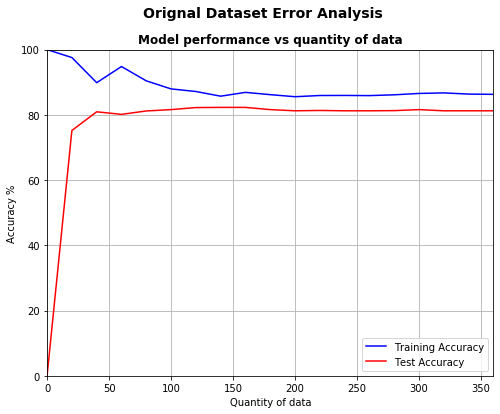

In [93]:
### Error analysis plot
fig = plt.figure(figsize=(8,6))
fig.suptitle('Orignal Dataset Error Analysis', fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,1,1)

x_axis = np.arange(train_acc.shape[0])
x_axis = mean_step*x_axis

ax.plot(x_axis, 100*train_acc, color='b', label='Train Set Accuracy')
ax.plot(x_axis, 100*test_acc, color='r', label='Test Set Accuracy')

ax.set_xlim(0, x_axis[len(x_axis)-1])
ax.set_ylim(0,100)

ax.set_xlabel('Quantity of data')
ax.set_ylabel('Accuracy %')
ax.set_title('Model performance vs quantity of data', fontweight='bold', fontsize=12)

ax.legend(loc='lower right')

plt.grid()
plt.show()

#### From the graph above we can see we have a significant difference between test and training error. This means the difference in generalization error is probably due to overfitting or data misrepresentation.


In [ ]:
y_test = np.array(y_test)
jammed_idx = np.where(y_test==2)